<a href="https://colab.research.google.com/github/meluxis/Analysis_Transformer_ComputationalCost_Optimization/blob/main/BaselineModelT5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Connect google colab and Google Cloud bucket for storage
#Link google account
from google.colab import auth
auth.authenticate_user()

In [2]:
#Link bucket content
BUCKET_NAME = "data_bucket_experimental_analysis"
# Validate bucket
!gsutil ls -b gs://$BUCKET_NAME || gsutil mb -l us-central1 gs://$BUCKET_NAME


gs://data_bucket_experimental_analysis/


In [3]:
#install Tensorflow in environment
!pip install tensorflow
import tensorflow as tf
print("Tensorflow version is",tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 766.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.3 MB/s eta 0:00:00
Tensorflow version is 2.19.0


In [4]:
from google.colab import auth
import os
import tensorflow as tf

# Authenticate with Google Cloud
auth.authenticate_user()

# Set up manual GCS access
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/adc.json"

# TPU Setup (if available)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Connected to TPU:", tpu.master())
except ValueError:
    print("No TPU found. Running on CPU/GPU instead.")


No TPU found. Running on CPU/GPU instead.


In [5]:
#install required dependencies
!pip install transformers datasets torch torchvision
!pip install tf-keras~=2.16
!pip install datasets
!pip install Rouge
!pip install sentence-transformers
!pip install codecarbon
!pip install fvcore
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.3/231.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.1/344.1 kB 24.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
#import libraries
import torch
import time
import psutil  # For memory usage
import os


import sys

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, T5Model
from datasets import load_dataset
import argparse


/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [7]:
#import dataset

dataset = load_dataset("google/Synthetic-Persona-Chat")

train_data = dataset["train"]
test_data = dataset["test"]

# Afficher quelques exemples
print(train_data["user 1 personas"][0:5])  # Afficher 5 exemples
print(train_data["user 2 personas"][0:5])
print(train_data["Best Generated Conversation"][0:5])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.11k [00:00<?, ?B/s]

Synthetic-Persona-Chat_train.csv:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

Synthetic-Persona-Chat_valid.csv:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

Synthetic-Persona-Chat_test.csv:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8938 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/968 [00:00<?, ? examples/s]

['I am 32.\nI do not want a job.\nI play video games all day.\nI still live at home with my parents.', 'I am 32.\nI play video games all day.\nI still live at home with my parents.\nI do not want a job.', 'I am 32.\nI play video games all day.\nI still live at home with my parents.\nI do not want a job.\nI eat all take out.', 'I write.\nI work at mcdonald s.\nI watch youtube videos.\nI have brown hair.', 'I am bald.\nI like to swim.\nMy favorite drink is chocolate milk.\nI don t work.']
['My favorite drink is iced coffee.\nI have a black belt in karate.\nI m in a jazz band and play the saxophone.\nI vacation along lake michigan every summer.', 'I have a ford f150.\nI like ford cars.\nMy truck is black.\nI also like ford trucks.\nI own a ford truck.', 'I can recite the movie young frankenstein word for word.\nI like to make my own clothes.\nI am partially blind.\nI do volunteer work for human rights organizations.\nI can do convincing bird calls.', 'I want to move.\nI don t like feeling

In [8]:
#Textes into Tokens
TOKENIZER = T5Tokenizer.from_pretrained("t5-base")

def preprocess_function(examples):  #Tokenize inputs and targets

  #Combine both personas
  inputs = [p1 + p2 for p1,
            p2 in zip(
                examples["user 1 personas"],
                examples["user 2 personas"])
            ]

  #tokensize inputs (persona 1, persona 2)
  model_inputs = TOKENIZER(inputs,
                           max_length=512,
                           truncation=True,
                           padding="max_length"
                           )

  #tokenize targets (best generated conversations)
  with TOKENIZER.as_target_tokenizer():
      # Ensure 'Best Generated Conversation' is a list of strings
    conversations = [str(conv) for conv in examples["Best Generated Conversation"]]
    labels = TOKENIZER(conversations,
                       max_length=512,
                       truncation=True,
                       padding="max_length"
                       )

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

# Preprocess the dataset
tokenized_train_dataset = train_data.map(preprocess_function,
                                         batched=True,
                                         batch_size=8
                                         )
tokenized_test_dataset = test_data.map(preprocess_function,
                                       batched=True,
                                         batch_size=8)

# Example usage (accessing tokenized data):
print(tokenized_train_dataset[0]["input_ids"])
print(tokenized_train_dataset[0]["labels"])


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/8938 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/968 [00:00<?, ? examples/s]

[27, 183, 3538, 5, 27, 103, 59, 241, 3, 9, 613, 5, 27, 577, 671, 1031, 66, 239, 5, 27, 341, 619, 44, 234, 28, 82, 1362, 5, 7008, 1305, 3281, 19, 3, 867, 26, 1975, 5, 27, 43, 3, 9, 1001, 6782, 16, 3, 4031, 342, 5, 27, 3, 51, 16, 3, 9, 9948, 1928, 11, 577, 8, 3, 7, 9, 226, 32, 6399, 5, 27, 4257, 590, 6957, 2278, 12588, 334, 1248, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [9]:
#Transform Data for compatibility with pytorch

from torch.utils.data import DataLoader

# Create a custom Dataset class
class PersonaChatDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            'input_ids': torch.tensor(item['input_ids']),
            'attention_mask': torch.tensor(item['attention_mask']),
            'labels': torch.tensor(item['labels'])
        }

# Create DataLoaders
train_dataset = PersonaChatDataset(tokenized_train_dataset)
test_dataset = PersonaChatDataset(tokenized_test_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=5) # Adjust batch size as needed
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=5) # Adjust batch size as needed



In [10]:
#Define model from https://colab.research.google.com/github/google-research/text-to-text-transfer-transformer/blob/main/notebooks/t5-trivia.ipynb#scrollTo=DZhAd0U_4B_o
# Required to fix Colab flag parsing issue.

sys.argv = sys.argv[:1]

BASE_DIR = "gs://data_bucket_experimental_analysis" #@param { type: "string" }
if not BASE_DIR or BASE_DIR == "gs://":
  raise ValueError("You must enter a BASE_DIR.")
DATA_DIR = os.path.join(BASE_DIR, "data")
MODELS_DIR = os.path.join(BASE_DIR, "models")
ON_CLOUD = True

MODEL_SIZE = "base" #@param["small", "base", "large", "3B", "11B"]
PRETRAINED_DIR = "t5-base"
MODEL_DIR = os.path.join(MODELS_DIR, MODEL_SIZE)


# Set parallelism and batch size to fit on v2-8 TPU (if possible).
# Limit number of checkpoints to fit within 5GB (if possible).
model_parallelism, train_batch_size, keep_checkpoint_max = {
    "small": (1, 256, 16),
    "base": (2, 128, 8),
    "large": (8, 64, 4),
    "3B": (8, 16, 1),
    "11B": (8, 16, 1)}[MODEL_SIZE]

#tf.io.gfile.makedirs(MODEL_DIR)
# The models from our paper are based on the Mesh Tensorflow Transformer.
#Change to T5ForConditionalGeneration for finetuning task
model = T5ForConditionalGeneration.from_pretrained(PRETRAINED_DIR)


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

[codecarbon ERROR @ 18:48:48] Error: Another instance of codecarbon is probably running as we find `/tmp/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 18:48:48] Another instance of codecarbon is already running. Exiting.


cpu


[codecarbon INFO @ 18:48:55] Energy consumed for RAM : 0.007318 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:48:55] Energy consumed for all CPUs : 0.002480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:48:55] 0.009798 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:49:10] Energy consumed for RAM : 0.007840 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:49:10] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:49:10] 0.010496 kWh of electricity used since the beginning.


Batch 1/1118 - Loss: 12.98524284362793


[codecarbon INFO @ 18:49:25] Energy consumed for RAM : 0.008362 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:49:25] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:49:25] 0.011196 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:49:25] 0.021109 g.CO2eq/s mean an estimation of 665.6977856480878 kg.CO2eq/year


Batch 2/1118 - Loss: 11.878600120544434
Batch 3/1118 - Loss: 10.401887893676758


[codecarbon INFO @ 18:49:40] Energy consumed for RAM : 0.008885 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:49:40] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:49:40] 0.011895 kWh of electricity used since the beginning.


Batch 4/1118 - Loss: 8.883686065673828
Batch 5/1118 - Loss: 7.722062587738037


[codecarbon INFO @ 18:49:55] Energy consumed for RAM : 0.009407 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:49:55] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:49:55] 0.012595 kWh of electricity used since the beginning.


Batch 6/1118 - Loss: 6.975846767425537
Batch 7/1118 - Loss: 6.0684638023376465


[codecarbon INFO @ 18:50:10] Energy consumed for RAM : 0.009930 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:50:10] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:50:10] 0.013295 kWh of electricity used since the beginning.


Batch 8/1118 - Loss: 5.237170219421387
Batch 9/1118 - Loss: 5.014430999755859


[codecarbon INFO @ 18:50:25] Energy consumed for RAM : 0.010453 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:50:25] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:50:25] 0.013995 kWh of electricity used since the beginning.


Batch 10/1118 - Loss: 4.460236549377441
Batch 11/1118 - Loss: 4.423498153686523


[codecarbon INFO @ 18:50:40] Energy consumed for RAM : 0.010975 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:50:40] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:50:40] 0.014694 kWh of electricity used since the beginning.


Batch 12/1118 - Loss: 3.974073648452759
Batch 13/1118 - Loss: 3.6734135150909424


[codecarbon INFO @ 18:50:55] Energy consumed for RAM : 0.011498 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:50:55] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:50:55] 0.015394 kWh of electricity used since the beginning.


Batch 14/1118 - Loss: 3.549696683883667
Batch 15/1118 - Loss: 3.5982470512390137


[codecarbon INFO @ 18:51:10] Energy consumed for RAM : 0.012020 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:51:10] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:51:10] 0.016093 kWh of electricity used since the beginning.


Batch 16/1118 - Loss: 3.2080111503601074
Batch 17/1118 - Loss: 3.008066415786743


[codecarbon INFO @ 18:51:25] Energy consumed for RAM : 0.012543 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:51:25] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:51:25] 0.016793 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:51:25] 0.021110 g.CO2eq/s mean an estimation of 665.7344062649795 kg.CO2eq/year


Batch 18/1118 - Loss: 2.9145631790161133
Batch 19/1118 - Loss: 2.811694622039795


[codecarbon INFO @ 18:51:40] Energy consumed for RAM : 0.013066 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:51:40] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:51:40] 0.017493 kWh of electricity used since the beginning.


Batch 20/1118 - Loss: 2.874715566635132
Batch 21/1118 - Loss: 2.607715606689453


[codecarbon INFO @ 18:51:55] Energy consumed for RAM : 0.013588 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:51:55] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:51:55] 0.018193 kWh of electricity used since the beginning.


Batch 22/1118 - Loss: 2.846315383911133
Batch 23/1118 - Loss: 2.855714797973633


[codecarbon INFO @ 18:52:10] Energy consumed for RAM : 0.014111 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:52:10] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:52:10] 0.018892 kWh of electricity used since the beginning.


Batch 24/1118 - Loss: 2.3980891704559326
Batch 25/1118 - Loss: 2.743638277053833


[codecarbon INFO @ 18:52:25] Energy consumed for RAM : 0.014633 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:52:25] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:52:25] 0.019592 kWh of electricity used since the beginning.


Batch 26/1118 - Loss: 2.576098918914795
Batch 27/1118 - Loss: 2.485610246658325


[codecarbon INFO @ 18:52:40] Energy consumed for RAM : 0.015156 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:52:40] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:52:40] 0.020292 kWh of electricity used since the beginning.


Batch 28/1118 - Loss: 2.5531160831451416
Batch 29/1118 - Loss: 2.4610512256622314


[codecarbon INFO @ 18:52:55] Energy consumed for RAM : 0.015679 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:52:55] Energy consumed for all CPUs : 0.005313 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:52:55] 0.020991 kWh of electricity used since the beginning.


Batch 30/1118 - Loss: 2.64992094039917
Batch 31/1118 - Loss: 2.1623589992523193


[codecarbon INFO @ 18:53:10] Energy consumed for RAM : 0.016201 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:53:10] Energy consumed for all CPUs : 0.005490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:53:10] 0.021691 kWh of electricity used since the beginning.


Batch 32/1118 - Loss: 2.368105411529541
Batch 33/1118 - Loss: 2.031550884246826


[codecarbon INFO @ 18:53:25] Energy consumed for RAM : 0.016724 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:53:25] Energy consumed for all CPUs : 0.005667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:53:25] 0.022391 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:53:25] 0.021111 g.CO2eq/s mean an estimation of 665.747545597775 kg.CO2eq/year


Batch 34/1118 - Loss: 2.376891851425171


[codecarbon INFO @ 18:53:40] Energy consumed for RAM : 0.017247 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:53:40] Energy consumed for all CPUs : 0.005844 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:53:40] 0.023090 kWh of electricity used since the beginning.


Batch 35/1118 - Loss: 2.38586163520813
Batch 36/1118 - Loss: 1.9371984004974365


[codecarbon INFO @ 18:53:55] Energy consumed for RAM : 0.017769 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:53:55] Energy consumed for all CPUs : 0.006021 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:53:55] 0.023790 kWh of electricity used since the beginning.


Batch 37/1118 - Loss: 2.331657886505127
Batch 38/1118 - Loss: 2.213168144226074
Batch 39/1118 - Loss: 2.2993388175964355


[codecarbon INFO @ 18:54:10] Energy consumed for RAM : 0.018292 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:54:10] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:54:10] 0.024490 kWh of electricity used since the beginning.


Batch 40/1118 - Loss: 1.8778010606765747
Batch 41/1118 - Loss: 2.028648614883423


[codecarbon INFO @ 18:54:25] Energy consumed for RAM : 0.018814 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:54:25] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:54:25] 0.025189 kWh of electricity used since the beginning.


Batch 42/1118 - Loss: 1.8870205879211426
Batch 43/1118 - Loss: 2.148024082183838


[codecarbon INFO @ 18:54:40] Energy consumed for RAM : 0.019337 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:54:40] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:54:40] 0.025889 kWh of electricity used since the beginning.


Batch 44/1118 - Loss: 1.9386910200119019
Batch 45/1118 - Loss: 2.067423105239868


[codecarbon INFO @ 18:54:55] Energy consumed for RAM : 0.019860 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:54:55] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:54:55] 0.026589 kWh of electricity used since the beginning.


Batch 46/1118 - Loss: 1.9941354990005493
Batch 47/1118 - Loss: 1.853619933128357


[codecarbon INFO @ 18:55:10] Energy consumed for RAM : 0.020382 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:55:10] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:55:10] 0.027289 kWh of electricity used since the beginning.


Batch 48/1118 - Loss: 1.901545763015747
Batch 49/1118 - Loss: 2.2048537731170654


[codecarbon INFO @ 18:55:25] Energy consumed for RAM : 0.020905 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:55:25] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:55:25] 0.027988 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:55:25] 0.021111 g.CO2eq/s mean an estimation of 665.7595739065185 kg.CO2eq/year


Batch 50/1118 - Loss: 2.2967259883880615
Batch 51/1118 - Loss: 1.937341332435608


[codecarbon INFO @ 18:55:40] Energy consumed for RAM : 0.021428 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:55:40] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:55:40] 0.028688 kWh of electricity used since the beginning.


Batch 52/1118 - Loss: 1.9383150339126587
Batch 53/1118 - Loss: 2.0900943279266357


[codecarbon INFO @ 18:55:55] Energy consumed for RAM : 0.021950 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:55:55] Energy consumed for all CPUs : 0.007438 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:55:55] 0.029388 kWh of electricity used since the beginning.


Batch 54/1118 - Loss: 1.8835597038269043
Batch 55/1118 - Loss: 1.9357162714004517


[codecarbon INFO @ 18:56:10] Energy consumed for RAM : 0.022473 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:56:10] Energy consumed for all CPUs : 0.007615 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:56:10] 0.030088 kWh of electricity used since the beginning.


Batch 56/1118 - Loss: 2.0598559379577637
Batch 57/1118 - Loss: 1.951468825340271


[codecarbon INFO @ 18:56:25] Energy consumed for RAM : 0.022996 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:56:25] Energy consumed for all CPUs : 0.007792 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:56:25] 0.030787 kWh of electricity used since the beginning.


Batch 58/1118 - Loss: 2.044090509414673
Batch 59/1118 - Loss: 1.9661117792129517


[codecarbon INFO @ 18:56:40] Energy consumed for RAM : 0.023518 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:56:40] Energy consumed for all CPUs : 0.007969 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:56:40] 0.031487 kWh of electricity used since the beginning.


Batch 60/1118 - Loss: 2.0805985927581787
Batch 61/1118 - Loss: 1.8550201654434204


[codecarbon INFO @ 18:56:55] Energy consumed for RAM : 0.024041 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:56:55] Energy consumed for all CPUs : 0.008146 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:56:55] 0.032187 kWh of electricity used since the beginning.


Batch 62/1118 - Loss: 2.1667897701263428
Batch 63/1118 - Loss: 1.9130769968032837


[codecarbon INFO @ 18:57:10] Energy consumed for RAM : 0.024563 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:57:10] Energy consumed for all CPUs : 0.008323 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:57:10] 0.032886 kWh of electricity used since the beginning.


Batch 64/1118 - Loss: 2.136915445327759
Batch 65/1118 - Loss: 1.9128254652023315


[codecarbon INFO @ 18:57:25] Energy consumed for RAM : 0.025086 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:57:25] Energy consumed for all CPUs : 0.008500 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:57:25] 0.033586 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:57:25] 0.021111 g.CO2eq/s mean an estimation of 665.7711014421828 kg.CO2eq/year


Batch 66/1118 - Loss: 1.907439112663269
Batch 67/1118 - Loss: 1.9153004884719849


[codecarbon INFO @ 18:57:40] Energy consumed for RAM : 0.025609 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:57:40] Energy consumed for all CPUs : 0.008677 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:57:40] 0.034286 kWh of electricity used since the beginning.


Batch 68/1118 - Loss: 1.642714023590088
Batch 69/1118 - Loss: 1.9649076461791992


[codecarbon INFO @ 18:57:55] Energy consumed for RAM : 0.026132 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:57:55] Energy consumed for all CPUs : 0.008854 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:57:55] 0.034986 kWh of electricity used since the beginning.


Batch 70/1118 - Loss: 1.6842092275619507
Batch 71/1118 - Loss: 1.8282370567321777


[codecarbon INFO @ 18:58:10] Energy consumed for RAM : 0.026655 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:58:10] Energy consumed for all CPUs : 0.009031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:58:10] 0.035686 kWh of electricity used since the beginning.


Batch 72/1118 - Loss: 1.9821645021438599
Batch 73/1118 - Loss: 1.7173950672149658


[codecarbon INFO @ 18:58:25] Energy consumed for RAM : 0.027177 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:58:25] Energy consumed for all CPUs : 0.009209 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:58:25] 0.036386 kWh of electricity used since the beginning.


Batch 74/1118 - Loss: 1.8911477327346802
Batch 75/1118 - Loss: 1.579293966293335


[codecarbon INFO @ 18:58:40] Energy consumed for RAM : 0.027700 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:58:40] Energy consumed for all CPUs : 0.009386 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:58:40] 0.037085 kWh of electricity used since the beginning.


Batch 76/1118 - Loss: 1.6943249702453613
Batch 77/1118 - Loss: 1.8338584899902344


[codecarbon INFO @ 18:58:55] Energy consumed for RAM : 0.028223 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:58:55] Energy consumed for all CPUs : 0.009563 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:58:55] 0.037785 kWh of electricity used since the beginning.


Batch 78/1118 - Loss: 1.6699527502059937
Batch 79/1118 - Loss: 1.73974609375


[codecarbon INFO @ 18:59:10] Energy consumed for RAM : 0.028745 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:59:10] Energy consumed for all CPUs : 0.009740 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:59:10] 0.038485 kWh of electricity used since the beginning.


Batch 80/1118 - Loss: 1.9216662645339966
Batch 81/1118 - Loss: 1.87196946144104


[codecarbon INFO @ 18:59:25] Energy consumed for RAM : 0.029268 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:59:25] Energy consumed for all CPUs : 0.009917 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:59:25] 0.039185 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:59:25] 0.021111 g.CO2eq/s mean an estimation of 665.7624116419742 kg.CO2eq/year


Batch 82/1118 - Loss: 1.8410013914108276
Batch 83/1118 - Loss: 1.878805160522461


[codecarbon INFO @ 18:59:40] Energy consumed for RAM : 0.029790 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:59:40] Energy consumed for all CPUs : 0.010094 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:59:40] 0.039884 kWh of electricity used since the beginning.


Batch 84/1118 - Loss: 1.6316827535629272
Batch 85/1118 - Loss: 1.760149359703064


[codecarbon INFO @ 18:59:55] Energy consumed for RAM : 0.030313 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 18:59:55] Energy consumed for all CPUs : 0.010271 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:59:55] 0.040584 kWh of electricity used since the beginning.


Batch 86/1118 - Loss: 1.6964683532714844
Batch 87/1118 - Loss: 1.9359041452407837
Batch 88/1118 - Loss: 1.8878920078277588


[codecarbon INFO @ 19:00:10] Energy consumed for RAM : 0.030835 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:00:10] Energy consumed for all CPUs : 0.010448 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:00:10] 0.041283 kWh of electricity used since the beginning.


Batch 89/1118 - Loss: 1.7758864164352417
Batch 90/1118 - Loss: 1.8977731466293335


[codecarbon INFO @ 19:00:25] Energy consumed for RAM : 0.031358 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:00:25] Energy consumed for all CPUs : 0.010625 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:00:25] 0.041983 kWh of electricity used since the beginning.


Batch 91/1118 - Loss: 1.9709420204162598
Batch 92/1118 - Loss: 1.905582308769226


[codecarbon INFO @ 19:00:40] Energy consumed for RAM : 0.031881 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:00:40] Energy consumed for all CPUs : 0.010802 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:00:40] 0.042683 kWh of electricity used since the beginning.


Batch 93/1118 - Loss: 1.8382974863052368
Batch 94/1118 - Loss: 1.8944034576416016


[codecarbon INFO @ 19:00:55] Energy consumed for RAM : 0.032404 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:00:55] Energy consumed for all CPUs : 0.010979 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:00:55] 0.043383 kWh of electricity used since the beginning.


Batch 95/1118 - Loss: 1.7388203144073486
Batch 96/1118 - Loss: 1.624942421913147


[codecarbon INFO @ 19:01:10] Energy consumed for RAM : 0.032926 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:01:10] Energy consumed for all CPUs : 0.011156 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:01:10] 0.044083 kWh of electricity used since the beginning.


Batch 97/1118 - Loss: 1.7858679294586182
Batch 98/1118 - Loss: 2.0291244983673096


[codecarbon INFO @ 19:01:25] Energy consumed for RAM : 0.033449 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:01:25] Energy consumed for all CPUs : 0.011333 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:01:25] 0.044782 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:01:25] 0.021111 g.CO2eq/s mean an estimation of 665.7502640406328 kg.CO2eq/year


Batch 99/1118 - Loss: 1.7260023355484009
Batch 100/1118 - Loss: 1.875334620475769


[codecarbon INFO @ 19:01:40] Energy consumed for RAM : 0.033971 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:01:40] Energy consumed for all CPUs : 0.011511 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:01:40] 0.045482 kWh of electricity used since the beginning.


Batch 101/1118 - Loss: 1.7256405353546143
Batch 102/1118 - Loss: 1.9008432626724243


[codecarbon INFO @ 19:01:55] Energy consumed for RAM : 0.034494 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:01:55] Energy consumed for all CPUs : 0.011688 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:01:55] 0.046182 kWh of electricity used since the beginning.


Batch 103/1118 - Loss: 1.7789427042007446
Batch 104/1118 - Loss: 1.5376579761505127


[codecarbon INFO @ 19:02:10] Energy consumed for RAM : 0.035017 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:02:10] Energy consumed for all CPUs : 0.011865 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:02:10] 0.046881 kWh of electricity used since the beginning.


Batch 105/1118 - Loss: 1.8163585662841797
Batch 106/1118 - Loss: 1.4461734294891357


[codecarbon INFO @ 19:02:25] Energy consumed for RAM : 0.035539 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:02:25] Energy consumed for all CPUs : 0.012042 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:02:25] 0.047581 kWh of electricity used since the beginning.


Batch 107/1118 - Loss: 1.9097263813018799
Batch 108/1118 - Loss: 1.726325273513794


[codecarbon INFO @ 19:02:40] Energy consumed for RAM : 0.036062 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:02:40] Energy consumed for all CPUs : 0.012219 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:02:40] 0.048281 kWh of electricity used since the beginning.


Batch 109/1118 - Loss: 1.669205904006958
Batch 110/1118 - Loss: 1.4992703199386597


[codecarbon INFO @ 19:02:55] Energy consumed for RAM : 0.036585 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:02:55] Energy consumed for all CPUs : 0.012396 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:02:55] 0.048980 kWh of electricity used since the beginning.


Batch 111/1118 - Loss: 1.624955177307129
Batch 112/1118 - Loss: 1.7073277235031128


[codecarbon INFO @ 19:03:10] Energy consumed for RAM : 0.037107 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:03:10] Energy consumed for all CPUs : 0.012573 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:03:10] 0.049680 kWh of electricity used since the beginning.


Batch 113/1118 - Loss: 1.8342180252075195
Batch 114/1118 - Loss: 1.56650710105896


[codecarbon INFO @ 19:03:25] Energy consumed for RAM : 0.037630 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:03:25] Energy consumed for all CPUs : 0.012750 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:03:25] 0.050380 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:03:25] 0.021111 g.CO2eq/s mean an estimation of 665.7518835459861 kg.CO2eq/year


Batch 115/1118 - Loss: 1.7175978422164917
Batch 116/1118 - Loss: 1.9114636182785034


[codecarbon INFO @ 19:03:40] Energy consumed for RAM : 0.038152 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:03:40] Energy consumed for all CPUs : 0.012927 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:03:40] 0.051080 kWh of electricity used since the beginning.


Batch 117/1118 - Loss: 1.736806869506836
Batch 118/1118 - Loss: 1.615901231765747


[codecarbon INFO @ 19:03:55] Energy consumed for RAM : 0.038675 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:03:55] Energy consumed for all CPUs : 0.013104 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:03:55] 0.051779 kWh of electricity used since the beginning.


Batch 119/1118 - Loss: 1.693215250968933
Batch 120/1118 - Loss: 1.4606269598007202


[codecarbon INFO @ 19:04:10] Energy consumed for RAM : 0.039198 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:04:10] Energy consumed for all CPUs : 0.013281 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:04:10] 0.052479 kWh of electricity used since the beginning.


Batch 121/1118 - Loss: 1.501869559288025
Batch 122/1118 - Loss: 1.6427088975906372


[codecarbon INFO @ 19:04:25] Energy consumed for RAM : 0.039720 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:04:25] Energy consumed for all CPUs : 0.013458 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:04:25] 0.053179 kWh of electricity used since the beginning.


Batch 123/1118 - Loss: 1.6549416780471802
Batch 124/1118 - Loss: 1.5591009855270386


[codecarbon INFO @ 19:04:40] Energy consumed for RAM : 0.040243 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:04:40] Energy consumed for all CPUs : 0.013636 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:04:40] 0.053878 kWh of electricity used since the beginning.


Batch 125/1118 - Loss: 1.6173865795135498
Batch 126/1118 - Loss: 1.6272426843643188


[codecarbon INFO @ 19:04:55] Energy consumed for RAM : 0.040766 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:04:55] Energy consumed for all CPUs : 0.013813 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:04:55] 0.054578 kWh of electricity used since the beginning.


Batch 127/1118 - Loss: 1.6379934549331665
Batch 128/1118 - Loss: 1.5157681703567505


[codecarbon INFO @ 19:05:10] Energy consumed for RAM : 0.041288 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:05:10] Energy consumed for all CPUs : 0.013990 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:05:10] 0.055278 kWh of electricity used since the beginning.


Batch 129/1118 - Loss: 1.7136130332946777
Batch 130/1118 - Loss: 1.5758297443389893


[codecarbon INFO @ 19:05:25] Energy consumed for RAM : 0.041811 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:05:25] Energy consumed for all CPUs : 0.014167 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:05:25] 0.055978 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:05:25] 0.021110 g.CO2eq/s mean an estimation of 665.7382377207934 kg.CO2eq/year


Batch 131/1118 - Loss: 1.4564416408538818
Batch 132/1118 - Loss: 1.8503676652908325


[codecarbon INFO @ 19:05:40] Energy consumed for RAM : 0.042333 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:05:40] Energy consumed for all CPUs : 0.014344 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:05:40] 0.056677 kWh of electricity used since the beginning.


Batch 133/1118 - Loss: 1.5567281246185303
Batch 134/1118 - Loss: 1.5699033737182617


[codecarbon INFO @ 19:05:55] Energy consumed for RAM : 0.042856 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:05:55] Energy consumed for all CPUs : 0.014521 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:05:55] 0.057377 kWh of electricity used since the beginning.


Batch 135/1118 - Loss: 1.6819651126861572
Batch 136/1118 - Loss: 1.5085904598236084


[codecarbon INFO @ 19:06:10] Energy consumed for RAM : 0.043378 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:06:10] Energy consumed for all CPUs : 0.014698 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:06:10] 0.058076 kWh of electricity used since the beginning.


Batch 137/1118 - Loss: 1.6852331161499023
Batch 138/1118 - Loss: 1.4836955070495605


[codecarbon INFO @ 19:06:25] Energy consumed for RAM : 0.043901 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:06:25] Energy consumed for all CPUs : 0.014875 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:06:25] 0.058776 kWh of electricity used since the beginning.


Batch 139/1118 - Loss: 1.3909920454025269
Batch 140/1118 - Loss: 1.5650544166564941


[codecarbon INFO @ 19:06:40] Energy consumed for RAM : 0.044424 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:06:40] Energy consumed for all CPUs : 0.015052 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:06:40] 0.059476 kWh of electricity used since the beginning.


Batch 141/1118 - Loss: 1.7667887210845947
Batch 142/1118 - Loss: 1.6140435934066772


[codecarbon INFO @ 19:06:55] Energy consumed for RAM : 0.044946 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:06:55] Energy consumed for all CPUs : 0.015229 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:06:55] 0.060176 kWh of electricity used since the beginning.


Batch 143/1118 - Loss: 1.845855712890625
Batch 144/1118 - Loss: 1.7503154277801514


[codecarbon INFO @ 19:07:10] Energy consumed for RAM : 0.045469 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:07:10] Energy consumed for all CPUs : 0.015406 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:07:10] 0.060875 kWh of electricity used since the beginning.


Batch 145/1118 - Loss: 1.47405207157135
Batch 146/1118 - Loss: 1.3680888414382935


[codecarbon INFO @ 19:07:25] Energy consumed for RAM : 0.045992 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:07:25] Energy consumed for all CPUs : 0.015583 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:07:25] 0.061575 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:07:25] 0.021110 g.CO2eq/s mean an estimation of 665.7219272768922 kg.CO2eq/year


Batch 147/1118 - Loss: 1.5576221942901611
Batch 148/1118 - Loss: 1.4430912733078003


[codecarbon INFO @ 19:07:40] Energy consumed for RAM : 0.046514 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:07:40] Energy consumed for all CPUs : 0.015760 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:07:40] 0.062275 kWh of electricity used since the beginning.


Batch 149/1118 - Loss: 1.5370981693267822
Batch 150/1118 - Loss: 1.6249308586120605
Batch 151/1118 - Loss: 1.4617598056793213


[codecarbon INFO @ 19:07:55] Energy consumed for RAM : 0.047037 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:07:55] Energy consumed for all CPUs : 0.015938 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:07:55] 0.062975 kWh of electricity used since the beginning.


Batch 152/1118 - Loss: 1.5928268432617188
Batch 153/1118 - Loss: 1.557907223701477


[codecarbon INFO @ 19:08:10] Energy consumed for RAM : 0.047560 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:08:10] Energy consumed for all CPUs : 0.016115 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:08:10] 0.063674 kWh of electricity used since the beginning.


Batch 154/1118 - Loss: 1.673413872718811
Batch 155/1118 - Loss: 1.5620232820510864


[codecarbon INFO @ 19:08:25] Energy consumed for RAM : 0.048082 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:08:25] Energy consumed for all CPUs : 0.016292 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:08:25] 0.064374 kWh of electricity used since the beginning.


Batch 156/1118 - Loss: 1.527663230895996
Batch 157/1118 - Loss: 1.7291855812072754


[codecarbon INFO @ 19:08:40] Energy consumed for RAM : 0.048605 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:08:40] Energy consumed for all CPUs : 0.016469 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:08:40] 0.065074 kWh of electricity used since the beginning.


Batch 158/1118 - Loss: 1.5842106342315674
Batch 159/1118 - Loss: 1.4644354581832886


[codecarbon INFO @ 19:08:55] Energy consumed for RAM : 0.049127 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:08:55] Energy consumed for all CPUs : 0.016646 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:08:55] 0.065773 kWh of electricity used since the beginning.


Batch 160/1118 - Loss: 1.4327501058578491
Batch 161/1118 - Loss: 1.8073256015777588


[codecarbon INFO @ 19:09:10] Energy consumed for RAM : 0.049650 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:09:10] Energy consumed for all CPUs : 0.016823 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:09:10] 0.066473 kWh of electricity used since the beginning.


Batch 162/1118 - Loss: 1.2847254276275635
Batch 163/1118 - Loss: 1.4332034587860107


[codecarbon INFO @ 19:09:25] Energy consumed for RAM : 0.050173 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:09:25] Energy consumed for all CPUs : 0.017000 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:09:25] 0.067173 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:09:25] 0.021111 g.CO2eq/s mean an estimation of 665.7567367519795 kg.CO2eq/year


Batch 164/1118 - Loss: 1.4797308444976807


[codecarbon INFO @ 19:09:40] Energy consumed for RAM : 0.050695 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:09:40] Energy consumed for all CPUs : 0.017177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:09:40] 0.067872 kWh of electricity used since the beginning.


Batch 165/1118 - Loss: 1.644692301750183
Batch 166/1118 - Loss: 1.5693126916885376


[codecarbon INFO @ 19:09:55] Energy consumed for RAM : 0.051218 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:09:55] Energy consumed for all CPUs : 0.017354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:09:55] 0.068572 kWh of electricity used since the beginning.


Batch 167/1118 - Loss: 1.5149884223937988
Batch 168/1118 - Loss: 1.4380375146865845


[codecarbon INFO @ 19:10:10] Energy consumed for RAM : 0.051741 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:10:10] Energy consumed for all CPUs : 0.017531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:10:10] 0.069272 kWh of electricity used since the beginning.


Batch 169/1118 - Loss: 1.5727858543395996
Batch 170/1118 - Loss: 1.352779507637024


[codecarbon INFO @ 19:10:25] Energy consumed for RAM : 0.052263 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:10:25] Energy consumed for all CPUs : 0.017708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:10:25] 0.069971 kWh of electricity used since the beginning.


Batch 171/1118 - Loss: 1.4952068328857422
Batch 172/1118 - Loss: 1.3594814538955688


[codecarbon INFO @ 19:10:40] Energy consumed for RAM : 0.052786 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:10:40] Energy consumed for all CPUs : 0.017885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:10:40] 0.070671 kWh of electricity used since the beginning.


Batch 173/1118 - Loss: 1.4234046936035156
Batch 174/1118 - Loss: 1.4163049459457397


[codecarbon INFO @ 19:10:55] Energy consumed for RAM : 0.053308 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:10:55] Energy consumed for all CPUs : 0.018062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:10:55] 0.071371 kWh of electricity used since the beginning.


Batch 175/1118 - Loss: 1.6427264213562012
Batch 176/1118 - Loss: 1.512412190437317


[codecarbon INFO @ 19:11:10] Energy consumed for RAM : 0.053831 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:11:10] Energy consumed for all CPUs : 0.018240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:11:10] 0.072071 kWh of electricity used since the beginning.


Batch 177/1118 - Loss: 1.4365495443344116
Batch 178/1118 - Loss: 1.428071141242981


[codecarbon INFO @ 19:11:25] Energy consumed for RAM : 0.054354 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:11:25] Energy consumed for all CPUs : 0.018417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:11:25] 0.072770 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:11:25] 0.021111 g.CO2eq/s mean an estimation of 665.7656610740395 kg.CO2eq/year


Batch 179/1118 - Loss: 1.4094520807266235
Batch 180/1118 - Loss: 1.6580619812011719
Batch 181/1118 - Loss: 1.4188227653503418


[codecarbon INFO @ 19:11:40] Energy consumed for RAM : 0.054876 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:11:40] Energy consumed for all CPUs : 0.018594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:11:40] 0.073470 kWh of electricity used since the beginning.


Batch 182/1118 - Loss: 1.4886239767074585
Batch 183/1118 - Loss: 1.6028767824172974


[codecarbon INFO @ 19:11:55] Energy consumed for RAM : 0.055399 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:11:55] Energy consumed for all CPUs : 0.018771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:11:55] 0.074170 kWh of electricity used since the beginning.


Batch 184/1118 - Loss: 1.624940276145935
Batch 185/1118 - Loss: 1.6079777479171753


[codecarbon INFO @ 19:12:10] Energy consumed for RAM : 0.055922 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:12:10] Energy consumed for all CPUs : 0.018948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:12:10] 0.074869 kWh of electricity used since the beginning.


Batch 186/1118 - Loss: 1.7232557535171509
Batch 187/1118 - Loss: 1.6058653593063354


[codecarbon INFO @ 19:12:25] Energy consumed for RAM : 0.056445 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:12:25] Energy consumed for all CPUs : 0.019125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:12:25] 0.075570 kWh of electricity used since the beginning.


Batch 188/1118 - Loss: 1.501584529876709
Batch 189/1118 - Loss: 1.374590277671814


[codecarbon INFO @ 19:12:40] Energy consumed for RAM : 0.056968 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:12:40] Energy consumed for all CPUs : 0.019302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:12:40] 0.076270 kWh of electricity used since the beginning.


Batch 190/1118 - Loss: 1.523625373840332
Batch 191/1118 - Loss: 1.372058629989624


[codecarbon INFO @ 19:12:55] Energy consumed for RAM : 0.057490 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:12:55] Energy consumed for all CPUs : 0.019479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:12:55] 0.076970 kWh of electricity used since the beginning.


Batch 192/1118 - Loss: 1.296810269355774
Batch 193/1118 - Loss: 1.6751658916473389


[codecarbon INFO @ 19:13:10] Energy consumed for RAM : 0.058013 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:13:10] Energy consumed for all CPUs : 0.019656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:13:10] 0.077669 kWh of electricity used since the beginning.


Batch 194/1118 - Loss: 1.5039862394332886
Batch 195/1118 - Loss: 1.3946845531463623


[codecarbon INFO @ 19:13:25] Energy consumed for RAM : 0.058538 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:13:25] Energy consumed for all CPUs : 0.019834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:13:25] 0.078372 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:13:25] 0.021109 g.CO2eq/s mean an estimation of 665.7012996115482 kg.CO2eq/year


Batch 196/1118 - Loss: 1.56844961643219
Batch 197/1118 - Loss: 1.4950069189071655


[codecarbon INFO @ 19:13:40] Energy consumed for RAM : 0.059060 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:13:40] Energy consumed for all CPUs : 0.020011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:13:40] 0.079072 kWh of electricity used since the beginning.


Batch 198/1118 - Loss: 1.454845905303955
Batch 199/1118 - Loss: 1.4165325164794922


[codecarbon INFO @ 19:13:55] Energy consumed for RAM : 0.059583 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:13:55] Energy consumed for all CPUs : 0.020188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:13:55] 0.079771 kWh of electricity used since the beginning.


Batch 200/1118 - Loss: 1.5044407844543457
Batch 201/1118 - Loss: 1.460767149925232


[codecarbon INFO @ 19:14:10] Energy consumed for RAM : 0.060106 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:14:10] Energy consumed for all CPUs : 0.020365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:14:10] 0.080471 kWh of electricity used since the beginning.


Batch 202/1118 - Loss: 1.4095053672790527
Batch 203/1118 - Loss: 1.3108049631118774


[codecarbon INFO @ 19:14:25] Energy consumed for RAM : 0.060629 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:14:25] Energy consumed for all CPUs : 0.020543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:14:25] 0.081171 kWh of electricity used since the beginning.


Batch 204/1118 - Loss: 1.3238129615783691
Batch 205/1118 - Loss: 1.5671381950378418


[codecarbon INFO @ 19:14:40] Energy consumed for RAM : 0.061151 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:14:40] Energy consumed for all CPUs : 0.020720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:14:40] 0.081871 kWh of electricity used since the beginning.


Batch 206/1118 - Loss: 1.324097752571106
Batch 207/1118 - Loss: 1.3460050821304321


[codecarbon INFO @ 19:14:55] Energy consumed for RAM : 0.061674 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:14:55] Energy consumed for all CPUs : 0.020897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:14:55] 0.082571 kWh of electricity used since the beginning.


Batch 208/1118 - Loss: 1.4753971099853516
Batch 209/1118 - Loss: 1.480783462524414


[codecarbon INFO @ 19:15:10] Energy consumed for RAM : 0.062196 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:15:10] Energy consumed for all CPUs : 0.021074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:15:10] 0.083270 kWh of electricity used since the beginning.


Batch 210/1118 - Loss: 1.292734980583191
Batch 211/1118 - Loss: 1.234208583831787


[codecarbon INFO @ 19:15:25] Energy consumed for RAM : 0.062719 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:15:25] Energy consumed for all CPUs : 0.021251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:15:25] 0.083970 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:15:25] 0.021111 g.CO2eq/s mean an estimation of 665.7629636715386 kg.CO2eq/year


Batch 212/1118 - Loss: 1.5060244798660278
Batch 213/1118 - Loss: 1.4583044052124023


[codecarbon INFO @ 19:15:40] Energy consumed for RAM : 0.063242 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:15:40] Energy consumed for all CPUs : 0.021428 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:15:40] 0.084670 kWh of electricity used since the beginning.


Batch 214/1118 - Loss: 1.688063621520996
Batch 215/1118 - Loss: 1.4786717891693115


[codecarbon INFO @ 19:15:55] Energy consumed for RAM : 0.063766 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:15:55] Energy consumed for all CPUs : 0.021606 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:15:55] 0.085371 kWh of electricity used since the beginning.


Batch 216/1118 - Loss: 1.4109681844711304
Batch 217/1118 - Loss: 1.6579508781433105


[codecarbon INFO @ 19:16:10] Energy consumed for RAM : 0.064288 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:16:10] Energy consumed for all CPUs : 0.021783 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:16:10] 0.086071 kWh of electricity used since the beginning.


Batch 218/1118 - Loss: 1.5341259241104126
Batch 219/1118 - Loss: 1.3013402223587036


[codecarbon INFO @ 19:16:25] Energy consumed for RAM : 0.064811 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:16:25] Energy consumed for all CPUs : 0.021960 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:16:25] 0.086771 kWh of electricity used since the beginning.


Batch 220/1118 - Loss: 1.4139295816421509
Batch 221/1118 - Loss: 1.4464753866195679


[codecarbon INFO @ 19:16:40] Energy consumed for RAM : 0.065334 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:16:40] Energy consumed for all CPUs : 0.022137 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:16:40] 0.087470 kWh of electricity used since the beginning.


Batch 222/1118 - Loss: 1.6079667806625366
Batch 223/1118 - Loss: 1.5782369375228882


[codecarbon INFO @ 19:16:55] Energy consumed for RAM : 0.065856 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:16:55] Energy consumed for all CPUs : 0.022314 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:16:55] 0.088170 kWh of electricity used since the beginning.


Batch 224/1118 - Loss: 1.5278782844543457
Batch 225/1118 - Loss: 1.4927809238433838


[codecarbon INFO @ 19:17:10] Energy consumed for RAM : 0.066379 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:17:10] Energy consumed for all CPUs : 0.022491 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:17:10] 0.088870 kWh of electricity used since the beginning.


Batch 226/1118 - Loss: 1.4876689910888672
Batch 227/1118 - Loss: 1.446940541267395


[codecarbon INFO @ 19:17:25] Energy consumed for RAM : 0.066901 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:17:25] Energy consumed for all CPUs : 0.022668 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:17:25] 0.089569 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:17:25] 0.021110 g.CO2eq/s mean an estimation of 665.737740636771 kg.CO2eq/year


Batch 228/1118 - Loss: 1.3757266998291016
Batch 229/1118 - Loss: 1.4785776138305664


[codecarbon INFO @ 19:17:40] Energy consumed for RAM : 0.067424 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:17:40] Energy consumed for all CPUs : 0.022845 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:17:40] 0.090269 kWh of electricity used since the beginning.


Batch 230/1118 - Loss: 1.2933121919631958
Batch 231/1118 - Loss: 1.5476776361465454


[codecarbon INFO @ 19:17:55] Energy consumed for RAM : 0.067946 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:17:55] Energy consumed for all CPUs : 0.023022 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:17:55] 0.090969 kWh of electricity used since the beginning.


Batch 232/1118 - Loss: 1.5370060205459595
Batch 233/1118 - Loss: 1.484298586845398
Batch 234/1118 - Loss: 1.3865665197372437


[codecarbon INFO @ 19:18:10] Energy consumed for RAM : 0.068469 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:18:10] Energy consumed for all CPUs : 0.023199 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:18:10] 0.091668 kWh of electricity used since the beginning.


Batch 235/1118 - Loss: 1.3356481790542603
Batch 236/1118 - Loss: 1.4995251893997192


[codecarbon INFO @ 19:18:25] Energy consumed for RAM : 0.068992 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:18:25] Energy consumed for all CPUs : 0.023376 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:18:25] 0.092368 kWh of electricity used since the beginning.


Batch 237/1118 - Loss: 1.3505703210830688
Batch 238/1118 - Loss: 1.4882838726043701


[codecarbon INFO @ 19:18:40] Energy consumed for RAM : 0.069514 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:18:40] Energy consumed for all CPUs : 0.023553 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:18:40] 0.093068 kWh of electricity used since the beginning.


Batch 239/1118 - Loss: 1.4826103448867798
Batch 240/1118 - Loss: 1.319432258605957


[codecarbon INFO @ 19:18:55] Energy consumed for RAM : 0.070037 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:18:55] Energy consumed for all CPUs : 0.023730 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:18:55] 0.093767 kWh of electricity used since the beginning.


Batch 241/1118 - Loss: 1.4649395942687988
Batch 242/1118 - Loss: 1.5179367065429688


[codecarbon INFO @ 19:19:10] Energy consumed for RAM : 0.070560 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:19:10] Energy consumed for all CPUs : 0.023908 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:19:10] 0.094467 kWh of electricity used since the beginning.


Batch 243/1118 - Loss: 1.4994510412216187
Batch 244/1118 - Loss: 1.3178455829620361


[codecarbon INFO @ 19:19:25] Energy consumed for RAM : 0.071082 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:19:25] Energy consumed for all CPUs : 0.024085 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:19:25] 0.095167 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:19:25] 0.021112 g.CO2eq/s mean an estimation of 665.7877990349851 kg.CO2eq/year


Batch 245/1118 - Loss: 1.488619089126587
Batch 246/1118 - Loss: 1.669359564781189
Batch 247/1118 - Loss: 1.5125657320022583


[codecarbon INFO @ 19:19:40] Energy consumed for RAM : 0.071605 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:19:40] Energy consumed for all CPUs : 0.024262 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:19:40] 0.095867 kWh of electricity used since the beginning.


Batch 248/1118 - Loss: 1.3419173955917358
Batch 249/1118 - Loss: 1.2773932218551636


[codecarbon INFO @ 19:19:55] Energy consumed for RAM : 0.072127 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:19:55] Energy consumed for all CPUs : 0.024439 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:19:55] 0.096566 kWh of electricity used since the beginning.


Batch 250/1118 - Loss: 1.4965184926986694
Batch 251/1118 - Loss: 1.3811427354812622


[codecarbon INFO @ 19:20:10] Energy consumed for RAM : 0.072650 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:20:10] Energy consumed for all CPUs : 0.024616 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:20:10] 0.097266 kWh of electricity used since the beginning.


Batch 252/1118 - Loss: 1.6412559747695923
Batch 253/1118 - Loss: 1.3404688835144043


[codecarbon INFO @ 19:20:25] Energy consumed for RAM : 0.073174 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:20:25] Energy consumed for all CPUs : 0.024793 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:20:25] 0.097968 kWh of electricity used since the beginning.


Batch 254/1118 - Loss: 1.4781262874603271
Batch 255/1118 - Loss: 1.572714924812317


[codecarbon INFO @ 19:20:40] Energy consumed for RAM : 0.073697 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:20:40] Energy consumed for all CPUs : 0.024971 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:20:40] 0.098668 kWh of electricity used since the beginning.


Batch 256/1118 - Loss: 1.1909805536270142
Batch 257/1118 - Loss: 1.311231255531311


[codecarbon INFO @ 19:20:55] Energy consumed for RAM : 0.074220 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:20:55] Energy consumed for all CPUs : 0.025148 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:20:55] 0.099368 kWh of electricity used since the beginning.


Batch 258/1118 - Loss: 1.2939029932022095
Batch 259/1118 - Loss: 1.4839359521865845


[codecarbon INFO @ 19:21:10] Energy consumed for RAM : 0.074746 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:21:10] Energy consumed for all CPUs : 0.025326 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:21:10] 0.100072 kWh of electricity used since the beginning.


Batch 260/1118 - Loss: 1.3044196367263794
Batch 261/1118 - Loss: 1.4019944667816162


[codecarbon INFO @ 19:21:25] Energy consumed for RAM : 0.075269 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:21:25] Energy consumed for all CPUs : 0.025503 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:21:25] 0.100772 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:21:25] 0.021111 g.CO2eq/s mean an estimation of 665.7428958131671 kg.CO2eq/year


Batch 262/1118 - Loss: 1.3928642272949219
Batch 263/1118 - Loss: 1.2991269826889038


[codecarbon INFO @ 19:21:40] Energy consumed for RAM : 0.075791 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:21:40] Energy consumed for all CPUs : 0.025680 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:21:40] 0.101471 kWh of electricity used since the beginning.


Batch 264/1118 - Loss: 1.3930209875106812
Batch 265/1118 - Loss: 1.2776018381118774


[codecarbon INFO @ 19:21:55] Energy consumed for RAM : 0.076314 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:21:55] Energy consumed for all CPUs : 0.025857 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:21:55] 0.102171 kWh of electricity used since the beginning.


Batch 266/1118 - Loss: 1.5348039865493774
Batch 267/1118 - Loss: 1.2123266458511353


[codecarbon INFO @ 19:22:10] Energy consumed for RAM : 0.076837 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:22:10] Energy consumed for all CPUs : 0.026034 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:22:10] 0.102871 kWh of electricity used since the beginning.


Batch 268/1118 - Loss: 1.5246896743774414
Batch 269/1118 - Loss: 1.3770548105239868


[codecarbon INFO @ 19:22:25] Energy consumed for RAM : 0.077359 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:22:25] Energy consumed for all CPUs : 0.026211 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:22:25] 0.103570 kWh of electricity used since the beginning.


Batch 270/1118 - Loss: 1.3839948177337646
Batch 271/1118 - Loss: 1.3232495784759521


[codecarbon INFO @ 19:22:40] Energy consumed for RAM : 0.077882 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:22:40] Energy consumed for all CPUs : 0.026388 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:22:40] 0.104270 kWh of electricity used since the beginning.


Batch 272/1118 - Loss: 1.274625539779663
Batch 273/1118 - Loss: 1.522114634513855


[codecarbon INFO @ 19:22:55] Energy consumed for RAM : 0.078404 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:22:55] Energy consumed for all CPUs : 0.026565 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:22:55] 0.104970 kWh of electricity used since the beginning.


Batch 274/1118 - Loss: 1.5569339990615845
Batch 275/1118 - Loss: 1.4599307775497437


[codecarbon INFO @ 19:23:10] Energy consumed for RAM : 0.078927 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:23:10] Energy consumed for all CPUs : 0.026743 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:23:10] 0.105669 kWh of electricity used since the beginning.


Batch 276/1118 - Loss: 1.1401984691619873
Batch 277/1118 - Loss: 1.3247900009155273


[codecarbon INFO @ 19:23:25] Energy consumed for RAM : 0.079450 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:23:25] Energy consumed for all CPUs : 0.026920 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:23:25] 0.106369 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:23:25] 0.021111 g.CO2eq/s mean an estimation of 665.7649358445013 kg.CO2eq/year


Batch 278/1118 - Loss: 1.2823584079742432
Batch 279/1118 - Loss: 1.2926883697509766


[codecarbon INFO @ 19:23:40] Energy consumed for RAM : 0.079972 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:23:40] Energy consumed for all CPUs : 0.027097 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:23:40] 0.107069 kWh of electricity used since the beginning.


Batch 280/1118 - Loss: 1.4211204051971436
Batch 281/1118 - Loss: 1.441168189048767


[codecarbon INFO @ 19:23:55] Energy consumed for RAM : 0.080495 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:23:55] Energy consumed for all CPUs : 0.027274 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:23:55] 0.107769 kWh of electricity used since the beginning.


Batch 282/1118 - Loss: 1.3480473756790161
Batch 283/1118 - Loss: 1.37783682346344


[codecarbon INFO @ 19:24:10] Energy consumed for RAM : 0.081018 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:24:10] Energy consumed for all CPUs : 0.027451 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:24:10] 0.108469 kWh of electricity used since the beginning.


Batch 284/1118 - Loss: 1.348794937133789
Batch 285/1118 - Loss: 1.3585777282714844


[codecarbon INFO @ 19:24:25] Energy consumed for RAM : 0.081540 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:24:25] Energy consumed for all CPUs : 0.027628 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:24:25] 0.109168 kWh of electricity used since the beginning.


Batch 286/1118 - Loss: 1.2533386945724487
Batch 287/1118 - Loss: 1.3600577116012573


[codecarbon INFO @ 19:24:40] Energy consumed for RAM : 0.082063 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:24:40] Energy consumed for all CPUs : 0.027805 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:24:40] 0.109868 kWh of electricity used since the beginning.


Batch 288/1118 - Loss: 1.3977371454238892
Batch 289/1118 - Loss: 1.356446385383606


[codecarbon INFO @ 19:24:55] Energy consumed for RAM : 0.082585 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:24:55] Energy consumed for all CPUs : 0.027982 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:24:55] 0.110568 kWh of electricity used since the beginning.


Batch 290/1118 - Loss: 1.5757611989974976
Batch 291/1118 - Loss: 1.192150592803955


[codecarbon INFO @ 19:25:10] Energy consumed for RAM : 0.083108 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:25:10] Energy consumed for all CPUs : 0.028159 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:25:10] 0.111267 kWh of electricity used since the beginning.


Batch 292/1118 - Loss: 1.4321882724761963
Batch 293/1118 - Loss: 1.416515827178955


[codecarbon INFO @ 19:25:25] Energy consumed for RAM : 0.083631 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:25:25] Energy consumed for all CPUs : 0.028336 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:25:25] 0.111967 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:25:25] 0.021111 g.CO2eq/s mean an estimation of 665.7627458501353 kg.CO2eq/year


Batch 294/1118 - Loss: 1.3742414712905884
Batch 295/1118 - Loss: 1.4399797916412354


[codecarbon INFO @ 19:25:40] Energy consumed for RAM : 0.084154 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:25:40] Energy consumed for all CPUs : 0.028513 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:25:40] 0.112667 kWh of electricity used since the beginning.


Batch 296/1118 - Loss: 1.4310252666473389
Batch 297/1118 - Loss: 1.1629067659378052


[codecarbon INFO @ 19:25:55] Energy consumed for RAM : 0.084676 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:25:55] Energy consumed for all CPUs : 0.028691 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:25:55] 0.113367 kWh of electricity used since the beginning.


Batch 298/1118 - Loss: 1.3479127883911133
Batch 299/1118 - Loss: 1.2064783573150635


[codecarbon INFO @ 19:26:10] Energy consumed for RAM : 0.085199 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:26:10] Energy consumed for all CPUs : 0.028868 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:26:10] 0.114067 kWh of electricity used since the beginning.


Batch 300/1118 - Loss: 1.2683414220809937
Batch 301/1118 - Loss: 1.3064533472061157


[codecarbon INFO @ 19:26:25] Energy consumed for RAM : 0.085722 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:26:25] Energy consumed for all CPUs : 0.029045 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:26:25] 0.114767 kWh of electricity used since the beginning.


Batch 302/1118 - Loss: 1.3225655555725098
Batch 303/1118 - Loss: 1.2412103414535522


[codecarbon INFO @ 19:26:40] Energy consumed for RAM : 0.086249 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:26:40] Energy consumed for all CPUs : 0.029223 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:26:40] 0.115473 kWh of electricity used since the beginning.


Batch 304/1118 - Loss: 1.2934497594833374
Batch 305/1118 - Loss: 1.3502901792526245


[codecarbon INFO @ 19:26:55] Energy consumed for RAM : 0.086772 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:26:55] Energy consumed for all CPUs : 0.029400 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:26:55] 0.116172 kWh of electricity used since the beginning.


Batch 306/1118 - Loss: 1.4319045543670654
Batch 307/1118 - Loss: 1.2739853858947754


[codecarbon INFO @ 19:27:10] Energy consumed for RAM : 0.087296 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:27:10] Energy consumed for all CPUs : 0.029578 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:27:10] 0.116874 kWh of electricity used since the beginning.


Batch 308/1118 - Loss: 1.404431939125061
Batch 309/1118 - Loss: 1.426876425743103


[codecarbon INFO @ 19:27:25] Energy consumed for RAM : 0.087818 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:27:25] Energy consumed for all CPUs : 0.029755 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:27:25] 0.117574 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:27:25] 0.021110 g.CO2eq/s mean an estimation of 665.7340684916538 kg.CO2eq/year


Batch 310/1118 - Loss: 1.4111562967300415
Batch 311/1118 - Loss: 1.463610053062439


[codecarbon INFO @ 19:27:40] Energy consumed for RAM : 0.088341 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:27:40] Energy consumed for all CPUs : 0.029932 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:27:40] 0.118273 kWh of electricity used since the beginning.


Batch 312/1118 - Loss: 1.5372790098190308
Batch 313/1118 - Loss: 1.364975094795227


[codecarbon INFO @ 19:27:55] Energy consumed for RAM : 0.088864 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:27:55] Energy consumed for all CPUs : 0.030109 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:27:55] 0.118973 kWh of electricity used since the beginning.


Batch 314/1118 - Loss: 1.3614846467971802
Batch 315/1118 - Loss: 1.4215316772460938


[codecarbon INFO @ 19:28:10] Energy consumed for RAM : 0.089386 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:28:10] Energy consumed for all CPUs : 0.030286 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:10] 0.119673 kWh of electricity used since the beginning.


Batch 316/1118 - Loss: 1.5265963077545166
Batch 317/1118 - Loss: 1.4380508661270142


[codecarbon INFO @ 19:28:25] Energy consumed for RAM : 0.089909 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:28:25] Energy consumed for all CPUs : 0.030464 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:25] 0.120372 kWh of electricity used since the beginning.


Batch 318/1118 - Loss: 1.2571830749511719
Batch 319/1118 - Loss: 1.3946613073349


[codecarbon INFO @ 19:28:40] Energy consumed for RAM : 0.090431 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:28:40] Energy consumed for all CPUs : 0.030641 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:40] 0.121072 kWh of electricity used since the beginning.


Batch 320/1118 - Loss: 1.3670574426651
Batch 321/1118 - Loss: 1.2745689153671265


[codecarbon INFO @ 19:28:55] Energy consumed for RAM : 0.090954 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:28:55] Energy consumed for all CPUs : 0.030818 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:55] 0.121772 kWh of electricity used since the beginning.


Batch 322/1118 - Loss: 1.3163217306137085
Batch 323/1118 - Loss: 1.382447361946106


[codecarbon INFO @ 19:29:10] Energy consumed for RAM : 0.091477 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:29:10] Energy consumed for all CPUs : 0.030995 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:29:10] 0.122471 kWh of electricity used since the beginning.


Batch 324/1118 - Loss: 1.1874641180038452
Batch 325/1118 - Loss: 1.2757779359817505


[codecarbon INFO @ 19:29:25] Energy consumed for RAM : 0.091999 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:29:25] Energy consumed for all CPUs : 0.031172 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:29:25] 0.123171 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:29:25] 0.021111 g.CO2eq/s mean an estimation of 665.7479420781764 kg.CO2eq/year


Batch 326/1118 - Loss: 1.4138904809951782


[codecarbon INFO @ 19:29:40] Energy consumed for RAM : 0.092522 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:29:40] Energy consumed for all CPUs : 0.031349 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:29:40] 0.123871 kWh of electricity used since the beginning.


Batch 327/1118 - Loss: 1.5396231412887573
Batch 328/1118 - Loss: 1.2349086999893188


[codecarbon INFO @ 19:29:55] Energy consumed for RAM : 0.093045 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:29:55] Energy consumed for all CPUs : 0.031526 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:29:55] 0.124571 kWh of electricity used since the beginning.


Batch 329/1118 - Loss: 1.285362720489502
Batch 330/1118 - Loss: 1.2156541347503662


[codecarbon INFO @ 19:30:10] Energy consumed for RAM : 0.093567 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:30:10] Energy consumed for all CPUs : 0.031703 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:30:10] 0.125270 kWh of electricity used since the beginning.


Batch 331/1118 - Loss: 1.2357752323150635
Batch 332/1118 - Loss: 1.24308180809021


[codecarbon INFO @ 19:30:25] Energy consumed for RAM : 0.094090 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:30:25] Energy consumed for all CPUs : 0.031880 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:30:25] 0.125970 kWh of electricity used since the beginning.


Batch 333/1118 - Loss: 1.3970216512680054
Batch 334/1118 - Loss: 1.1640872955322266
Batch 335/1118 - Loss: 1.25063955783844


[codecarbon INFO @ 19:30:40] Energy consumed for RAM : 0.094613 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:30:40] Energy consumed for all CPUs : 0.032057 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:30:40] 0.126670 kWh of electricity used since the beginning.


Batch 336/1118 - Loss: 1.3173794746398926
Batch 337/1118 - Loss: 1.1654424667358398


[codecarbon INFO @ 19:30:55] Energy consumed for RAM : 0.095135 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:30:55] Energy consumed for all CPUs : 0.032234 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:30:55] 0.127369 kWh of electricity used since the beginning.


Batch 338/1118 - Loss: 1.430820107460022
Batch 339/1118 - Loss: 1.1072629690170288


[codecarbon INFO @ 19:31:10] Energy consumed for RAM : 0.095658 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:31:10] Energy consumed for all CPUs : 0.032411 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:31:10] 0.128069 kWh of electricity used since the beginning.


Batch 340/1118 - Loss: 1.2971071004867554


[codecarbon INFO @ 19:31:25] Energy consumed for RAM : 0.096180 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:31:25] Energy consumed for all CPUs : 0.032588 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:31:25] 0.128769 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:31:25] 0.021112 g.CO2eq/s mean an estimation of 665.7931629927455 kg.CO2eq/year


Batch 341/1118 - Loss: 1.389847755432129
Batch 342/1118 - Loss: 1.3809092044830322


[codecarbon INFO @ 19:31:40] Energy consumed for RAM : 0.096703 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:31:40] Energy consumed for all CPUs : 0.032765 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:31:40] 0.129469 kWh of electricity used since the beginning.


Batch 343/1118 - Loss: 1.3270426988601685
Batch 344/1118 - Loss: 1.2641793489456177


[codecarbon INFO @ 19:31:55] Energy consumed for RAM : 0.097226 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:31:55] Energy consumed for all CPUs : 0.032943 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:31:55] 0.130169 kWh of electricity used since the beginning.


Batch 345/1118 - Loss: 1.2952169179916382
Batch 346/1118 - Loss: 1.4719090461730957


[codecarbon INFO @ 19:32:10] Energy consumed for RAM : 0.097749 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:32:10] Energy consumed for all CPUs : 0.033120 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:32:10] 0.130869 kWh of electricity used since the beginning.


Batch 347/1118 - Loss: 1.341233730316162
Batch 348/1118 - Loss: 1.0939981937408447


[codecarbon INFO @ 19:32:25] Energy consumed for RAM : 0.098272 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:32:25] Energy consumed for all CPUs : 0.033297 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:32:25] 0.131569 kWh of electricity used since the beginning.


Batch 349/1118 - Loss: 1.2528817653656006
Batch 350/1118 - Loss: 1.4313124418258667


[codecarbon INFO @ 19:32:40] Energy consumed for RAM : 0.098794 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:32:40] Energy consumed for all CPUs : 0.033474 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:32:40] 0.132268 kWh of electricity used since the beginning.


Batch 351/1118 - Loss: 1.2953613996505737
Batch 352/1118 - Loss: 1.1850202083587646


[codecarbon INFO @ 19:32:55] Energy consumed for RAM : 0.099317 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:32:55] Energy consumed for all CPUs : 0.033651 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:32:55] 0.132968 kWh of electricity used since the beginning.


Batch 353/1118 - Loss: 1.2362480163574219
Batch 354/1118 - Loss: 1.4089761972427368


[codecarbon INFO @ 19:33:10] Energy consumed for RAM : 0.099839 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:33:10] Energy consumed for all CPUs : 0.033828 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:10] 0.133668 kWh of electricity used since the beginning.


Batch 355/1118 - Loss: 1.4278278350830078
Batch 356/1118 - Loss: 1.4448189735412598


[codecarbon INFO @ 19:33:25] Energy consumed for RAM : 0.100362 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:33:25] Energy consumed for all CPUs : 0.034005 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:25] 0.134367 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:33:25] 0.021110 g.CO2eq/s mean an estimation of 665.7377361689341 kg.CO2eq/year


Batch 357/1118 - Loss: 1.2591722011566162


[codecarbon INFO @ 19:33:40] Energy consumed for RAM : 0.100885 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:33:40] Energy consumed for all CPUs : 0.034182 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:40] 0.135067 kWh of electricity used since the beginning.


Batch 358/1118 - Loss: 1.5196300745010376
Batch 359/1118 - Loss: 1.34663987159729


[codecarbon INFO @ 19:33:55] Energy consumed for RAM : 0.101407 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:33:55] Energy consumed for all CPUs : 0.034359 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:55] 0.135767 kWh of electricity used since the beginning.


Batch 360/1118 - Loss: 1.340377688407898
Batch 361/1118 - Loss: 1.3373574018478394


[codecarbon INFO @ 19:34:10] Energy consumed for RAM : 0.101930 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:34:10] Energy consumed for all CPUs : 0.034537 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:10] 0.136467 kWh of electricity used since the beginning.


Batch 362/1118 - Loss: 1.1341776847839355
Batch 363/1118 - Loss: 1.3931633234024048


[codecarbon INFO @ 19:34:25] Energy consumed for RAM : 0.102453 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:34:25] Energy consumed for all CPUs : 0.034714 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:25] 0.137166 kWh of electricity used since the beginning.


Batch 364/1118 - Loss: 1.2800023555755615
Batch 365/1118 - Loss: 1.4165420532226562


[codecarbon INFO @ 19:34:41] Energy consumed for RAM : 0.102976 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:34:41] Energy consumed for all CPUs : 0.034891 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:41] 0.137867 kWh of electricity used since the beginning.


Batch 366/1118 - Loss: 1.2806289196014404
Batch 367/1118 - Loss: 1.3855624198913574


[codecarbon INFO @ 19:34:56] Energy consumed for RAM : 0.103498 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:34:56] Energy consumed for all CPUs : 0.035068 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:56] 0.138566 kWh of electricity used since the beginning.


Batch 368/1118 - Loss: 1.4900838136672974
Batch 369/1118 - Loss: 1.20876145362854


[codecarbon INFO @ 19:35:11] Energy consumed for RAM : 0.104021 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:35:11] Energy consumed for all CPUs : 0.035245 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:11] 0.139266 kWh of electricity used since the beginning.


Batch 370/1118 - Loss: 1.2999049425125122
Batch 371/1118 - Loss: 1.1999223232269287


[codecarbon INFO @ 19:35:26] Energy consumed for RAM : 0.104544 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:35:26] Energy consumed for all CPUs : 0.035422 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:26] 0.139966 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:35:26] 0.021111 g.CO2eq/s mean an estimation of 665.7570802697055 kg.CO2eq/year


Batch 372/1118 - Loss: 1.2624895572662354
Batch 373/1118 - Loss: 1.208375096321106


[codecarbon INFO @ 19:35:41] Energy consumed for RAM : 0.105067 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:35:41] Energy consumed for all CPUs : 0.035599 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:41] 0.140666 kWh of electricity used since the beginning.


Batch 374/1118 - Loss: 1.2558146715164185
Batch 375/1118 - Loss: 1.316524863243103


[codecarbon INFO @ 19:35:56] Energy consumed for RAM : 0.105589 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:35:56] Energy consumed for all CPUs : 0.035776 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:56] 0.141366 kWh of electricity used since the beginning.


Batch 376/1118 - Loss: 1.044020414352417
Batch 377/1118 - Loss: 1.3263713121414185


[codecarbon INFO @ 19:36:11] Energy consumed for RAM : 0.106112 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:36:11] Energy consumed for all CPUs : 0.035954 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:11] 0.142066 kWh of electricity used since the beginning.


Batch 378/1118 - Loss: 1.2042039632797241
Batch 379/1118 - Loss: 1.2306463718414307


[codecarbon INFO @ 19:36:26] Energy consumed for RAM : 0.106635 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:36:26] Energy consumed for all CPUs : 0.036131 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:26] 0.142766 kWh of electricity used since the beginning.


Batch 380/1118 - Loss: 1.3243924379348755
Batch 381/1118 - Loss: 1.290181279182434


[codecarbon INFO @ 19:36:41] Energy consumed for RAM : 0.107158 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:36:41] Energy consumed for all CPUs : 0.036308 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:41] 0.143466 kWh of electricity used since the beginning.


Batch 382/1118 - Loss: 1.1693223714828491
Batch 383/1118 - Loss: 1.3636045455932617


[codecarbon INFO @ 19:36:56] Energy consumed for RAM : 0.107681 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:36:56] Energy consumed for all CPUs : 0.036485 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:56] 0.144166 kWh of electricity used since the beginning.


Batch 384/1118 - Loss: 1.4532424211502075
Batch 385/1118 - Loss: 1.3559073209762573


[codecarbon INFO @ 19:37:11] Energy consumed for RAM : 0.108203 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:37:11] Energy consumed for all CPUs : 0.036662 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:11] 0.144865 kWh of electricity used since the beginning.


Batch 386/1118 - Loss: 1.3006030321121216
Batch 387/1118 - Loss: 1.3570716381072998


[codecarbon INFO @ 19:37:26] Energy consumed for RAM : 0.108726 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:37:26] Energy consumed for all CPUs : 0.036839 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:26] 0.145565 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:37:26] 0.021110 g.CO2eq/s mean an estimation of 665.7346486834397 kg.CO2eq/year


Batch 388/1118 - Loss: 0.9813262224197388
Batch 389/1118 - Loss: 1.2044682502746582


[codecarbon INFO @ 19:37:41] Energy consumed for RAM : 0.109248 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:37:41] Energy consumed for all CPUs : 0.037016 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:41] 0.146265 kWh of electricity used since the beginning.


Batch 390/1118 - Loss: 1.2744306325912476
Batch 391/1118 - Loss: 1.2705159187316895


[codecarbon INFO @ 19:37:56] Energy consumed for RAM : 0.109771 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:37:56] Energy consumed for all CPUs : 0.037193 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:56] 0.146964 kWh of electricity used since the beginning.


Batch 392/1118 - Loss: 1.2086697816848755


[codecarbon INFO @ 19:38:11] Energy consumed for RAM : 0.110294 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:38:11] Energy consumed for all CPUs : 0.037370 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:38:11] 0.147664 kWh of electricity used since the beginning.


Batch 393/1118 - Loss: 1.1481481790542603
Batch 394/1118 - Loss: 1.3083468675613403


[codecarbon INFO @ 19:38:26] Energy consumed for RAM : 0.110816 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:38:26] Energy consumed for all CPUs : 0.037547 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:38:26] 0.148364 kWh of electricity used since the beginning.


Batch 395/1118 - Loss: 1.3542344570159912
Batch 396/1118 - Loss: 1.1976460218429565


[codecarbon INFO @ 19:38:41] Energy consumed for RAM : 0.111339 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:38:41] Energy consumed for all CPUs : 0.037725 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:38:41] 0.149064 kWh of electricity used since the beginning.


Batch 397/1118 - Loss: 1.2940876483917236
Batch 398/1118 - Loss: 1.283989667892456


[codecarbon INFO @ 19:38:56] Energy consumed for RAM : 0.111862 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:38:56] Energy consumed for all CPUs : 0.037902 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:38:56] 0.149763 kWh of electricity used since the beginning.


Batch 399/1118 - Loss: 1.1867059469223022
Batch 400/1118 - Loss: 1.251977801322937


[codecarbon INFO @ 19:39:11] Energy consumed for RAM : 0.112384 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:39:11] Energy consumed for all CPUs : 0.038079 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:11] 0.150463 kWh of electricity used since the beginning.


Batch 401/1118 - Loss: 1.1638853549957275
Batch 402/1118 - Loss: 1.1978819370269775


[codecarbon INFO @ 19:39:26] Energy consumed for RAM : 0.112907 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:39:26] Energy consumed for all CPUs : 0.038256 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:26] 0.151163 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:39:26] 0.021111 g.CO2eq/s mean an estimation of 665.7600067021688 kg.CO2eq/year


Batch 403/1118 - Loss: 1.352347731590271
Batch 404/1118 - Loss: 1.2060006856918335


[codecarbon INFO @ 19:39:41] Energy consumed for RAM : 0.113430 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:39:41] Energy consumed for all CPUs : 0.038433 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:41] 0.151862 kWh of electricity used since the beginning.


Batch 405/1118 - Loss: 1.2757477760314941
Batch 406/1118 - Loss: 1.161965012550354


[codecarbon INFO @ 19:39:56] Energy consumed for RAM : 0.113952 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:39:56] Energy consumed for all CPUs : 0.038610 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:56] 0.152562 kWh of electricity used since the beginning.


Batch 407/1118 - Loss: 1.253406286239624
Batch 408/1118 - Loss: 1.2252506017684937


[codecarbon INFO @ 19:40:11] Energy consumed for RAM : 0.114475 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:40:11] Energy consumed for all CPUs : 0.038787 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:40:11] 0.153262 kWh of electricity used since the beginning.


Batch 409/1118 - Loss: 1.0433919429779053
Batch 410/1118 - Loss: 1.324857234954834


[codecarbon INFO @ 19:40:26] Energy consumed for RAM : 0.114998 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:40:26] Energy consumed for all CPUs : 0.038964 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:40:26] 0.153962 kWh of electricity used since the beginning.


Batch 411/1118 - Loss: 1.0265650749206543
Batch 412/1118 - Loss: 1.3035017251968384


[codecarbon INFO @ 19:40:41] Energy consumed for RAM : 0.115520 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:40:41] Energy consumed for all CPUs : 0.039141 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:40:41] 0.154661 kWh of electricity used since the beginning.


Batch 413/1118 - Loss: 1.3257191181182861
Batch 414/1118 - Loss: 1.1079251766204834


[codecarbon INFO @ 19:40:56] Energy consumed for RAM : 0.116043 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:40:56] Energy consumed for all CPUs : 0.039318 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:40:56] 0.155361 kWh of electricity used since the beginning.


Batch 415/1118 - Loss: 1.126036286354065
Batch 416/1118 - Loss: 1.3107136487960815


[codecarbon INFO @ 19:41:11] Energy consumed for RAM : 0.116566 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:41:11] Energy consumed for all CPUs : 0.039495 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:41:11] 0.156061 kWh of electricity used since the beginning.


Batch 417/1118 - Loss: 1.221798062324524
Batch 418/1118 - Loss: 1.3156983852386475


[codecarbon INFO @ 19:41:26] Energy consumed for RAM : 0.117088 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:41:26] Energy consumed for all CPUs : 0.039672 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:41:26] 0.156761 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:41:26] 0.021112 g.CO2eq/s mean an estimation of 665.7819608580278 kg.CO2eq/year


Batch 419/1118 - Loss: 1.328697681427002
Batch 420/1118 - Loss: 1.3121389150619507


[codecarbon INFO @ 19:41:41] Energy consumed for RAM : 0.117611 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:41:41] Energy consumed for all CPUs : 0.039850 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:41:41] 0.157461 kWh of electricity used since the beginning.


Batch 421/1118 - Loss: 1.1196578741073608
Batch 422/1118 - Loss: 1.3130292892456055


[codecarbon INFO @ 19:41:56] Energy consumed for RAM : 0.118134 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:41:56] Energy consumed for all CPUs : 0.040027 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:41:56] 0.158160 kWh of electricity used since the beginning.


Batch 423/1118 - Loss: 1.0863475799560547
Batch 424/1118 - Loss: 1.2419825792312622


[codecarbon INFO @ 19:42:11] Energy consumed for RAM : 0.118657 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:42:11] Energy consumed for all CPUs : 0.040204 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:11] 0.158861 kWh of electricity used since the beginning.


Batch 425/1118 - Loss: 1.1849669218063354
Batch 426/1118 - Loss: 1.2507513761520386


[codecarbon INFO @ 19:42:26] Energy consumed for RAM : 0.119179 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:42:26] Energy consumed for all CPUs : 0.040381 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:26] 0.159560 kWh of electricity used since the beginning.


Batch 427/1118 - Loss: 1.308713674545288
Batch 428/1118 - Loss: 1.185265302658081


[codecarbon INFO @ 19:42:41] Energy consumed for RAM : 0.119702 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:42:41] Energy consumed for all CPUs : 0.040558 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:41] 0.160260 kWh of electricity used since the beginning.


Batch 429/1118 - Loss: 1.1895033121109009
Batch 430/1118 - Loss: 1.1756260395050049


[codecarbon INFO @ 19:42:56] Energy consumed for RAM : 0.120225 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:42:56] Energy consumed for all CPUs : 0.040735 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:56] 0.160960 kWh of electricity used since the beginning.


Batch 431/1118 - Loss: 1.2370134592056274
Batch 432/1118 - Loss: 1.1361489295959473


[codecarbon INFO @ 19:43:11] Energy consumed for RAM : 0.120748 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:43:11] Energy consumed for all CPUs : 0.040912 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:11] 0.161660 kWh of electricity used since the beginning.


Batch 433/1118 - Loss: 1.386196494102478
Batch 434/1118 - Loss: 1.3744590282440186


[codecarbon INFO @ 19:43:26] Energy consumed for RAM : 0.121270 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:43:26] Energy consumed for all CPUs : 0.041089 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:26] 0.162360 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:43:26] 0.021111 g.CO2eq/s mean an estimation of 665.7664755355314 kg.CO2eq/year


Batch 435/1118 - Loss: 1.2571756839752197
Batch 436/1118 - Loss: 1.2841815948486328


[codecarbon INFO @ 19:43:41] Energy consumed for RAM : 0.121793 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:43:41] Energy consumed for all CPUs : 0.041267 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:41] 0.163060 kWh of electricity used since the beginning.


Batch 437/1118 - Loss: 1.110571265220642
Batch 438/1118 - Loss: 1.1764861345291138


[codecarbon INFO @ 19:43:56] Energy consumed for RAM : 0.122316 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:43:56] Energy consumed for all CPUs : 0.041444 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:56] 0.163759 kWh of electricity used since the beginning.


Batch 439/1118 - Loss: 1.2772082090377808
Batch 440/1118 - Loss: 1.3017809391021729


[codecarbon INFO @ 19:44:11] Energy consumed for RAM : 0.122838 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:44:11] Energy consumed for all CPUs : 0.041621 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:11] 0.164459 kWh of electricity used since the beginning.


Batch 441/1118 - Loss: 1.3076372146606445
Batch 442/1118 - Loss: 1.457951307296753


[codecarbon INFO @ 19:44:26] Energy consumed for RAM : 0.123361 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:44:26] Energy consumed for all CPUs : 0.041798 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:26] 0.165159 kWh of electricity used since the beginning.


Batch 443/1118 - Loss: 1.2602465152740479
Batch 444/1118 - Loss: 1.2792913913726807


[codecarbon INFO @ 19:44:41] Energy consumed for RAM : 0.123883 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:44:41] Energy consumed for all CPUs : 0.041975 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:41] 0.165858 kWh of electricity used since the beginning.


Batch 445/1118 - Loss: 1.3000255823135376
Batch 446/1118 - Loss: 1.2632217407226562


[codecarbon INFO @ 19:44:56] Energy consumed for RAM : 0.124406 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:44:56] Energy consumed for all CPUs : 0.042152 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:56] 0.166558 kWh of electricity used since the beginning.


Batch 447/1118 - Loss: 1.2851779460906982
Batch 448/1118 - Loss: 1.225181221961975


[codecarbon INFO @ 19:45:11] Energy consumed for RAM : 0.124929 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:45:11] Energy consumed for all CPUs : 0.042329 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:11] 0.167258 kWh of electricity used since the beginning.


Batch 449/1118 - Loss: 1.2223087549209595
Batch 450/1118 - Loss: 1.1323556900024414


[codecarbon INFO @ 19:45:26] Energy consumed for RAM : 0.125452 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:45:26] Energy consumed for all CPUs : 0.042506 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:26] 0.167958 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:45:26] 0.021111 g.CO2eq/s mean an estimation of 665.7628087052567 kg.CO2eq/year


Batch 451/1118 - Loss: 1.3089706897735596
Batch 452/1118 - Loss: 1.0907584428787231


[codecarbon INFO @ 19:45:41] Energy consumed for RAM : 0.125974 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:45:41] Energy consumed for all CPUs : 0.042683 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:41] 0.168657 kWh of electricity used since the beginning.


Batch 453/1118 - Loss: 1.330772876739502
Batch 454/1118 - Loss: 1.263932704925537


[codecarbon INFO @ 19:45:56] Energy consumed for RAM : 0.126497 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:45:56] Energy consumed for all CPUs : 0.042860 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:56] 0.169357 kWh of electricity used since the beginning.


Batch 455/1118 - Loss: 1.212144374847412
Batch 456/1118 - Loss: 1.1503223180770874


[codecarbon INFO @ 19:46:11] Energy consumed for RAM : 0.127020 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:46:11] Energy consumed for all CPUs : 0.043037 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:11] 0.170057 kWh of electricity used since the beginning.


Batch 457/1118 - Loss: 1.1979275941848755
Batch 458/1118 - Loss: 1.2763292789459229


[codecarbon INFO @ 19:46:26] Energy consumed for RAM : 0.127543 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:46:26] Energy consumed for all CPUs : 0.043215 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:26] 0.170757 kWh of electricity used since the beginning.


Batch 459/1118 - Loss: 1.1934220790863037
Batch 460/1118 - Loss: 1.3418394327163696


[codecarbon INFO @ 19:46:41] Energy consumed for RAM : 0.128065 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:46:41] Energy consumed for all CPUs : 0.043392 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:41] 0.171457 kWh of electricity used since the beginning.


Batch 461/1118 - Loss: 1.1602694988250732
Batch 462/1118 - Loss: 1.1201114654541016


[codecarbon INFO @ 19:46:56] Energy consumed for RAM : 0.128588 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:46:56] Energy consumed for all CPUs : 0.043569 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:56] 0.172157 kWh of electricity used since the beginning.


Batch 463/1118 - Loss: 1.232132911682129
Batch 464/1118 - Loss: 1.2081105709075928


[codecarbon INFO @ 19:47:11] Energy consumed for RAM : 0.129111 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:47:11] Energy consumed for all CPUs : 0.043746 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:11] 0.172857 kWh of electricity used since the beginning.


Batch 465/1118 - Loss: 1.1270004510879517
Batch 466/1118 - Loss: 1.3954784870147705


[codecarbon INFO @ 19:47:26] Energy consumed for RAM : 0.129633 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:47:26] Energy consumed for all CPUs : 0.043923 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:26] 0.173556 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:47:26] 0.021112 g.CO2eq/s mean an estimation of 665.7858165977589 kg.CO2eq/year


Batch 467/1118 - Loss: 1.0476006269454956
Batch 468/1118 - Loss: 1.0651507377624512


[codecarbon INFO @ 19:47:41] Energy consumed for RAM : 0.130158 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:47:41] Energy consumed for all CPUs : 0.044101 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:41] 0.174259 kWh of electricity used since the beginning.


Batch 469/1118 - Loss: 1.2440937757492065
Batch 470/1118 - Loss: 1.115169644355774


[codecarbon INFO @ 19:47:56] Energy consumed for RAM : 0.130681 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:47:56] Energy consumed for all CPUs : 0.044278 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:56] 0.174959 kWh of electricity used since the beginning.


Batch 471/1118 - Loss: 1.0699654817581177
Batch 472/1118 - Loss: 1.2382878065109253


[codecarbon INFO @ 19:48:11] Energy consumed for RAM : 0.131203 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:48:11] Energy consumed for all CPUs : 0.044455 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:11] 0.175658 kWh of electricity used since the beginning.


Batch 473/1118 - Loss: 1.2535924911499023
Batch 474/1118 - Loss: 1.1912554502487183


[codecarbon INFO @ 19:48:26] Energy consumed for RAM : 0.131726 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:48:26] Energy consumed for all CPUs : 0.044632 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:26] 0.176358 kWh of electricity used since the beginning.


Batch 475/1118 - Loss: 1.282891869544983
Batch 476/1118 - Loss: 1.2214473485946655


[codecarbon INFO @ 19:48:41] Energy consumed for RAM : 0.132249 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:48:41] Energy consumed for all CPUs : 0.044809 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:41] 0.177058 kWh of electricity used since the beginning.


Batch 477/1118 - Loss: 1.286359190940857
Batch 478/1118 - Loss: 1.1312586069107056


[codecarbon INFO @ 19:48:56] Energy consumed for RAM : 0.132771 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:48:56] Energy consumed for all CPUs : 0.044986 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:56] 0.177758 kWh of electricity used since the beginning.


Batch 479/1118 - Loss: 1.191550612449646
Batch 480/1118 - Loss: 1.2243313789367676


[codecarbon INFO @ 19:49:11] Energy consumed for RAM : 0.133294 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:49:11] Energy consumed for all CPUs : 0.045163 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:11] 0.178457 kWh of electricity used since the beginning.


Batch 481/1118 - Loss: 1.3768794536590576
Batch 482/1118 - Loss: 1.0428587198257446


[codecarbon INFO @ 19:49:26] Energy consumed for RAM : 0.133817 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:49:26] Energy consumed for all CPUs : 0.045340 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:26] 0.179157 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:49:26] 0.021111 g.CO2eq/s mean an estimation of 665.7431994289396 kg.CO2eq/year


Batch 483/1118 - Loss: 1.3726547956466675
Batch 484/1118 - Loss: 1.1626300811767578


[codecarbon INFO @ 19:49:41] Energy consumed for RAM : 0.134339 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:49:41] Energy consumed for all CPUs : 0.045517 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:41] 0.179857 kWh of electricity used since the beginning.


Batch 485/1118 - Loss: 1.027053713798523
Batch 486/1118 - Loss: 1.166956901550293


[codecarbon INFO @ 19:49:56] Energy consumed for RAM : 0.134862 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:49:56] Energy consumed for all CPUs : 0.045695 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:56] 0.180557 kWh of electricity used since the beginning.


Batch 487/1118 - Loss: 1.3739001750946045
Batch 488/1118 - Loss: 1.2710689306259155


[codecarbon INFO @ 19:50:11] Energy consumed for RAM : 0.135385 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:50:11] Energy consumed for all CPUs : 0.045872 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:11] 0.181256 kWh of electricity used since the beginning.


Batch 489/1118 - Loss: 1.4147257804870605
Batch 490/1118 - Loss: 1.2955176830291748


[codecarbon INFO @ 19:50:26] Energy consumed for RAM : 0.135907 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:50:26] Energy consumed for all CPUs : 0.046049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:26] 0.181956 kWh of electricity used since the beginning.


Batch 491/1118 - Loss: 1.069457769393921
Batch 492/1118 - Loss: 1.1776524782180786


[codecarbon INFO @ 19:50:41] Energy consumed for RAM : 0.136430 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:50:41] Energy consumed for all CPUs : 0.046226 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:41] 0.182656 kWh of electricity used since the beginning.


Batch 493/1118 - Loss: 1.2918394804000854
Batch 494/1118 - Loss: 1.0624499320983887


[codecarbon INFO @ 19:50:56] Energy consumed for RAM : 0.136952 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:50:56] Energy consumed for all CPUs : 0.046403 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:56] 0.183355 kWh of electricity used since the beginning.


Batch 495/1118 - Loss: 1.1859477758407593


[codecarbon INFO @ 19:51:11] Energy consumed for RAM : 0.137475 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:51:11] Energy consumed for all CPUs : 0.046580 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:11] 0.184055 kWh of electricity used since the beginning.


Batch 496/1118 - Loss: 1.0848125219345093
Batch 497/1118 - Loss: 1.0425626039505005


[codecarbon INFO @ 19:51:26] Energy consumed for RAM : 0.137998 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:51:26] Energy consumed for all CPUs : 0.046757 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:26] 0.184755 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:51:26] 0.021112 g.CO2eq/s mean an estimation of 665.794818729617 kg.CO2eq/year


Batch 498/1118 - Loss: 1.2544628381729126
Batch 499/1118 - Loss: 0.9675167798995972


[codecarbon INFO @ 19:51:41] Energy consumed for RAM : 0.138520 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:51:41] Energy consumed for all CPUs : 0.046934 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:41] 0.185454 kWh of electricity used since the beginning.


Batch 500/1118 - Loss: 1.2196948528289795
Batch 501/1118 - Loss: 1.1469519138336182


[codecarbon INFO @ 19:51:56] Energy consumed for RAM : 0.139043 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:51:56] Energy consumed for all CPUs : 0.047111 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:56] 0.186154 kWh of electricity used since the beginning.


Batch 502/1118 - Loss: 1.3390473127365112
Batch 503/1118 - Loss: 1.1788371801376343


[codecarbon INFO @ 19:52:11] Energy consumed for RAM : 0.139566 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:52:11] Energy consumed for all CPUs : 0.047288 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:11] 0.186854 kWh of electricity used since the beginning.


Batch 504/1118 - Loss: 1.1749587059020996
Batch 505/1118 - Loss: 1.1583212614059448


[codecarbon INFO @ 19:52:26] Energy consumed for RAM : 0.140088 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:52:26] Energy consumed for all CPUs : 0.047465 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:26] 0.187554 kWh of electricity used since the beginning.


Batch 506/1118 - Loss: 1.2348371744155884
Batch 507/1118 - Loss: 1.0435255765914917


[codecarbon INFO @ 19:52:41] Energy consumed for RAM : 0.140611 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:52:41] Energy consumed for all CPUs : 0.047642 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:41] 0.188253 kWh of electricity used since the beginning.


Batch 508/1118 - Loss: 1.2318390607833862
Batch 509/1118 - Loss: 1.036568522453308


[codecarbon INFO @ 19:52:56] Energy consumed for RAM : 0.141134 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:52:56] Energy consumed for all CPUs : 0.047819 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:56] 0.188953 kWh of electricity used since the beginning.


Batch 510/1118 - Loss: 1.1845015287399292
Batch 511/1118 - Loss: 1.1110866069793701


[codecarbon INFO @ 19:53:11] Energy consumed for RAM : 0.141656 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:53:11] Energy consumed for all CPUs : 0.047997 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:11] 0.189653 kWh of electricity used since the beginning.


Batch 512/1118 - Loss: 1.184478998184204
Batch 513/1118 - Loss: 1.1896902322769165


[codecarbon INFO @ 19:53:26] Energy consumed for RAM : 0.142179 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:53:26] Energy consumed for all CPUs : 0.048174 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:26] 0.190352 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:53:26] 0.021112 g.CO2eq/s mean an estimation of 665.7833058821528 kg.CO2eq/year


Batch 514/1118 - Loss: 1.043063759803772
Batch 515/1118 - Loss: 1.0499478578567505


[codecarbon INFO @ 19:53:41] Energy consumed for RAM : 0.142701 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:53:41] Energy consumed for all CPUs : 0.048351 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:41] 0.191052 kWh of electricity used since the beginning.


Batch 516/1118 - Loss: 1.0255141258239746
Batch 517/1118 - Loss: 1.1584975719451904


[codecarbon INFO @ 19:53:56] Energy consumed for RAM : 0.143224 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:53:56] Energy consumed for all CPUs : 0.048528 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:56] 0.191752 kWh of electricity used since the beginning.


Batch 518/1118 - Loss: 1.011860966682434
Batch 519/1118 - Loss: 1.1607943773269653


[codecarbon INFO @ 19:54:11] Energy consumed for RAM : 0.143747 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:54:11] Energy consumed for all CPUs : 0.048705 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:11] 0.192452 kWh of electricity used since the beginning.


Batch 520/1118 - Loss: 1.2352465391159058
Batch 521/1118 - Loss: 1.2770808935165405


[codecarbon INFO @ 19:54:26] Energy consumed for RAM : 0.144270 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:54:26] Energy consumed for all CPUs : 0.048882 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:26] 0.193152 kWh of electricity used since the beginning.


Batch 522/1118 - Loss: 1.1795099973678589
Batch 523/1118 - Loss: 1.0594161748886108


[codecarbon INFO @ 19:54:41] Energy consumed for RAM : 0.144792 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:54:41] Energy consumed for all CPUs : 0.049059 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:41] 0.193851 kWh of electricity used since the beginning.


Batch 524/1118 - Loss: 1.1323223114013672
Batch 525/1118 - Loss: 1.4841595888137817


[codecarbon INFO @ 19:54:56] Energy consumed for RAM : 0.145315 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:54:56] Energy consumed for all CPUs : 0.049236 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:56] 0.194551 kWh of electricity used since the beginning.


Batch 526/1118 - Loss: 1.2283581495285034
Batch 527/1118 - Loss: 1.1243470907211304


[codecarbon INFO @ 19:55:11] Energy consumed for RAM : 0.145837 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:55:11] Energy consumed for all CPUs : 0.049413 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:11] 0.195251 kWh of electricity used since the beginning.


Batch 528/1118 - Loss: 1.1858880519866943
Batch 529/1118 - Loss: 1.2322942018508911


[codecarbon INFO @ 19:55:26] Energy consumed for RAM : 0.146360 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:55:26] Energy consumed for all CPUs : 0.049590 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:26] 0.195950 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:55:26] 0.021111 g.CO2eq/s mean an estimation of 665.7698072381232 kg.CO2eq/year


Batch 530/1118 - Loss: 1.2102134227752686
Batch 531/1118 - Loss: 1.1424400806427002


[codecarbon INFO @ 19:55:41] Energy consumed for RAM : 0.146883 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:55:41] Energy consumed for all CPUs : 0.049767 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:41] 0.196650 kWh of electricity used since the beginning.


Batch 532/1118 - Loss: 1.1252825260162354
Batch 533/1118 - Loss: 1.1221107244491577


[codecarbon INFO @ 19:55:56] Energy consumed for RAM : 0.147405 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:55:56] Energy consumed for all CPUs : 0.049944 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:56] 0.197350 kWh of electricity used since the beginning.


Batch 534/1118 - Loss: 1.1017853021621704
Batch 535/1118 - Loss: 1.2151966094970703


[codecarbon INFO @ 19:56:11] Energy consumed for RAM : 0.147928 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:56:11] Energy consumed for all CPUs : 0.050121 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:11] 0.198049 kWh of electricity used since the beginning.


Batch 536/1118 - Loss: 1.190334439277649
Batch 537/1118 - Loss: 1.0902661085128784


[codecarbon INFO @ 19:56:26] Energy consumed for RAM : 0.148450 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:56:26] Energy consumed for all CPUs : 0.050299 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:26] 0.198749 kWh of electricity used since the beginning.


Batch 538/1118 - Loss: 1.1608026027679443


[codecarbon INFO @ 19:56:41] Energy consumed for RAM : 0.148973 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:56:41] Energy consumed for all CPUs : 0.050476 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:41] 0.199449 kWh of electricity used since the beginning.


Batch 539/1118 - Loss: 1.2449268102645874
Batch 540/1118 - Loss: 1.2704801559448242


[codecarbon INFO @ 19:56:56] Energy consumed for RAM : 0.149496 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:56:56] Energy consumed for all CPUs : 0.050653 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:56] 0.200148 kWh of electricity used since the beginning.


Batch 541/1118 - Loss: 1.121627926826477
Batch 542/1118 - Loss: 1.2574011087417603


[codecarbon INFO @ 19:57:11] Energy consumed for RAM : 0.150019 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:57:11] Energy consumed for all CPUs : 0.050830 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:11] 0.200849 kWh of electricity used since the beginning.


Batch 543/1118 - Loss: 1.1427743434906006
Batch 544/1118 - Loss: 1.139829158782959


[codecarbon INFO @ 19:57:26] Energy consumed for RAM : 0.150542 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:57:26] Energy consumed for all CPUs : 0.051007 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:26] 0.201549 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:57:26] 0.021112 g.CO2eq/s mean an estimation of 665.7742160220855 kg.CO2eq/year


Batch 545/1118 - Loss: 1.3198713064193726
Batch 546/1118 - Loss: 1.1440885066986084


[codecarbon INFO @ 19:57:41] Energy consumed for RAM : 0.151064 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:57:41] Energy consumed for all CPUs : 0.051184 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:41] 0.202248 kWh of electricity used since the beginning.


Batch 547/1118 - Loss: 1.2264831066131592
Batch 548/1118 - Loss: 1.3034089803695679


[codecarbon INFO @ 19:57:56] Energy consumed for RAM : 0.151587 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:57:56] Energy consumed for all CPUs : 0.051361 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:56] 0.202949 kWh of electricity used since the beginning.


Batch 549/1118 - Loss: 1.421804666519165
Batch 550/1118 - Loss: 1.092894196510315


[codecarbon INFO @ 19:58:11] Energy consumed for RAM : 0.152110 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:58:11] Energy consumed for all CPUs : 0.051538 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:11] 0.203649 kWh of electricity used since the beginning.


Batch 551/1118 - Loss: 1.0425605773925781
Batch 552/1118 - Loss: 1.063510537147522


[codecarbon INFO @ 19:58:26] Energy consumed for RAM : 0.152633 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:58:26] Energy consumed for all CPUs : 0.051715 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:26] 0.204348 kWh of electricity used since the beginning.


Batch 553/1118 - Loss: 1.050966739654541
Batch 554/1118 - Loss: 1.2185027599334717


[codecarbon INFO @ 19:58:41] Energy consumed for RAM : 0.153157 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:58:41] Energy consumed for all CPUs : 0.051893 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:41] 0.205050 kWh of electricity used since the beginning.


Batch 555/1118 - Loss: 1.1380066871643066
Batch 556/1118 - Loss: 1.0282235145568848


[codecarbon INFO @ 19:58:56] Energy consumed for RAM : 0.153679 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:58:56] Energy consumed for all CPUs : 0.052070 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:56] 0.205749 kWh of electricity used since the beginning.


Batch 557/1118 - Loss: 1.284663438796997
Batch 558/1118 - Loss: 1.1204222440719604


[codecarbon INFO @ 19:59:11] Energy consumed for RAM : 0.154202 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:59:11] Energy consumed for all CPUs : 0.052247 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:11] 0.206449 kWh of electricity used since the beginning.


Batch 559/1118 - Loss: 1.1782687902450562
Batch 560/1118 - Loss: 1.0493954420089722


[codecarbon INFO @ 19:59:26] Energy consumed for RAM : 0.154724 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:59:26] Energy consumed for all CPUs : 0.052424 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:26] 0.207149 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:59:26] 0.021111 g.CO2eq/s mean an estimation of 665.7461525406471 kg.CO2eq/year


Batch 561/1118 - Loss: 0.9561145901679993
Batch 562/1118 - Loss: 1.2230033874511719


[codecarbon INFO @ 19:59:41] Energy consumed for RAM : 0.155247 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:59:41] Energy consumed for all CPUs : 0.052601 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:41] 0.207848 kWh of electricity used since the beginning.


Batch 563/1118 - Loss: 1.2860475778579712
Batch 564/1118 - Loss: 1.2206635475158691


[codecarbon INFO @ 19:59:56] Energy consumed for RAM : 0.155770 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:59:56] Energy consumed for all CPUs : 0.052778 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:56] 0.208548 kWh of electricity used since the beginning.


Batch 565/1118 - Loss: 1.2645834684371948


[codecarbon INFO @ 20:00:11] Energy consumed for RAM : 0.156292 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:00:11] Energy consumed for all CPUs : 0.052955 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:11] 0.209248 kWh of electricity used since the beginning.


Batch 566/1118 - Loss: 1.3387800455093384
Batch 567/1118 - Loss: 1.1150028705596924


[codecarbon INFO @ 20:00:26] Energy consumed for RAM : 0.156815 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:00:26] Energy consumed for all CPUs : 0.053133 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:26] 0.209948 kWh of electricity used since the beginning.


Batch 568/1118 - Loss: 1.2296901941299438
Batch 569/1118 - Loss: 1.0503629446029663


[codecarbon INFO @ 20:00:41] Energy consumed for RAM : 0.157338 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:00:41] Energy consumed for all CPUs : 0.053310 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:41] 0.210647 kWh of electricity used since the beginning.


Batch 570/1118 - Loss: 1.146631121635437
Batch 571/1118 - Loss: 1.2516566514968872
Batch 572/1118 - Loss: 1.194644808769226


[codecarbon INFO @ 20:00:56] Energy consumed for RAM : 0.157860 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:00:56] Energy consumed for all CPUs : 0.053487 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:56] 0.211347 kWh of electricity used since the beginning.


Batch 573/1118 - Loss: 1.5249786376953125
Batch 574/1118 - Loss: 1.1186494827270508


[codecarbon INFO @ 20:01:11] Energy consumed for RAM : 0.158383 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:01:11] Energy consumed for all CPUs : 0.053664 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:11] 0.212046 kWh of electricity used since the beginning.


Batch 575/1118 - Loss: 1.2661265134811401


[codecarbon INFO @ 20:01:26] Energy consumed for RAM : 0.158905 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:01:26] Energy consumed for all CPUs : 0.053841 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:26] 0.212746 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:01:26] 0.021111 g.CO2eq/s mean an estimation of 665.7593971780466 kg.CO2eq/year


Batch 576/1118 - Loss: 1.0778149366378784
Batch 577/1118 - Loss: 1.2955836057662964


[codecarbon INFO @ 20:01:41] Energy consumed for RAM : 0.159428 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:01:41] Energy consumed for all CPUs : 0.054018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:41] 0.213446 kWh of electricity used since the beginning.


Batch 578/1118 - Loss: 1.0779184103012085
Batch 579/1118 - Loss: 1.0941824913024902


[codecarbon INFO @ 20:01:56] Energy consumed for RAM : 0.159951 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:01:56] Energy consumed for all CPUs : 0.054195 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:56] 0.214146 kWh of electricity used since the beginning.


Batch 580/1118 - Loss: 1.2720329761505127
Batch 581/1118 - Loss: 1.0164300203323364


[codecarbon INFO @ 20:02:11] Energy consumed for RAM : 0.160474 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:02:11] Energy consumed for all CPUs : 0.054372 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:11] 0.214846 kWh of electricity used since the beginning.


Batch 582/1118 - Loss: 1.0496803522109985
Batch 583/1118 - Loss: 1.0052424669265747


[codecarbon INFO @ 20:02:26] Energy consumed for RAM : 0.160996 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:02:26] Energy consumed for all CPUs : 0.054549 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:26] 0.215546 kWh of electricity used since the beginning.


Batch 584/1118 - Loss: 1.1855113506317139
Batch 585/1118 - Loss: 1.2941679954528809


[codecarbon INFO @ 20:02:41] Energy consumed for RAM : 0.161519 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:02:41] Energy consumed for all CPUs : 0.054726 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:41] 0.216245 kWh of electricity used since the beginning.


Batch 586/1118 - Loss: 1.203973650932312
Batch 587/1118 - Loss: 1.1008281707763672
Batch 588/1118 - Loss: 1.1825342178344727


[codecarbon INFO @ 20:02:56] Energy consumed for RAM : 0.162042 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:02:56] Energy consumed for all CPUs : 0.054904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:56] 0.216945 kWh of electricity used since the beginning.


Batch 589/1118 - Loss: 1.1147273778915405
Batch 590/1118 - Loss: 1.1053425073623657


[codecarbon INFO @ 20:03:11] Energy consumed for RAM : 0.162565 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:03:11] Energy consumed for all CPUs : 0.055081 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:11] 0.217645 kWh of electricity used since the beginning.


Batch 591/1118 - Loss: 1.2107664346694946
Batch 592/1118 - Loss: 1.1741819381713867


[codecarbon INFO @ 20:03:26] Energy consumed for RAM : 0.163088 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:03:26] Energy consumed for all CPUs : 0.055258 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:26] 0.218346 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:03:26] 0.021112 g.CO2eq/s mean an estimation of 665.7966271138457 kg.CO2eq/year


Batch 593/1118 - Loss: 1.2615405321121216
Batch 594/1118 - Loss: 1.0230796337127686


[codecarbon INFO @ 20:03:41] Energy consumed for RAM : 0.163610 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:03:41] Energy consumed for all CPUs : 0.055435 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:41] 0.219045 kWh of electricity used since the beginning.


Batch 595/1118 - Loss: 1.2125093936920166
Batch 596/1118 - Loss: 1.2419874668121338


[codecarbon INFO @ 20:03:56] Energy consumed for RAM : 0.164133 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:03:56] Energy consumed for all CPUs : 0.055612 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:56] 0.219745 kWh of electricity used since the beginning.


Batch 597/1118 - Loss: 1.1194523572921753
Batch 598/1118 - Loss: 1.073485255241394


[codecarbon INFO @ 20:04:11] Energy consumed for RAM : 0.164655 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:04:11] Energy consumed for all CPUs : 0.055789 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:11] 0.220445 kWh of electricity used since the beginning.


Batch 599/1118 - Loss: 1.1317393779754639
Batch 600/1118 - Loss: 1.1595661640167236


[codecarbon INFO @ 20:04:26] Energy consumed for RAM : 0.165178 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:04:26] Energy consumed for all CPUs : 0.055966 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:26] 0.221144 kWh of electricity used since the beginning.


Batch 601/1118 - Loss: 1.112714409828186
Batch 602/1118 - Loss: 1.280717134475708


[codecarbon INFO @ 20:04:41] Energy consumed for RAM : 0.165701 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:04:41] Energy consumed for all CPUs : 0.056143 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:41] 0.221844 kWh of electricity used since the beginning.


Batch 603/1118 - Loss: 1.0709056854248047


[codecarbon INFO @ 20:04:56] Energy consumed for RAM : 0.166223 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:04:56] Energy consumed for all CPUs : 0.056320 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:56] 0.222543 kWh of electricity used since the beginning.


Batch 604/1118 - Loss: 1.1461106538772583
Batch 605/1118 - Loss: 1.0773723125457764


[codecarbon INFO @ 20:05:11] Energy consumed for RAM : 0.166746 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:05:11] Energy consumed for all CPUs : 0.056497 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:11] 0.223243 kWh of electricity used since the beginning.


Batch 606/1118 - Loss: 1.0526933670043945
Batch 607/1118 - Loss: 1.214967966079712
Batch 608/1118 - Loss: 1.064833641052246


[codecarbon INFO @ 20:05:26] Energy consumed for RAM : 0.167268 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:05:26] Energy consumed for all CPUs : 0.056674 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:26] 0.223943 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:05:26] 0.021111 g.CO2eq/s mean an estimation of 665.7597358634964 kg.CO2eq/year


Batch 609/1118 - Loss: 1.0879267454147339


[codecarbon INFO @ 20:05:41] Energy consumed for RAM : 0.167791 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:05:41] Energy consumed for all CPUs : 0.056852 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:41] 0.224643 kWh of electricity used since the beginning.


Batch 610/1118 - Loss: 1.227084994316101
Batch 611/1118 - Loss: 1.1237647533416748


[codecarbon INFO @ 20:05:56] Energy consumed for RAM : 0.168314 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:05:56] Energy consumed for all CPUs : 0.057029 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:56] 0.225342 kWh of electricity used since the beginning.


Batch 612/1118 - Loss: 1.229756474494934
Batch 613/1118 - Loss: 1.2025748491287231


[codecarbon INFO @ 20:06:11] Energy consumed for RAM : 0.168836 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:06:11] Energy consumed for all CPUs : 0.057206 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:11] 0.226042 kWh of electricity used since the beginning.


Batch 614/1118 - Loss: 1.066796064376831
Batch 615/1118 - Loss: 1.092721700668335


[codecarbon INFO @ 20:06:26] Energy consumed for RAM : 0.169359 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:06:26] Energy consumed for all CPUs : 0.057383 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:26] 0.226742 kWh of electricity used since the beginning.


Batch 616/1118 - Loss: 1.1431069374084473
Batch 617/1118 - Loss: 1.205936074256897


[codecarbon INFO @ 20:06:41] Energy consumed for RAM : 0.169882 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:06:41] Energy consumed for all CPUs : 0.057560 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:41] 0.227441 kWh of electricity used since the beginning.


Batch 618/1118 - Loss: 1.367800235748291
Batch 619/1118 - Loss: 1.3702013492584229


[codecarbon INFO @ 20:06:56] Energy consumed for RAM : 0.170404 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:06:56] Energy consumed for all CPUs : 0.057737 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:56] 0.228141 kWh of electricity used since the beginning.


Batch 620/1118 - Loss: 1.2191598415374756
Batch 621/1118 - Loss: 1.129910945892334


[codecarbon INFO @ 20:07:11] Energy consumed for RAM : 0.170927 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:07:11] Energy consumed for all CPUs : 0.057914 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:11] 0.228841 kWh of electricity used since the beginning.


Batch 622/1118 - Loss: 1.117264747619629
Batch 623/1118 - Loss: 1.1544296741485596


[codecarbon INFO @ 20:07:26] Energy consumed for RAM : 0.171450 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:07:26] Energy consumed for all CPUs : 0.058091 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:26] 0.229541 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:07:26] 0.021111 g.CO2eq/s mean an estimation of 665.766927644535 kg.CO2eq/year


Batch 624/1118 - Loss: 1.0147581100463867
Batch 625/1118 - Loss: 1.218326210975647


[codecarbon INFO @ 20:07:41] Energy consumed for RAM : 0.171972 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:07:41] Energy consumed for all CPUs : 0.058268 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:41] 0.230241 kWh of electricity used since the beginning.


Batch 626/1118 - Loss: 1.253801941871643
Batch 627/1118 - Loss: 1.0920729637145996


[codecarbon INFO @ 20:07:56] Energy consumed for RAM : 0.172495 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:07:56] Energy consumed for all CPUs : 0.058445 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:56] 0.230941 kWh of electricity used since the beginning.


Batch 628/1118 - Loss: 1.2099257707595825
Batch 629/1118 - Loss: 1.2706942558288574


[codecarbon INFO @ 20:08:11] Energy consumed for RAM : 0.173018 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:08:11] Energy consumed for all CPUs : 0.058622 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:11] 0.231640 kWh of electricity used since the beginning.


Batch 630/1118 - Loss: 1.1811940670013428
Batch 631/1118 - Loss: 1.200825572013855


[codecarbon INFO @ 20:08:26] Energy consumed for RAM : 0.173540 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:08:26] Energy consumed for all CPUs : 0.058800 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:26] 0.232340 kWh of electricity used since the beginning.


Batch 632/1118 - Loss: 1.3324204683303833
Batch 633/1118 - Loss: 1.1924500465393066


[codecarbon INFO @ 20:08:41] Energy consumed for RAM : 0.174063 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:08:41] Energy consumed for all CPUs : 0.058977 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:41] 0.233040 kWh of electricity used since the beginning.


Batch 634/1118 - Loss: 1.1245789527893066


[codecarbon INFO @ 20:08:56] Energy consumed for RAM : 0.174586 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:08:56] Energy consumed for all CPUs : 0.059154 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:56] 0.233739 kWh of electricity used since the beginning.


Batch 635/1118 - Loss: 1.1743168830871582
Batch 636/1118 - Loss: 1.1542398929595947
Batch 637/1118 - Loss: 1.1611217260360718


[codecarbon INFO @ 20:09:11] Energy consumed for RAM : 0.175108 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:09:11] Energy consumed for all CPUs : 0.059331 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:11] 0.234439 kWh of electricity used since the beginning.


Batch 638/1118 - Loss: 1.1692912578582764
Batch 639/1118 - Loss: 1.1747913360595703


[codecarbon INFO @ 20:09:26] Energy consumed for RAM : 0.175631 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:09:26] Energy consumed for all CPUs : 0.059508 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:26] 0.235139 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:09:26] 0.021112 g.CO2eq/s mean an estimation of 665.782058485091 kg.CO2eq/year


Batch 640/1118 - Loss: 1.0217933654785156
Batch 641/1118 - Loss: 1.2001944780349731


[codecarbon INFO @ 20:09:41] Energy consumed for RAM : 0.176154 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:09:41] Energy consumed for all CPUs : 0.059685 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:41] 0.235838 kWh of electricity used since the beginning.


Batch 642/1118 - Loss: 1.1491233110427856
Batch 643/1118 - Loss: 1.103635549545288


[codecarbon INFO @ 20:09:56] Energy consumed for RAM : 0.176676 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:09:56] Energy consumed for all CPUs : 0.059862 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:56] 0.236538 kWh of electricity used since the beginning.


Batch 644/1118 - Loss: 1.2724096775054932
Batch 645/1118 - Loss: 1.1559911966323853


[codecarbon INFO @ 20:10:11] Energy consumed for RAM : 0.177199 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:10:11] Energy consumed for all CPUs : 0.060039 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:11] 0.237238 kWh of electricity used since the beginning.


Batch 646/1118 - Loss: 1.181131362915039
Batch 647/1118 - Loss: 1.0510622262954712


[codecarbon INFO @ 20:10:26] Energy consumed for RAM : 0.177722 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:10:26] Energy consumed for all CPUs : 0.060216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:26] 0.237938 kWh of electricity used since the beginning.


Batch 648/1118 - Loss: 1.0564645528793335
Batch 649/1118 - Loss: 1.2116321325302124


[codecarbon INFO @ 20:10:41] Energy consumed for RAM : 0.178244 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:10:41] Energy consumed for all CPUs : 0.060393 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:41] 0.238637 kWh of electricity used since the beginning.


Batch 650/1118 - Loss: 1.0090751647949219
Batch 651/1118 - Loss: 1.0770416259765625


[codecarbon INFO @ 20:10:56] Energy consumed for RAM : 0.178767 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:10:56] Energy consumed for all CPUs : 0.060570 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:56] 0.239337 kWh of electricity used since the beginning.


Batch 652/1118 - Loss: 1.3611533641815186
Batch 653/1118 - Loss: 1.1887626647949219


[codecarbon INFO @ 20:11:11] Energy consumed for RAM : 0.179289 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:11:11] Energy consumed for all CPUs : 0.060747 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:11] 0.240037 kWh of electricity used since the beginning.


Batch 654/1118 - Loss: 1.433235764503479


[codecarbon INFO @ 20:11:26] Energy consumed for RAM : 0.179812 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:11:26] Energy consumed for all CPUs : 0.060924 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:26] 0.240736 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:11:26] 0.021111 g.CO2eq/s mean an estimation of 665.7659855236838 kg.CO2eq/year


Batch 655/1118 - Loss: 1.0097154378890991
Batch 656/1118 - Loss: 1.048836350440979


[codecarbon INFO @ 20:11:41] Energy consumed for RAM : 0.180335 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:11:41] Energy consumed for all CPUs : 0.061101 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:41] 0.241436 kWh of electricity used since the beginning.


Batch 657/1118 - Loss: 1.2463420629501343
Batch 658/1118 - Loss: 1.1013453006744385


[codecarbon INFO @ 20:11:56] Energy consumed for RAM : 0.180857 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:11:56] Energy consumed for all CPUs : 0.061279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:56] 0.242136 kWh of electricity used since the beginning.


Batch 659/1118 - Loss: 1.1375808715820312
Batch 660/1118 - Loss: 0.9254674911499023


[codecarbon INFO @ 20:12:11] Energy consumed for RAM : 0.181380 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:12:11] Energy consumed for all CPUs : 0.061456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:12:11] 0.242835 kWh of electricity used since the beginning.


Batch 661/1118 - Loss: 1.024153709411621
Batch 662/1118 - Loss: 1.155179738998413


[codecarbon INFO @ 20:12:26] Energy consumed for RAM : 0.181902 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:12:26] Energy consumed for all CPUs : 0.061633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:12:26] 0.243535 kWh of electricity used since the beginning.


Batch 663/1118 - Loss: 1.1172202825546265
Batch 664/1118 - Loss: 0.963788628578186


[codecarbon INFO @ 20:12:41] Energy consumed for RAM : 0.182425 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:12:41] Energy consumed for all CPUs : 0.061810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:12:41] 0.244235 kWh of electricity used since the beginning.


Batch 665/1118 - Loss: 1.050689697265625
Batch 666/1118 - Loss: 1.1207636594772339


[codecarbon INFO @ 20:12:56] Energy consumed for RAM : 0.182948 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:12:56] Energy consumed for all CPUs : 0.061987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:12:56] 0.244934 kWh of electricity used since the beginning.


Batch 667/1118 - Loss: 1.1098576784133911
Batch 668/1118 - Loss: 1.1582984924316406


[codecarbon INFO @ 20:13:11] Energy consumed for RAM : 0.183470 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:13:11] Energy consumed for all CPUs : 0.062164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:13:11] 0.245634 kWh of electricity used since the beginning.


Batch 669/1118 - Loss: 1.1454064846038818
Batch 670/1118 - Loss: 1.4044841527938843


[codecarbon INFO @ 20:13:26] Energy consumed for RAM : 0.183993 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:13:26] Energy consumed for all CPUs : 0.062341 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:13:26] 0.246334 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:13:26] 0.021112 g.CO2eq/s mean an estimation of 665.7792338236529 kg.CO2eq/year


Batch 671/1118 - Loss: 1.224643349647522
Batch 672/1118 - Loss: 1.1465446949005127


[codecarbon INFO @ 20:13:41] Energy consumed for RAM : 0.184516 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:13:41] Energy consumed for all CPUs : 0.062518 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:13:41] 0.247034 kWh of electricity used since the beginning.


Batch 673/1118 - Loss: 1.1187560558319092
Batch 674/1118 - Loss: 1.2403613328933716


[codecarbon INFO @ 20:13:56] Energy consumed for RAM : 0.185038 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:13:56] Energy consumed for all CPUs : 0.062695 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:13:56] 0.247734 kWh of electricity used since the beginning.


Batch 675/1118 - Loss: 1.104499340057373
Batch 676/1118 - Loss: 0.974801778793335


[codecarbon INFO @ 20:14:11] Energy consumed for RAM : 0.185561 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:14:11] Energy consumed for all CPUs : 0.062872 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:14:11] 0.248433 kWh of electricity used since the beginning.


Batch 677/1118 - Loss: 1.1236590147018433
Batch 678/1118 - Loss: 1.178674340248108


[codecarbon INFO @ 20:14:26] Energy consumed for RAM : 0.186084 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:14:26] Energy consumed for all CPUs : 0.063049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:14:26] 0.249133 kWh of electricity used since the beginning.


Batch 679/1118 - Loss: 1.1109912395477295
Batch 680/1118 - Loss: 1.0635472536087036


[codecarbon INFO @ 20:14:41] Energy consumed for RAM : 0.186606 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:14:41] Energy consumed for all CPUs : 0.063226 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:14:41] 0.249833 kWh of electricity used since the beginning.


Batch 681/1118 - Loss: 1.1225426197052002
Batch 682/1118 - Loss: 1.1440109014511108


[codecarbon INFO @ 20:14:56] Energy consumed for RAM : 0.187129 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:14:56] Energy consumed for all CPUs : 0.063403 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:14:56] 0.250532 kWh of electricity used since the beginning.


Batch 683/1118 - Loss: 1.1521750688552856
Batch 684/1118 - Loss: 1.1615409851074219


[codecarbon INFO @ 20:15:11] Energy consumed for RAM : 0.187652 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:15:11] Energy consumed for all CPUs : 0.063581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:15:11] 0.251232 kWh of electricity used since the beginning.


Batch 685/1118 - Loss: 0.9393817782402039
Batch 686/1118 - Loss: 1.1283482313156128


[codecarbon INFO @ 20:15:26] Energy consumed for RAM : 0.188174 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:15:26] Energy consumed for all CPUs : 0.063758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:15:26] 0.251932 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:15:26] 0.021112 g.CO2eq/s mean an estimation of 665.7729128802283 kg.CO2eq/year


Batch 687/1118 - Loss: 1.0735429525375366
Batch 688/1118 - Loss: 1.3836241960525513


[codecarbon INFO @ 20:15:41] Energy consumed for RAM : 0.188697 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:15:41] Energy consumed for all CPUs : 0.063935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:15:41] 0.252632 kWh of electricity used since the beginning.


Batch 689/1118 - Loss: 1.0941311120986938
Batch 690/1118 - Loss: 1.33512282371521


[codecarbon INFO @ 20:15:56] Energy consumed for RAM : 0.189220 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:15:56] Energy consumed for all CPUs : 0.064112 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:15:56] 0.253331 kWh of electricity used since the beginning.


Batch 691/1118 - Loss: 1.1093921661376953
Batch 692/1118 - Loss: 1.0948866605758667


[codecarbon INFO @ 20:16:11] Energy consumed for RAM : 0.189742 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:16:11] Energy consumed for all CPUs : 0.064289 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:16:11] 0.254031 kWh of electricity used since the beginning.


Batch 693/1118 - Loss: 1.0648374557495117


[codecarbon INFO @ 20:16:26] Energy consumed for RAM : 0.190265 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:16:26] Energy consumed for all CPUs : 0.064466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:16:26] 0.254731 kWh of electricity used since the beginning.


Batch 694/1118 - Loss: 0.9733132123947144
Batch 695/1118 - Loss: 1.216370940208435


[codecarbon INFO @ 20:16:41] Energy consumed for RAM : 0.190787 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:16:41] Energy consumed for all CPUs : 0.064643 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:16:41] 0.255431 kWh of electricity used since the beginning.


Batch 696/1118 - Loss: 1.0136420726776123
Batch 697/1118 - Loss: 1.186212420463562


[codecarbon INFO @ 20:16:56] Energy consumed for RAM : 0.191310 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:16:56] Energy consumed for all CPUs : 0.064820 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:16:56] 0.256130 kWh of electricity used since the beginning.


Batch 698/1118 - Loss: 1.0753066539764404
Batch 699/1118 - Loss: 1.1767910718917847


[codecarbon INFO @ 20:17:11] Energy consumed for RAM : 0.191833 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:17:11] Energy consumed for all CPUs : 0.064997 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:17:11] 0.256830 kWh of electricity used since the beginning.


Batch 700/1118 - Loss: 1.0944623947143555
Batch 701/1118 - Loss: 1.1518175601959229


[codecarbon INFO @ 20:17:26] Energy consumed for RAM : 0.192356 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:17:26] Energy consumed for all CPUs : 0.065174 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:17:26] 0.257530 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:17:26] 0.021112 g.CO2eq/s mean an estimation of 665.7767904331611 kg.CO2eq/year


Batch 702/1118 - Loss: 1.2143539190292358
Batch 703/1118 - Loss: 0.996799647808075


[codecarbon INFO @ 20:17:41] Energy consumed for RAM : 0.192878 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:17:41] Energy consumed for all CPUs : 0.065352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:17:41] 0.258230 kWh of electricity used since the beginning.


Batch 704/1118 - Loss: 1.18502676486969
Batch 705/1118 - Loss: 1.1784217357635498


[codecarbon INFO @ 20:17:56] Energy consumed for RAM : 0.193401 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:17:56] Energy consumed for all CPUs : 0.065529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:17:56] 0.258929 kWh of electricity used since the beginning.


Batch 706/1118 - Loss: 1.2070752382278442
Batch 707/1118 - Loss: 1.1699600219726562


[codecarbon INFO @ 20:18:11] Energy consumed for RAM : 0.193924 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:18:11] Energy consumed for all CPUs : 0.065706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:11] 0.259629 kWh of electricity used since the beginning.


Batch 708/1118 - Loss: 1.047440767288208
Batch 709/1118 - Loss: 1.0537009239196777


[codecarbon INFO @ 20:18:26] Energy consumed for RAM : 0.194446 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:18:26] Energy consumed for all CPUs : 0.065883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:26] 0.260329 kWh of electricity used since the beginning.


Batch 710/1118 - Loss: 0.924277663230896
Batch 711/1118 - Loss: 1.1679837703704834


[codecarbon INFO @ 20:18:41] Energy consumed for RAM : 0.194969 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:18:41] Energy consumed for all CPUs : 0.066060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:41] 0.261029 kWh of electricity used since the beginning.


Batch 712/1118 - Loss: 1.0114811658859253
Batch 713/1118 - Loss: 1.0526416301727295


[codecarbon INFO @ 20:18:56] Energy consumed for RAM : 0.195491 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:18:56] Energy consumed for all CPUs : 0.066237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:56] 0.261728 kWh of electricity used since the beginning.


Batch 714/1118 - Loss: 1.0393750667572021
Batch 715/1118 - Loss: 1.129952073097229


[codecarbon INFO @ 20:19:11] Energy consumed for RAM : 0.196014 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:19:11] Energy consumed for all CPUs : 0.066414 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:11] 0.262428 kWh of electricity used since the beginning.


Batch 716/1118 - Loss: 1.3250651359558105
Batch 717/1118 - Loss: 1.106886386871338


[codecarbon INFO @ 20:19:26] Energy consumed for RAM : 0.196537 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:19:26] Energy consumed for all CPUs : 0.066591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:26] 0.263128 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:19:26] 0.021111 g.CO2eq/s mean an estimation of 665.753206945185 kg.CO2eq/year


Batch 718/1118 - Loss: 1.0530983209609985
Batch 719/1118 - Loss: 1.2699103355407715


[codecarbon INFO @ 20:19:41] Energy consumed for RAM : 0.197059 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:19:41] Energy consumed for all CPUs : 0.066768 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:41] 0.263827 kWh of electricity used since the beginning.


Batch 720/1118 - Loss: 1.1280320882797241
Batch 721/1118 - Loss: 1.2103071212768555


[codecarbon INFO @ 20:19:56] Energy consumed for RAM : 0.197582 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:19:56] Energy consumed for all CPUs : 0.066945 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:56] 0.264527 kWh of electricity used since the beginning.


Batch 722/1118 - Loss: 1.1001536846160889
Batch 723/1118 - Loss: 1.0983773469924927


[codecarbon INFO @ 20:20:11] Energy consumed for RAM : 0.198105 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:20:11] Energy consumed for all CPUs : 0.067122 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:11] 0.265228 kWh of electricity used since the beginning.


Batch 724/1118 - Loss: 1.249635100364685
Batch 725/1118 - Loss: 1.092024326324463


[codecarbon INFO @ 20:20:26] Energy consumed for RAM : 0.198628 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:20:26] Energy consumed for all CPUs : 0.067300 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:26] 0.265927 kWh of electricity used since the beginning.


Batch 726/1118 - Loss: 1.0486942529678345
Batch 727/1118 - Loss: 1.103601336479187


[codecarbon INFO @ 20:20:41] Energy consumed for RAM : 0.199150 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:20:41] Energy consumed for all CPUs : 0.067477 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:41] 0.266627 kWh of electricity used since the beginning.


Batch 728/1118 - Loss: 1.332094430923462
Batch 729/1118 - Loss: 1.090302586555481


[codecarbon INFO @ 20:20:56] Energy consumed for RAM : 0.199673 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:20:56] Energy consumed for all CPUs : 0.067654 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:56] 0.267327 kWh of electricity used since the beginning.


Batch 730/1118 - Loss: 1.0929404497146606
Batch 731/1118 - Loss: 1.1670597791671753


[codecarbon INFO @ 20:21:11] Energy consumed for RAM : 0.200196 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:21:11] Energy consumed for all CPUs : 0.067831 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:11] 0.268027 kWh of electricity used since the beginning.


Batch 732/1118 - Loss: 1.0160619020462036
Batch 733/1118 - Loss: 1.0608643293380737


[codecarbon INFO @ 20:21:26] Energy consumed for RAM : 0.200718 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:21:26] Energy consumed for all CPUs : 0.068008 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:26] 0.268726 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:21:26] 0.021112 g.CO2eq/s mean an estimation of 665.7890134755776 kg.CO2eq/year


Batch 734/1118 - Loss: 1.1582674980163574
Batch 735/1118 - Loss: 1.1417032480239868


[codecarbon INFO @ 20:21:41] Energy consumed for RAM : 0.201241 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:21:41] Energy consumed for all CPUs : 0.068185 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:41] 0.269426 kWh of electricity used since the beginning.


Batch 736/1118 - Loss: 1.0737409591674805
Batch 737/1118 - Loss: 1.3092447519302368


[codecarbon INFO @ 20:21:56] Energy consumed for RAM : 0.201764 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:21:56] Energy consumed for all CPUs : 0.068362 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:56] 0.270126 kWh of electricity used since the beginning.


Batch 738/1118 - Loss: 1.2061145305633545
Batch 739/1118 - Loss: 1.0498685836791992


[codecarbon INFO @ 20:22:11] Energy consumed for RAM : 0.202286 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:22:11] Energy consumed for all CPUs : 0.068539 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:11] 0.270826 kWh of electricity used since the beginning.


Batch 740/1118 - Loss: 1.0654162168502808
Batch 741/1118 - Loss: 0.9470466375350952


[codecarbon INFO @ 20:22:26] Energy consumed for RAM : 0.202809 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:22:26] Energy consumed for all CPUs : 0.068716 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:26] 0.271525 kWh of electricity used since the beginning.


Batch 742/1118 - Loss: 1.0666930675506592


[codecarbon INFO @ 20:22:41] Energy consumed for RAM : 0.203332 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:22:41] Energy consumed for all CPUs : 0.068893 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:41] 0.272225 kWh of electricity used since the beginning.


Batch 743/1118 - Loss: 1.3365994691848755
Batch 744/1118 - Loss: 1.0926177501678467


[codecarbon INFO @ 20:22:56] Energy consumed for RAM : 0.203854 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:22:56] Energy consumed for all CPUs : 0.069070 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:56] 0.272925 kWh of electricity used since the beginning.


Batch 745/1118 - Loss: 1.1753591299057007
Batch 746/1118 - Loss: 1.2226660251617432


[codecarbon INFO @ 20:23:11] Energy consumed for RAM : 0.204377 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:23:11] Energy consumed for all CPUs : 0.069247 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:11] 0.273624 kWh of electricity used since the beginning.


Batch 747/1118 - Loss: 0.9519298076629639
Batch 748/1118 - Loss: 0.954281747341156
Batch 749/1118 - Loss: 1.171202301979065


[codecarbon INFO @ 20:23:26] Energy consumed for RAM : 0.204900 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:23:26] Energy consumed for all CPUs : 0.069425 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:26] 0.274324 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:23:26] 0.021111 g.CO2eq/s mean an estimation of 665.7589311629195 kg.CO2eq/year


Batch 750/1118 - Loss: 1.0656670331954956


[codecarbon INFO @ 20:23:41] Energy consumed for RAM : 0.205422 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:23:41] Energy consumed for all CPUs : 0.069602 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:41] 0.275024 kWh of electricity used since the beginning.


Batch 751/1118 - Loss: 1.0231901407241821
Batch 752/1118 - Loss: 1.1395083665847778


[codecarbon INFO @ 20:23:56] Energy consumed for RAM : 0.205945 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:23:56] Energy consumed for all CPUs : 0.069779 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:56] 0.275724 kWh of electricity used since the beginning.


Batch 753/1118 - Loss: 1.095333218574524
Batch 754/1118 - Loss: 1.1488198041915894


[codecarbon INFO @ 20:24:11] Energy consumed for RAM : 0.206468 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:24:11] Energy consumed for all CPUs : 0.069956 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:24:11] 0.276424 kWh of electricity used since the beginning.


Batch 755/1118 - Loss: 1.104503870010376
Batch 756/1118 - Loss: 1.0653899908065796


[codecarbon INFO @ 20:24:26] Energy consumed for RAM : 0.206990 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:24:26] Energy consumed for all CPUs : 0.070133 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:24:26] 0.277123 kWh of electricity used since the beginning.


Batch 757/1118 - Loss: 1.1494312286376953
Batch 758/1118 - Loss: 1.0943361520767212


[codecarbon INFO @ 20:24:41] Energy consumed for RAM : 0.207513 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:24:41] Energy consumed for all CPUs : 0.070310 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:24:41] 0.277823 kWh of electricity used since the beginning.


Batch 759/1118 - Loss: 1.0180186033248901
Batch 760/1118 - Loss: 1.2307045459747314


[codecarbon INFO @ 20:24:56] Energy consumed for RAM : 0.208036 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:24:56] Energy consumed for all CPUs : 0.070487 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:24:56] 0.278523 kWh of electricity used since the beginning.


Batch 761/1118 - Loss: 1.0991061925888062
Batch 762/1118 - Loss: 1.1196653842926025


[codecarbon INFO @ 20:25:11] Energy consumed for RAM : 0.208558 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:25:11] Energy consumed for all CPUs : 0.070664 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:25:11] 0.279222 kWh of electricity used since the beginning.


Batch 763/1118 - Loss: 1.0993971824645996
Batch 764/1118 - Loss: 1.1786171197891235


[codecarbon INFO @ 20:25:26] Energy consumed for RAM : 0.209081 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:25:26] Energy consumed for all CPUs : 0.070841 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:25:26] 0.279922 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:25:26] 0.021112 g.CO2eq/s mean an estimation of 665.7861685940771 kg.CO2eq/year


Batch 765/1118 - Loss: 1.3137354850769043
Batch 766/1118 - Loss: 1.2023859024047852


[codecarbon INFO @ 20:25:41] Energy consumed for RAM : 0.209604 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:25:41] Energy consumed for all CPUs : 0.071018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:25:41] 0.280622 kWh of electricity used since the beginning.


Batch 767/1118 - Loss: 1.1589940786361694
Batch 768/1118 - Loss: 1.0658046007156372


[codecarbon INFO @ 20:25:56] Energy consumed for RAM : 0.210126 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:25:56] Energy consumed for all CPUs : 0.071195 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:25:56] 0.281321 kWh of electricity used since the beginning.


Batch 769/1118 - Loss: 1.170379877090454
Batch 770/1118 - Loss: 1.26190984249115


[codecarbon INFO @ 20:26:11] Energy consumed for RAM : 0.210649 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:26:11] Energy consumed for all CPUs : 0.071372 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:26:11] 0.282021 kWh of electricity used since the beginning.


Batch 771/1118 - Loss: 1.0982112884521484
Batch 772/1118 - Loss: 1.1215956211090088


[codecarbon INFO @ 20:26:26] Energy consumed for RAM : 0.211172 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:26:26] Energy consumed for all CPUs : 0.071550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:26:26] 0.282721 kWh of electricity used since the beginning.


Batch 773/1118 - Loss: 1.1062743663787842
Batch 774/1118 - Loss: 0.9979270100593567


[codecarbon INFO @ 20:26:41] Energy consumed for RAM : 0.211694 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:26:41] Energy consumed for all CPUs : 0.071727 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:26:41] 0.283421 kWh of electricity used since the beginning.


Batch 775/1118 - Loss: 1.0717731714248657
Batch 776/1118 - Loss: 1.0697027444839478


[codecarbon INFO @ 20:26:56] Energy consumed for RAM : 0.212217 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:26:56] Energy consumed for all CPUs : 0.071904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:26:56] 0.284120 kWh of electricity used since the beginning.


Batch 777/1118 - Loss: 1.187248706817627
Batch 778/1118 - Loss: 1.0272533893585205


[codecarbon INFO @ 20:27:11] Energy consumed for RAM : 0.212740 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:27:11] Energy consumed for all CPUs : 0.072081 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:27:11] 0.284820 kWh of electricity used since the beginning.


Batch 779/1118 - Loss: 1.0226272344589233
Batch 780/1118 - Loss: 0.9546372890472412


[codecarbon INFO @ 20:27:26] Energy consumed for RAM : 0.213262 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:27:26] Energy consumed for all CPUs : 0.072258 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:27:26] 0.285520 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:27:26] 0.021111 g.CO2eq/s mean an estimation of 665.7720764800788 kg.CO2eq/year


Batch 781/1118 - Loss: 1.0977799892425537
Batch 782/1118 - Loss: 1.229366660118103


[codecarbon INFO @ 20:27:41] Energy consumed for RAM : 0.213785 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:27:41] Energy consumed for all CPUs : 0.072435 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:27:41] 0.286220 kWh of electricity used since the beginning.


Batch 783/1118 - Loss: 1.1031959056854248
Batch 784/1118 - Loss: 1.151254653930664


[codecarbon INFO @ 20:27:56] Energy consumed for RAM : 0.214307 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:27:56] Energy consumed for all CPUs : 0.072612 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:27:56] 0.286919 kWh of electricity used since the beginning.


Batch 785/1118 - Loss: 1.1555858850479126
Batch 786/1118 - Loss: 1.1453219652175903


[codecarbon INFO @ 20:28:11] Energy consumed for RAM : 0.214830 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:28:11] Energy consumed for all CPUs : 0.072789 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:28:11] 0.287619 kWh of electricity used since the beginning.


Batch 787/1118 - Loss: 1.255874752998352
Batch 788/1118 - Loss: 1.1075724363327026


[codecarbon INFO @ 20:28:26] Energy consumed for RAM : 0.215353 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:28:26] Energy consumed for all CPUs : 0.072966 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:28:26] 0.288319 kWh of electricity used since the beginning.


Batch 789/1118 - Loss: 1.1689507961273193
Batch 790/1118 - Loss: 1.1292599439620972


[codecarbon INFO @ 20:28:41] Energy consumed for RAM : 0.215875 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:28:41] Energy consumed for all CPUs : 0.073143 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:28:41] 0.289019 kWh of electricity used since the beginning.


Batch 791/1118 - Loss: 1.1855943202972412
Batch 792/1118 - Loss: 0.996949315071106


[codecarbon INFO @ 20:28:56] Energy consumed for RAM : 0.216398 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:28:56] Energy consumed for all CPUs : 0.073320 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:28:56] 0.289718 kWh of electricity used since the beginning.


Batch 793/1118 - Loss: 1.0943937301635742
Batch 794/1118 - Loss: 1.0852811336517334


[codecarbon INFO @ 20:29:11] Energy consumed for RAM : 0.216920 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:29:11] Energy consumed for all CPUs : 0.073497 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:29:11] 0.290418 kWh of electricity used since the beginning.


Batch 795/1118 - Loss: 1.1752492189407349


[codecarbon INFO @ 20:29:26] Energy consumed for RAM : 0.217443 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:29:26] Energy consumed for all CPUs : 0.073674 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:29:26] 0.291117 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:29:26] 0.021111 g.CO2eq/s mean an estimation of 665.7551353455749 kg.CO2eq/year


Batch 796/1118 - Loss: 1.0946266651153564
Batch 797/1118 - Loss: 1.011474370956421


[codecarbon INFO @ 20:29:41] Energy consumed for RAM : 0.217966 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:29:41] Energy consumed for all CPUs : 0.073852 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:29:41] 0.291817 kWh of electricity used since the beginning.


Batch 798/1118 - Loss: 1.094590187072754
Batch 799/1118 - Loss: 1.0420814752578735


[codecarbon INFO @ 20:29:56] Energy consumed for RAM : 0.218488 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:29:56] Energy consumed for all CPUs : 0.074029 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:29:56] 0.292517 kWh of electricity used since the beginning.


Batch 800/1118 - Loss: 1.0682958364486694
Batch 801/1118 - Loss: 1.2096655368804932


[codecarbon INFO @ 20:30:11] Energy consumed for RAM : 0.219011 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:30:11] Energy consumed for all CPUs : 0.074206 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:30:11] 0.293217 kWh of electricity used since the beginning.


Batch 802/1118 - Loss: 1.0211389064788818
Batch 803/1118 - Loss: 1.0732330083847046


[codecarbon INFO @ 20:30:26] Energy consumed for RAM : 0.219534 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:30:26] Energy consumed for all CPUs : 0.074383 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:30:26] 0.293916 kWh of electricity used since the beginning.


Batch 804/1118 - Loss: 1.1448055505752563
Batch 805/1118 - Loss: 0.9897307753562927


[codecarbon INFO @ 20:30:41] Energy consumed for RAM : 0.220056 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:30:41] Energy consumed for all CPUs : 0.074560 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:30:41] 0.294616 kWh of electricity used since the beginning.


Batch 806/1118 - Loss: 1.2551459074020386
Batch 807/1118 - Loss: 1.146087408065796


[codecarbon INFO @ 20:30:56] Energy consumed for RAM : 0.220579 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:30:56] Energy consumed for all CPUs : 0.074737 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:30:56] 0.295316 kWh of electricity used since the beginning.


Batch 808/1118 - Loss: 1.2005301713943481
Batch 809/1118 - Loss: 1.16057550907135


[codecarbon INFO @ 20:31:11] Energy consumed for RAM : 0.221102 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:31:11] Energy consumed for all CPUs : 0.074914 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:31:11] 0.296016 kWh of electricity used since the beginning.


Batch 810/1118 - Loss: 1.1794644594192505
Batch 811/1118 - Loss: 1.0094287395477295


[codecarbon INFO @ 20:31:26] Energy consumed for RAM : 0.221625 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:31:26] Energy consumed for all CPUs : 0.075091 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:31:26] 0.296716 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:31:26] 0.021112 g.CO2eq/s mean an estimation of 665.7996502539437 kg.CO2eq/year


Batch 812/1118 - Loss: 0.9800548553466797
Batch 813/1118 - Loss: 1.1092023849487305


[codecarbon INFO @ 20:31:41] Energy consumed for RAM : 0.222147 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:31:41] Energy consumed for all CPUs : 0.075268 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:31:41] 0.297415 kWh of electricity used since the beginning.


Batch 814/1118 - Loss: 1.1156630516052246
Batch 815/1118 - Loss: 1.1864380836486816


[codecarbon INFO @ 20:31:56] Energy consumed for RAM : 0.222670 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:31:56] Energy consumed for all CPUs : 0.075445 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:31:56] 0.298115 kWh of electricity used since the beginning.


Batch 816/1118 - Loss: 1.1658060550689697
Batch 817/1118 - Loss: 1.0386414527893066


[codecarbon INFO @ 20:32:11] Energy consumed for RAM : 0.223192 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:32:11] Energy consumed for all CPUs : 0.075622 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:32:11] 0.298815 kWh of electricity used since the beginning.


Batch 818/1118 - Loss: 1.0765693187713623
Batch 819/1118 - Loss: 1.0870496034622192


[codecarbon INFO @ 20:32:26] Energy consumed for RAM : 0.223715 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:32:26] Energy consumed for all CPUs : 0.075800 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:32:26] 0.299514 kWh of electricity used since the beginning.


Batch 820/1118 - Loss: 1.005432367324829
Batch 821/1118 - Loss: 0.9777639508247375


[codecarbon INFO @ 20:32:41] Energy consumed for RAM : 0.224238 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:32:41] Energy consumed for all CPUs : 0.075977 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:32:41] 0.300214 kWh of electricity used since the beginning.


Batch 822/1118 - Loss: 1.1201385259628296
Batch 823/1118 - Loss: 1.0869463682174683


[codecarbon INFO @ 20:32:56] Energy consumed for RAM : 0.224760 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:32:56] Energy consumed for all CPUs : 0.076154 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:32:56] 0.300914 kWh of electricity used since the beginning.


Batch 824/1118 - Loss: 1.1028236150741577
Batch 825/1118 - Loss: 1.1949375867843628


[codecarbon INFO @ 20:33:11] Energy consumed for RAM : 0.225283 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:33:11] Energy consumed for all CPUs : 0.076331 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:33:11] 0.301613 kWh of electricity used since the beginning.


Batch 826/1118 - Loss: 0.9229326248168945
Batch 827/1118 - Loss: 1.0883958339691162


[codecarbon INFO @ 20:33:26] Energy consumed for RAM : 0.225805 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:33:26] Energy consumed for all CPUs : 0.076508 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:33:26] 0.302313 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:33:26] 0.021110 g.CO2eq/s mean an estimation of 665.7404558607667 kg.CO2eq/year


Batch 828/1118 - Loss: 1.0156729221343994
Batch 829/1118 - Loss: 1.0222673416137695


[codecarbon INFO @ 20:33:41] Energy consumed for RAM : 0.226328 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:33:41] Energy consumed for all CPUs : 0.076685 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:33:41] 0.303013 kWh of electricity used since the beginning.


Batch 830/1118 - Loss: 1.1543940305709839
Batch 831/1118 - Loss: 1.118259072303772


[codecarbon INFO @ 20:33:56] Energy consumed for RAM : 0.226851 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:33:56] Energy consumed for all CPUs : 0.076862 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:33:56] 0.303712 kWh of electricity used since the beginning.


Batch 832/1118 - Loss: 1.1851811408996582
Batch 833/1118 - Loss: 1.1271343231201172


[codecarbon INFO @ 20:34:11] Energy consumed for RAM : 0.227374 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:34:11] Energy consumed for all CPUs : 0.077039 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:34:11] 0.304413 kWh of electricity used since the beginning.


Batch 834/1118 - Loss: 1.0405189990997314
Batch 835/1118 - Loss: 0.9013352990150452


[codecarbon INFO @ 20:34:26] Energy consumed for RAM : 0.227896 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:34:26] Energy consumed for all CPUs : 0.077216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:34:26] 0.305113 kWh of electricity used since the beginning.


Batch 836/1118 - Loss: 1.1801893711090088
Batch 837/1118 - Loss: 1.0687226057052612


[codecarbon INFO @ 20:34:41] Energy consumed for RAM : 0.228419 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:34:41] Energy consumed for all CPUs : 0.077393 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:34:41] 0.305813 kWh of electricity used since the beginning.


Batch 838/1118 - Loss: 1.112502932548523
Batch 839/1118 - Loss: 0.9508659839630127


[codecarbon INFO @ 20:34:56] Energy consumed for RAM : 0.228942 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:34:56] Energy consumed for all CPUs : 0.077570 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:34:56] 0.306512 kWh of electricity used since the beginning.


Batch 840/1118 - Loss: 1.0337053537368774
Batch 841/1118 - Loss: 1.063468337059021


[codecarbon INFO @ 20:35:11] Energy consumed for RAM : 0.229464 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:35:11] Energy consumed for all CPUs : 0.077748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:35:11] 0.307212 kWh of electricity used since the beginning.


Batch 842/1118 - Loss: 1.2088453769683838
Batch 843/1118 - Loss: 0.9992391467094421


[codecarbon INFO @ 20:35:26] Energy consumed for RAM : 0.229987 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:35:26] Energy consumed for all CPUs : 0.077925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:35:26] 0.307912 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:35:26] 0.021111 g.CO2eq/s mean an estimation of 665.7683706437091 kg.CO2eq/year


Batch 844/1118 - Loss: 1.1280357837677002
Batch 845/1118 - Loss: 1.1370909214019775


[codecarbon INFO @ 20:35:41] Energy consumed for RAM : 0.230510 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:35:41] Energy consumed for all CPUs : 0.078102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:35:41] 0.308612 kWh of electricity used since the beginning.


Batch 846/1118 - Loss: 1.0966154336929321
Batch 847/1118 - Loss: 1.2072837352752686


[codecarbon INFO @ 20:35:56] Energy consumed for RAM : 0.231033 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:35:56] Energy consumed for all CPUs : 0.078279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:35:56] 0.309311 kWh of electricity used since the beginning.


Batch 848/1118 - Loss: 1.0481233596801758
Batch 849/1118 - Loss: 1.069586992263794


[codecarbon INFO @ 20:36:11] Energy consumed for RAM : 0.231555 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:36:11] Energy consumed for all CPUs : 0.078456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:36:11] 0.310011 kWh of electricity used since the beginning.


Batch 850/1118 - Loss: 0.9605000019073486
Batch 851/1118 - Loss: 1.1535958051681519


[codecarbon INFO @ 20:36:26] Energy consumed for RAM : 0.232078 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:36:26] Energy consumed for all CPUs : 0.078633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:36:26] 0.310711 kWh of electricity used since the beginning.


Batch 852/1118 - Loss: 0.9756386280059814
Batch 853/1118 - Loss: 1.0060498714447021


[codecarbon INFO @ 20:36:41] Energy consumed for RAM : 0.232600 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:36:41] Energy consumed for all CPUs : 0.078810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:36:41] 0.311410 kWh of electricity used since the beginning.


Batch 854/1118 - Loss: 0.9909554719924927
Batch 855/1118 - Loss: 1.0256893634796143


[codecarbon INFO @ 20:36:56] Energy consumed for RAM : 0.233123 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:36:56] Energy consumed for all CPUs : 0.078987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:36:56] 0.312110 kWh of electricity used since the beginning.


Batch 856/1118 - Loss: 1.2171941995620728
Batch 857/1118 - Loss: 1.0572017431259155


[codecarbon INFO @ 20:37:11] Energy consumed for RAM : 0.233646 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:37:11] Energy consumed for all CPUs : 0.079164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:37:11] 0.312811 kWh of electricity used since the beginning.


Batch 858/1118 - Loss: 1.091138482093811
Batch 859/1118 - Loss: 0.9863120913505554


[codecarbon INFO @ 20:37:26] Energy consumed for RAM : 0.234169 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:37:26] Energy consumed for all CPUs : 0.079341 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:37:26] 0.313510 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:37:26] 0.021110 g.CO2eq/s mean an estimation of 665.7105813762455 kg.CO2eq/year


Batch 860/1118 - Loss: 1.0351006984710693
Batch 861/1118 - Loss: 1.0843102931976318


[codecarbon INFO @ 20:37:41] Energy consumed for RAM : 0.234691 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:37:41] Energy consumed for all CPUs : 0.079519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:37:41] 0.314210 kWh of electricity used since the beginning.


Batch 862/1118 - Loss: 1.133224368095398
Batch 863/1118 - Loss: 1.1611446142196655


[codecarbon INFO @ 20:37:56] Energy consumed for RAM : 0.235214 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:37:56] Energy consumed for all CPUs : 0.079696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:37:56] 0.314910 kWh of electricity used since the beginning.


Batch 864/1118 - Loss: 1.0282230377197266
Batch 865/1118 - Loss: 1.1030151844024658


[codecarbon INFO @ 20:38:11] Energy consumed for RAM : 0.235736 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:38:11] Energy consumed for all CPUs : 0.079873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:38:11] 0.315609 kWh of electricity used since the beginning.


Batch 866/1118 - Loss: 0.910424530506134
Batch 867/1118 - Loss: 1.1782771348953247


[codecarbon INFO @ 20:38:26] Energy consumed for RAM : 0.236259 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:38:26] Energy consumed for all CPUs : 0.080050 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:38:26] 0.316309 kWh of electricity used since the beginning.


Batch 868/1118 - Loss: 1.0532974004745483
Batch 869/1118 - Loss: 1.1767399311065674


[codecarbon INFO @ 20:38:41] Energy consumed for RAM : 0.236782 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:38:41] Energy consumed for all CPUs : 0.080227 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:38:41] 0.317009 kWh of electricity used since the beginning.


Batch 870/1118 - Loss: 1.278734564781189
Batch 871/1118 - Loss: 1.0760561227798462


[codecarbon INFO @ 20:38:56] Energy consumed for RAM : 0.237304 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:38:56] Energy consumed for all CPUs : 0.080404 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:38:56] 0.317708 kWh of electricity used since the beginning.


Batch 872/1118 - Loss: 1.2442995309829712
Batch 873/1118 - Loss: 1.1460994482040405


[codecarbon INFO @ 20:39:11] Energy consumed for RAM : 0.237827 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:39:11] Energy consumed for all CPUs : 0.080581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:39:11] 0.318408 kWh of electricity used since the beginning.


Batch 874/1118 - Loss: 1.0334751605987549
Batch 875/1118 - Loss: 1.1841135025024414


[codecarbon INFO @ 20:39:26] Energy consumed for RAM : 0.238350 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:39:26] Energy consumed for all CPUs : 0.080758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:39:26] 0.319108 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:39:26] 0.021111 g.CO2eq/s mean an estimation of 665.7569118647624 kg.CO2eq/year


Batch 876/1118 - Loss: 1.2040451765060425
Batch 877/1118 - Loss: 1.275417447090149


[codecarbon INFO @ 20:39:41] Energy consumed for RAM : 0.238872 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:39:41] Energy consumed for all CPUs : 0.080935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:39:41] 0.319808 kWh of electricity used since the beginning.


Batch 878/1118 - Loss: 1.0517116785049438
Batch 879/1118 - Loss: 1.0710710287094116


[codecarbon INFO @ 20:39:56] Energy consumed for RAM : 0.239395 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:39:56] Energy consumed for all CPUs : 0.081112 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:39:56] 0.320507 kWh of electricity used since the beginning.


Batch 880/1118 - Loss: 1.0218449831008911
Batch 881/1118 - Loss: 1.1221630573272705


[codecarbon INFO @ 20:40:11] Energy consumed for RAM : 0.239918 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:40:11] Energy consumed for all CPUs : 0.081289 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:40:11] 0.321207 kWh of electricity used since the beginning.


Batch 882/1118 - Loss: 1.1115378141403198
Batch 883/1118 - Loss: 1.0672105550765991


[codecarbon INFO @ 20:40:26] Energy consumed for RAM : 0.240440 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:40:26] Energy consumed for all CPUs : 0.081466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:40:26] 0.321907 kWh of electricity used since the beginning.


Batch 884/1118 - Loss: 0.9562426209449768
Batch 885/1118 - Loss: 1.218461275100708


[codecarbon INFO @ 20:40:41] Energy consumed for RAM : 0.240963 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:40:41] Energy consumed for all CPUs : 0.081644 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:40:41] 0.322606 kWh of electricity used since the beginning.


Batch 886/1118 - Loss: 1.053114891052246
Batch 887/1118 - Loss: 1.0648977756500244


[codecarbon INFO @ 20:40:56] Energy consumed for RAM : 0.241485 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:40:56] Energy consumed for all CPUs : 0.081821 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:40:56] 0.323306 kWh of electricity used since the beginning.


Batch 888/1118 - Loss: 0.9900707602500916
Batch 889/1118 - Loss: 1.0409995317459106


[codecarbon INFO @ 20:41:11] Energy consumed for RAM : 0.242008 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:41:11] Energy consumed for all CPUs : 0.081998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:41:11] 0.324006 kWh of electricity used since the beginning.


Batch 890/1118 - Loss: 1.1741681098937988
Batch 891/1118 - Loss: 1.044080138206482


[codecarbon INFO @ 20:41:26] Energy consumed for RAM : 0.242531 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:41:26] Energy consumed for all CPUs : 0.082175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:41:26] 0.324705 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:41:26] 0.021111 g.CO2eq/s mean an estimation of 665.7525848541774 kg.CO2eq/year


Batch 892/1118 - Loss: 1.1267220973968506
Batch 893/1118 - Loss: 1.1467620134353638


[codecarbon INFO @ 20:41:41] Energy consumed for RAM : 0.243054 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:41:41] Energy consumed for all CPUs : 0.082352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:41:41] 0.325405 kWh of electricity used since the beginning.


Batch 894/1118 - Loss: 1.18994140625
Batch 895/1118 - Loss: 1.0942131280899048


[codecarbon INFO @ 20:41:56] Energy consumed for RAM : 0.243576 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:41:56] Energy consumed for all CPUs : 0.082529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:41:56] 0.326105 kWh of electricity used since the beginning.


Batch 896/1118 - Loss: 0.9973033666610718


[codecarbon INFO @ 20:42:11] Energy consumed for RAM : 0.244100 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:42:11] Energy consumed for all CPUs : 0.082706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:42:11] 0.326806 kWh of electricity used since the beginning.


Batch 897/1118 - Loss: 1.205998420715332
Batch 898/1118 - Loss: 0.8686562776565552


[codecarbon INFO @ 20:42:26] Energy consumed for RAM : 0.244622 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:42:26] Energy consumed for all CPUs : 0.082883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:42:26] 0.327506 kWh of electricity used since the beginning.


Batch 899/1118 - Loss: 0.8657513856887817
Batch 900/1118 - Loss: 1.1247893571853638


[codecarbon INFO @ 20:42:41] Energy consumed for RAM : 0.245145 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:42:41] Energy consumed for all CPUs : 0.083061 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:42:41] 0.328206 kWh of electricity used since the beginning.


Batch 901/1118 - Loss: 0.9609063863754272
Batch 902/1118 - Loss: 1.0575110912322998


[codecarbon INFO @ 20:42:56] Energy consumed for RAM : 0.245668 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:42:56] Energy consumed for all CPUs : 0.083238 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:42:56] 0.328906 kWh of electricity used since the beginning.


Batch 903/1118 - Loss: 0.9650449752807617
Batch 904/1118 - Loss: 0.8842261433601379


[codecarbon INFO @ 20:43:11] Energy consumed for RAM : 0.246191 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:43:11] Energy consumed for all CPUs : 0.083415 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:43:11] 0.329606 kWh of electricity used since the beginning.


Batch 905/1118 - Loss: 0.9981181025505066
Batch 906/1118 - Loss: 1.1779236793518066


[codecarbon INFO @ 20:43:26] Energy consumed for RAM : 0.246714 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:43:26] Energy consumed for all CPUs : 0.083592 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:43:26] 0.330306 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:43:26] 0.021111 g.CO2eq/s mean an estimation of 665.7665183183188 kg.CO2eq/year


Batch 907/1118 - Loss: 1.2633854150772095
Batch 908/1118 - Loss: 0.9841076731681824


[codecarbon INFO @ 20:43:41] Energy consumed for RAM : 0.247236 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:43:41] Energy consumed for all CPUs : 0.083769 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:43:41] 0.331005 kWh of electricity used since the beginning.


Batch 909/1118 - Loss: 1.1550782918930054
Batch 910/1118 - Loss: 1.2000305652618408


[codecarbon INFO @ 20:43:56] Energy consumed for RAM : 0.247759 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:43:56] Energy consumed for all CPUs : 0.083946 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:43:56] 0.331705 kWh of electricity used since the beginning.


Batch 911/1118 - Loss: 1.0321729183197021
Batch 912/1118 - Loss: 0.9254825115203857


[codecarbon INFO @ 20:44:11] Energy consumed for RAM : 0.248281 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:44:11] Energy consumed for all CPUs : 0.084123 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:44:11] 0.332405 kWh of electricity used since the beginning.


Batch 913/1118 - Loss: 1.185017466545105
Batch 914/1118 - Loss: 1.1573141813278198


[codecarbon INFO @ 20:44:26] Energy consumed for RAM : 0.248804 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:44:26] Energy consumed for all CPUs : 0.084300 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:44:26] 0.333104 kWh of electricity used since the beginning.


Batch 915/1118 - Loss: 1.0417451858520508
Batch 916/1118 - Loss: 1.1078356504440308


[codecarbon INFO @ 20:44:41] Energy consumed for RAM : 0.249327 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:44:41] Energy consumed for all CPUs : 0.084477 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:44:41] 0.333804 kWh of electricity used since the beginning.


Batch 917/1118 - Loss: 1.091457724571228
Batch 918/1118 - Loss: 1.0961065292358398


[codecarbon INFO @ 20:44:56] Energy consumed for RAM : 0.249849 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:44:56] Energy consumed for all CPUs : 0.084654 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:44:56] 0.334504 kWh of electricity used since the beginning.


Batch 919/1118 - Loss: 0.9280944466590881
Batch 920/1118 - Loss: 1.0317375659942627


[codecarbon INFO @ 20:45:11] Energy consumed for RAM : 0.250372 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:45:11] Energy consumed for all CPUs : 0.084832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:45:11] 0.335204 kWh of electricity used since the beginning.


Batch 921/1118 - Loss: 1.157596230506897
Batch 922/1118 - Loss: 1.3196256160736084


[codecarbon INFO @ 20:45:26] Energy consumed for RAM : 0.250895 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:45:26] Energy consumed for all CPUs : 0.085009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:45:26] 0.335903 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:45:26] 0.021111 g.CO2eq/s mean an estimation of 665.761166297172 kg.CO2eq/year


Batch 923/1118 - Loss: 1.0897947549819946
Batch 924/1118 - Loss: 1.1885004043579102


[codecarbon INFO @ 20:45:41] Energy consumed for RAM : 0.251417 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:45:41] Energy consumed for all CPUs : 0.085186 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:45:41] 0.336603 kWh of electricity used since the beginning.


Batch 925/1118 - Loss: 1.0871251821517944
Batch 926/1118 - Loss: 1.2635653018951416


[codecarbon INFO @ 20:45:56] Energy consumed for RAM : 0.251940 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:45:56] Energy consumed for all CPUs : 0.085363 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:45:56] 0.337303 kWh of electricity used since the beginning.


Batch 927/1118 - Loss: 1.1591919660568237
Batch 928/1118 - Loss: 0.9243857860565186


[codecarbon INFO @ 20:46:11] Energy consumed for RAM : 0.252463 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:46:11] Energy consumed for all CPUs : 0.085540 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:46:11] 0.338003 kWh of electricity used since the beginning.


Batch 929/1118 - Loss: 1.0141940116882324
Batch 930/1118 - Loss: 1.104198932647705


[codecarbon INFO @ 20:46:26] Energy consumed for RAM : 0.252985 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:46:26] Energy consumed for all CPUs : 0.085717 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:46:26] 0.338702 kWh of electricity used since the beginning.


Batch 931/1118 - Loss: 0.9280739426612854
Batch 932/1118 - Loss: 1.1890989542007446


[codecarbon INFO @ 20:46:41] Energy consumed for RAM : 0.253508 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:46:41] Energy consumed for all CPUs : 0.085894 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:46:41] 0.339402 kWh of electricity used since the beginning.


Batch 933/1118 - Loss: 1.137265920639038
Batch 934/1118 - Loss: 0.9777828454971313


[codecarbon INFO @ 20:46:56] Energy consumed for RAM : 0.254031 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:46:56] Energy consumed for all CPUs : 0.086071 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:46:56] 0.340102 kWh of electricity used since the beginning.


Batch 935/1118 - Loss: 1.0465255975723267


[codecarbon INFO @ 20:47:11] Energy consumed for RAM : 0.254553 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:47:11] Energy consumed for all CPUs : 0.086248 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:47:11] 0.340801 kWh of electricity used since the beginning.


Batch 936/1118 - Loss: 1.2022621631622314
Batch 937/1118 - Loss: 1.159191608428955


[codecarbon INFO @ 20:47:26] Energy consumed for RAM : 0.255076 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:47:26] Energy consumed for all CPUs : 0.086425 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:47:26] 0.341501 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:47:26] 0.021110 g.CO2eq/s mean an estimation of 665.71308107803 kg.CO2eq/year


Batch 938/1118 - Loss: 1.0485239028930664
Batch 939/1118 - Loss: 0.9888825416564941


[codecarbon INFO @ 20:47:41] Energy consumed for RAM : 0.255599 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:47:41] Energy consumed for all CPUs : 0.086602 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:47:41] 0.342201 kWh of electricity used since the beginning.


Batch 940/1118 - Loss: 1.0586696863174438
Batch 941/1118 - Loss: 0.9386503100395203


[codecarbon INFO @ 20:47:56] Energy consumed for RAM : 0.256121 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:47:56] Energy consumed for all CPUs : 0.086780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:47:56] 0.342901 kWh of electricity used since the beginning.


Batch 942/1118 - Loss: 0.9324491620063782
Batch 943/1118 - Loss: 1.1820746660232544


[codecarbon INFO @ 20:48:11] Energy consumed for RAM : 0.256644 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:48:11] Energy consumed for all CPUs : 0.086957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:48:11] 0.343601 kWh of electricity used since the beginning.


Batch 944/1118 - Loss: 0.9010841846466064
Batch 945/1118 - Loss: 1.0882413387298584


[codecarbon INFO @ 20:48:26] Energy consumed for RAM : 0.257167 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:48:26] Energy consumed for all CPUs : 0.087134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:48:26] 0.344301 kWh of electricity used since the beginning.


Batch 946/1118 - Loss: 0.9377246499061584
Batch 947/1118 - Loss: 1.1917732954025269


[codecarbon INFO @ 20:48:41] Energy consumed for RAM : 0.257689 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:48:41] Energy consumed for all CPUs : 0.087311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:48:41] 0.345000 kWh of electricity used since the beginning.


Batch 948/1118 - Loss: 1.1034613847732544
Batch 949/1118 - Loss: 1.0284483432769775


[codecarbon INFO @ 20:48:56] Energy consumed for RAM : 0.258212 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:48:56] Energy consumed for all CPUs : 0.087488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:48:56] 0.345700 kWh of electricity used since the beginning.


Batch 950/1118 - Loss: 1.037744164466858
Batch 951/1118 - Loss: 1.0235462188720703


[codecarbon INFO @ 20:49:11] Energy consumed for RAM : 0.258735 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:49:11] Energy consumed for all CPUs : 0.087665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:49:11] 0.346400 kWh of electricity used since the beginning.


Batch 952/1118 - Loss: 0.9491803050041199
Batch 953/1118 - Loss: 1.0161489248275757


[codecarbon INFO @ 20:49:26] Energy consumed for RAM : 0.259257 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:49:26] Energy consumed for all CPUs : 0.087842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:49:26] 0.347099 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:49:26] 0.021111 g.CO2eq/s mean an estimation of 665.7419888628517 kg.CO2eq/year


Batch 954/1118 - Loss: 1.1093950271606445
Batch 955/1118 - Loss: 1.115990161895752


[codecarbon INFO @ 20:49:41] Energy consumed for RAM : 0.259780 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:49:41] Energy consumed for all CPUs : 0.088019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:49:41] 0.347799 kWh of electricity used since the beginning.


Batch 956/1118 - Loss: 1.09315824508667


[codecarbon INFO @ 20:49:56] Energy consumed for RAM : 0.260302 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:49:56] Energy consumed for all CPUs : 0.088196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:49:56] 0.348499 kWh of electricity used since the beginning.


Batch 957/1118 - Loss: 1.0817205905914307
Batch 958/1118 - Loss: 1.0300874710083008


[codecarbon INFO @ 20:50:11] Energy consumed for RAM : 0.260825 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:50:11] Energy consumed for all CPUs : 0.088373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:50:11] 0.349198 kWh of electricity used since the beginning.


Batch 959/1118 - Loss: 1.1834337711334229
Batch 960/1118 - Loss: 1.1881211996078491


[codecarbon INFO @ 20:50:26] Energy consumed for RAM : 0.261348 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:50:26] Energy consumed for all CPUs : 0.088550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:50:26] 0.349898 kWh of electricity used since the beginning.


Batch 961/1118 - Loss: 1.1101138591766357
Batch 962/1118 - Loss: 1.0543649196624756


[codecarbon INFO @ 20:50:41] Energy consumed for RAM : 0.261871 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:50:41] Energy consumed for all CPUs : 0.088728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:50:41] 0.350598 kWh of electricity used since the beginning.


Batch 963/1118 - Loss: 1.0532008409500122
Batch 964/1118 - Loss: 1.0558949708938599


[codecarbon INFO @ 20:50:56] Energy consumed for RAM : 0.262393 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:50:56] Energy consumed for all CPUs : 0.088905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:50:56] 0.351298 kWh of electricity used since the beginning.


Batch 965/1118 - Loss: 1.2301658391952515
Batch 966/1118 - Loss: 1.127258539199829


[codecarbon INFO @ 20:51:11] Energy consumed for RAM : 0.262917 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:51:11] Energy consumed for all CPUs : 0.089082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:51:11] 0.351998 kWh of electricity used since the beginning.


Batch 967/1118 - Loss: 1.0145549774169922
Batch 968/1118 - Loss: 1.1548924446105957


[codecarbon INFO @ 20:51:26] Energy consumed for RAM : 0.263439 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:51:26] Energy consumed for all CPUs : 0.089259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:51:26] 0.352698 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:51:26] 0.021112 g.CO2eq/s mean an estimation of 665.7802149037042 kg.CO2eq/year


Batch 969/1118 - Loss: 1.0600603818893433
Batch 970/1118 - Loss: 1.1152536869049072


[codecarbon INFO @ 20:51:41] Energy consumed for RAM : 0.263962 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:51:41] Energy consumed for all CPUs : 0.089436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:51:41] 0.353398 kWh of electricity used since the beginning.


Batch 971/1118 - Loss: 1.024072289466858
Batch 972/1118 - Loss: 0.9788186550140381


[codecarbon INFO @ 20:51:56] Energy consumed for RAM : 0.264484 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:51:56] Energy consumed for all CPUs : 0.089613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:51:56] 0.354098 kWh of electricity used since the beginning.


Batch 973/1118 - Loss: 1.0576119422912598
Batch 974/1118 - Loss: 1.099186897277832


[codecarbon INFO @ 20:52:11] Energy consumed for RAM : 0.265007 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:52:11] Energy consumed for all CPUs : 0.089790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:52:11] 0.354797 kWh of electricity used since the beginning.


Batch 975/1118 - Loss: 1.1741786003112793
Batch 976/1118 - Loss: 1.0313899517059326


[codecarbon INFO @ 20:52:26] Energy consumed for RAM : 0.265530 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:52:26] Energy consumed for all CPUs : 0.089967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:52:26] 0.355497 kWh of electricity used since the beginning.


Batch 977/1118 - Loss: 1.1926426887512207
Batch 978/1118 - Loss: 0.9706417918205261


[codecarbon INFO @ 20:52:41] Energy consumed for RAM : 0.266053 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:52:41] Energy consumed for all CPUs : 0.090145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:52:41] 0.356197 kWh of electricity used since the beginning.


Batch 979/1118 - Loss: 1.0601755380630493
Batch 980/1118 - Loss: 1.1796625852584839


[codecarbon INFO @ 20:52:56] Energy consumed for RAM : 0.266575 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:52:56] Energy consumed for all CPUs : 0.090322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:52:56] 0.356897 kWh of electricity used since the beginning.


Batch 981/1118 - Loss: 1.1202192306518555
Batch 982/1118 - Loss: 0.9487180113792419


[codecarbon INFO @ 20:53:11] Energy consumed for RAM : 0.267098 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:53:11] Energy consumed for all CPUs : 0.090499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:53:11] 0.357596 kWh of electricity used since the beginning.


Batch 983/1118 - Loss: 0.9799724817276001
Batch 984/1118 - Loss: 0.9973047971725464


[codecarbon INFO @ 20:53:26] Energy consumed for RAM : 0.267621 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:53:26] Energy consumed for all CPUs : 0.090676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:53:26] 0.358296 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:53:26] 0.021112 g.CO2eq/s mean an estimation of 665.7866306465384 kg.CO2eq/year


Batch 985/1118 - Loss: 1.1010128259658813
Batch 986/1118 - Loss: 1.1055155992507935


[codecarbon INFO @ 20:53:41] Energy consumed for RAM : 0.268143 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:53:41] Energy consumed for all CPUs : 0.090853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:53:41] 0.358996 kWh of electricity used since the beginning.


Batch 987/1118 - Loss: 0.9746637344360352
Batch 988/1118 - Loss: 1.0277117490768433


[codecarbon INFO @ 20:53:56] Energy consumed for RAM : 0.268666 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:53:56] Energy consumed for all CPUs : 0.091030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:53:56] 0.359696 kWh of electricity used since the beginning.


Batch 989/1118 - Loss: 1.0886743068695068
Batch 990/1118 - Loss: 0.9714438915252686


[codecarbon INFO @ 20:54:11] Energy consumed for RAM : 0.269188 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:54:11] Energy consumed for all CPUs : 0.091207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:54:11] 0.360395 kWh of electricity used since the beginning.


Batch 991/1118 - Loss: 1.0755456686019897
Batch 992/1118 - Loss: 1.291846752166748


[codecarbon INFO @ 20:54:26] Energy consumed for RAM : 0.269711 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:54:26] Energy consumed for all CPUs : 0.091384 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:54:26] 0.361095 kWh of electricity used since the beginning.


Batch 993/1118 - Loss: 0.9810801148414612
Batch 994/1118 - Loss: 1.3166077136993408


[codecarbon INFO @ 20:54:41] Energy consumed for RAM : 0.270234 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:54:41] Energy consumed for all CPUs : 0.091561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:54:41] 0.361795 kWh of electricity used since the beginning.


Batch 995/1118 - Loss: 1.2349326610565186
Batch 996/1118 - Loss: 1.0225783586502075


[codecarbon INFO @ 20:54:56] Energy consumed for RAM : 0.270756 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:54:56] Energy consumed for all CPUs : 0.091738 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:54:56] 0.362494 kWh of electricity used since the beginning.


Batch 997/1118 - Loss: 1.0784265995025635
Batch 998/1118 - Loss: 0.979100227355957


[codecarbon INFO @ 20:55:11] Energy consumed for RAM : 0.271279 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:55:11] Energy consumed for all CPUs : 0.091915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:55:11] 0.363194 kWh of electricity used since the beginning.


Batch 999/1118 - Loss: 1.060452938079834
Batch 1000/1118 - Loss: 1.1616944074630737


[codecarbon INFO @ 20:55:26] Energy consumed for RAM : 0.271801 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:55:26] Energy consumed for all CPUs : 0.092092 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:55:26] 0.363894 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:55:26] 0.021111 g.CO2eq/s mean an estimation of 665.7449499709858 kg.CO2eq/year


Batch 1001/1118 - Loss: 0.9950260519981384
Batch 1002/1118 - Loss: 0.8955541849136353


[codecarbon INFO @ 20:55:41] Energy consumed for RAM : 0.272324 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:55:41] Energy consumed for all CPUs : 0.092269 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:55:41] 0.364593 kWh of electricity used since the beginning.


Batch 1003/1118 - Loss: 1.0507705211639404
Batch 1004/1118 - Loss: 1.1167019605636597


[codecarbon INFO @ 20:55:56] Energy consumed for RAM : 0.272847 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:55:56] Energy consumed for all CPUs : 0.092447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:55:56] 0.365294 kWh of electricity used since the beginning.


Batch 1005/1118 - Loss: 0.9640599489212036
Batch 1006/1118 - Loss: 1.057098150253296


[codecarbon INFO @ 20:56:11] Energy consumed for RAM : 0.273370 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:56:11] Energy consumed for all CPUs : 0.092624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:56:11] 0.365993 kWh of electricity used since the beginning.


Batch 1007/1118 - Loss: 1.0396095514297485
Batch 1008/1118 - Loss: 1.0510497093200684


[codecarbon INFO @ 20:56:26] Energy consumed for RAM : 0.273892 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:56:26] Energy consumed for all CPUs : 0.092801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:56:26] 0.366693 kWh of electricity used since the beginning.


Batch 1009/1118 - Loss: 1.060329794883728
Batch 1010/1118 - Loss: 0.9718552231788635


[codecarbon INFO @ 20:56:41] Energy consumed for RAM : 0.274415 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:56:41] Energy consumed for all CPUs : 0.092978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:56:41] 0.367393 kWh of electricity used since the beginning.


Batch 1011/1118 - Loss: 1.038170337677002
Batch 1012/1118 - Loss: 1.243329644203186


[codecarbon INFO @ 20:56:56] Energy consumed for RAM : 0.274937 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:56:56] Energy consumed for all CPUs : 0.093155 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:56:56] 0.368092 kWh of electricity used since the beginning.


Batch 1013/1118 - Loss: 1.0297656059265137
Batch 1014/1118 - Loss: 1.0920355319976807


[codecarbon INFO @ 20:57:11] Energy consumed for RAM : 0.275460 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:57:11] Energy consumed for all CPUs : 0.093332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:57:11] 0.368792 kWh of electricity used since the beginning.


Batch 1015/1118 - Loss: 1.1141077280044556


[codecarbon INFO @ 20:57:26] Energy consumed for RAM : 0.275983 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:57:26] Energy consumed for all CPUs : 0.093509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:57:26] 0.369492 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:57:26] 0.021112 g.CO2eq/s mean an estimation of 665.7786820534815 kg.CO2eq/year


Batch 1016/1118 - Loss: 1.034489631652832
Batch 1017/1118 - Loss: 1.0555903911590576


[codecarbon INFO @ 20:57:41] Energy consumed for RAM : 0.276506 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:57:42] Energy consumed for all CPUs : 0.093686 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:57:42] 0.370192 kWh of electricity used since the beginning.


Batch 1018/1118 - Loss: 1.2010009288787842
Batch 1019/1118 - Loss: 1.0841195583343506


[codecarbon INFO @ 20:57:56] Energy consumed for RAM : 0.277028 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:57:57] Energy consumed for all CPUs : 0.093863 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:57:57] 0.370891 kWh of electricity used since the beginning.


Batch 1020/1118 - Loss: 0.9852660894393921
Batch 1021/1118 - Loss: 1.1040230989456177


[codecarbon INFO @ 20:58:12] Energy consumed for RAM : 0.277551 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:58:12] Energy consumed for all CPUs : 0.094040 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:58:12] 0.371591 kWh of electricity used since the beginning.


Batch 1022/1118 - Loss: 1.051603078842163
Batch 1023/1118 - Loss: 1.2350289821624756


[codecarbon INFO @ 20:58:27] Energy consumed for RAM : 0.278073 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:58:27] Energy consumed for all CPUs : 0.094217 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:58:27] 0.372291 kWh of electricity used since the beginning.


Batch 1024/1118 - Loss: 1.0381628274917603
Batch 1025/1118 - Loss: 1.172028660774231


[codecarbon INFO @ 20:58:42] Energy consumed for RAM : 0.278596 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:58:42] Energy consumed for all CPUs : 0.094395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:58:42] 0.372991 kWh of electricity used since the beginning.


Batch 1026/1118 - Loss: 1.0285593271255493
Batch 1027/1118 - Loss: 1.0077006816864014


[codecarbon INFO @ 20:58:57] Energy consumed for RAM : 0.279119 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:58:57] Energy consumed for all CPUs : 0.094572 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:58:57] 0.373690 kWh of electricity used since the beginning.


Batch 1028/1118 - Loss: 1.0439776182174683
Batch 1029/1118 - Loss: 1.0616233348846436


[codecarbon INFO @ 20:59:12] Energy consumed for RAM : 0.279641 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:59:12] Energy consumed for all CPUs : 0.094749 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:59:12] 0.374390 kWh of electricity used since the beginning.


Batch 1030/1118 - Loss: 1.0104765892028809
Batch 1031/1118 - Loss: 1.0156352519989014


[codecarbon INFO @ 20:59:27] Energy consumed for RAM : 0.280164 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:59:27] Energy consumed for all CPUs : 0.094926 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:59:27] 0.375090 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:59:27] 0.021112 g.CO2eq/s mean an estimation of 665.7859637986213 kg.CO2eq/year


Batch 1032/1118 - Loss: 1.0000606775283813
Batch 1033/1118 - Loss: 0.9120534658432007


[codecarbon INFO @ 20:59:42] Energy consumed for RAM : 0.280687 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:59:42] Energy consumed for all CPUs : 0.095103 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:59:42] 0.375790 kWh of electricity used since the beginning.


Batch 1034/1118 - Loss: 0.8952196836471558
Batch 1035/1118 - Loss: 0.9703097939491272


[codecarbon INFO @ 20:59:57] Energy consumed for RAM : 0.281209 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:59:57] Energy consumed for all CPUs : 0.095280 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:59:57] 0.376489 kWh of electricity used since the beginning.


Batch 1036/1118 - Loss: 0.9888237118721008
Batch 1037/1118 - Loss: 0.9545062780380249


[codecarbon INFO @ 21:00:12] Energy consumed for RAM : 0.281732 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:00:12] Energy consumed for all CPUs : 0.095457 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:00:12] 0.377189 kWh of electricity used since the beginning.


Batch 1038/1118 - Loss: 1.0774729251861572
Batch 1039/1118 - Loss: 1.1152596473693848


[codecarbon INFO @ 21:00:27] Energy consumed for RAM : 0.282255 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:00:27] Energy consumed for all CPUs : 0.095634 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:00:27] 0.377889 kWh of electricity used since the beginning.


Batch 1040/1118 - Loss: 0.9928160309791565
Batch 1041/1118 - Loss: 1.1492810249328613


[codecarbon INFO @ 21:00:42] Energy consumed for RAM : 0.282777 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:00:42] Energy consumed for all CPUs : 0.095811 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:00:42] 0.378588 kWh of electricity used since the beginning.


Batch 1042/1118 - Loss: 1.1087982654571533
Batch 1043/1118 - Loss: 1.1812423467636108


[codecarbon INFO @ 21:00:57] Energy consumed for RAM : 0.283300 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:00:57] Energy consumed for all CPUs : 0.095988 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:00:57] 0.379288 kWh of electricity used since the beginning.


Batch 1044/1118 - Loss: 1.0416593551635742
Batch 1045/1118 - Loss: 0.9978799819946289


[codecarbon INFO @ 21:01:12] Energy consumed for RAM : 0.283822 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:01:12] Energy consumed for all CPUs : 0.096166 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:01:12] 0.379988 kWh of electricity used since the beginning.


Batch 1046/1118 - Loss: 1.0868847370147705
Batch 1047/1118 - Loss: 0.8063571453094482


[codecarbon INFO @ 21:01:27] Energy consumed for RAM : 0.284347 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:01:27] Energy consumed for all CPUs : 0.096343 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:01:27] 0.380690 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:01:27] 0.021108 g.CO2eq/s mean an estimation of 665.6707096629071 kg.CO2eq/year


Batch 1048/1118 - Loss: 1.0494694709777832
Batch 1049/1118 - Loss: 1.095812439918518


[codecarbon INFO @ 21:01:42] Energy consumed for RAM : 0.284870 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:01:42] Energy consumed for all CPUs : 0.096520 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:01:42] 0.381390 kWh of electricity used since the beginning.


Batch 1050/1118 - Loss: 1.0695297718048096
Batch 1051/1118 - Loss: 0.9948679804801941


[codecarbon INFO @ 21:01:57] Energy consumed for RAM : 0.285392 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:01:57] Energy consumed for all CPUs : 0.096697 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:01:57] 0.382090 kWh of electricity used since the beginning.


Batch 1052/1118 - Loss: 1.0603936910629272
Batch 1053/1118 - Loss: 1.1581629514694214


[codecarbon INFO @ 21:02:12] Energy consumed for RAM : 0.285915 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:02:12] Energy consumed for all CPUs : 0.096875 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:02:12] 0.382790 kWh of electricity used since the beginning.


Batch 1054/1118 - Loss: 1.186440110206604
Batch 1055/1118 - Loss: 1.0496201515197754


[codecarbon INFO @ 21:02:27] Energy consumed for RAM : 0.286438 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:02:27] Energy consumed for all CPUs : 0.097052 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:02:27] 0.383490 kWh of electricity used since the beginning.


Batch 1056/1118 - Loss: 1.1515755653381348
Batch 1057/1118 - Loss: 0.9949782490730286


[codecarbon INFO @ 21:02:42] Energy consumed for RAM : 0.286961 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:02:42] Energy consumed for all CPUs : 0.097229 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:02:42] 0.384190 kWh of electricity used since the beginning.


Batch 1058/1118 - Loss: 1.0072684288024902
Batch 1059/1118 - Loss: 0.9128811359405518


[codecarbon INFO @ 21:02:57] Energy consumed for RAM : 0.287483 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:02:57] Energy consumed for all CPUs : 0.097406 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:02:57] 0.384889 kWh of electricity used since the beginning.


Batch 1060/1118 - Loss: 1.0298868417739868
Batch 1061/1118 - Loss: 0.9230374097824097


[codecarbon INFO @ 21:03:12] Energy consumed for RAM : 0.288006 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:03:12] Energy consumed for all CPUs : 0.097583 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:03:12] 0.385589 kWh of electricity used since the beginning.


Batch 1062/1118 - Loss: 0.9409647583961487
Batch 1063/1118 - Loss: 1.0841221809387207


[codecarbon INFO @ 21:03:27] Energy consumed for RAM : 0.288529 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:03:27] Energy consumed for all CPUs : 0.097760 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:03:27] 0.386289 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:03:27] 0.021112 g.CO2eq/s mean an estimation of 665.7915238249888 kg.CO2eq/year


Batch 1064/1118 - Loss: 0.9895681738853455
Batch 1065/1118 - Loss: 0.9263866543769836


[codecarbon INFO @ 21:03:42] Energy consumed for RAM : 0.289051 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:03:42] Energy consumed for all CPUs : 0.097937 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:03:42] 0.386989 kWh of electricity used since the beginning.


Batch 1066/1118 - Loss: 1.0769925117492676
Batch 1067/1118 - Loss: 1.0219345092773438


[codecarbon INFO @ 21:03:57] Energy consumed for RAM : 0.289576 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:03:57] Energy consumed for all CPUs : 0.098115 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:03:57] 0.387691 kWh of electricity used since the beginning.


Batch 1068/1118 - Loss: 0.9316536784172058
Batch 1069/1118 - Loss: 0.9221979975700378


[codecarbon INFO @ 21:04:12] Energy consumed for RAM : 0.290098 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:04:12] Energy consumed for all CPUs : 0.098292 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:04:12] 0.388390 kWh of electricity used since the beginning.


Batch 1070/1118 - Loss: 1.091740608215332
Batch 1071/1118 - Loss: 0.9761515855789185


[codecarbon INFO @ 21:04:27] Energy consumed for RAM : 0.290621 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:04:27] Energy consumed for all CPUs : 0.098469 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:04:27] 0.389090 kWh of electricity used since the beginning.


Batch 1072/1118 - Loss: 0.9362518191337585
Batch 1073/1118 - Loss: 1.0817056894302368


[codecarbon INFO @ 21:04:42] Energy consumed for RAM : 0.291143 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:04:42] Energy consumed for all CPUs : 0.098646 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:04:42] 0.389790 kWh of electricity used since the beginning.


Batch 1074/1118 - Loss: 1.068365454673767
Batch 1075/1118 - Loss: 1.136418104171753


[codecarbon INFO @ 21:04:57] Energy consumed for RAM : 0.291666 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:04:57] Energy consumed for all CPUs : 0.098823 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:04:57] 0.390489 kWh of electricity used since the beginning.


Batch 1076/1118 - Loss: 1.0145013332366943
Batch 1077/1118 - Loss: 1.0562992095947266


[codecarbon INFO @ 21:05:12] Energy consumed for RAM : 0.292189 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:05:12] Energy consumed for all CPUs : 0.099000 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:05:12] 0.391189 kWh of electricity used since the beginning.


Batch 1078/1118 - Loss: 0.9286437630653381
Batch 1079/1118 - Loss: 1.0661804676055908


[codecarbon INFO @ 21:05:27] Energy consumed for RAM : 0.292711 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:05:27] Energy consumed for all CPUs : 0.099177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:05:27] 0.391889 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:05:27] 0.021110 g.CO2eq/s mean an estimation of 665.7257216688351 kg.CO2eq/year


Batch 1080/1118 - Loss: 1.0464030504226685
Batch 1081/1118 - Loss: 1.1762655973434448


[codecarbon INFO @ 21:05:42] Energy consumed for RAM : 0.293234 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:05:42] Energy consumed for all CPUs : 0.099354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:05:42] 0.392588 kWh of electricity used since the beginning.


Batch 1082/1118 - Loss: 1.023232102394104
Batch 1083/1118 - Loss: 1.131387710571289


[codecarbon INFO @ 21:05:57] Energy consumed for RAM : 0.293757 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:05:57] Energy consumed for all CPUs : 0.099531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:05:57] 0.393288 kWh of electricity used since the beginning.


Batch 1084/1118 - Loss: 1.131396770477295
Batch 1085/1118 - Loss: 1.1375713348388672


[codecarbon INFO @ 21:06:12] Energy consumed for RAM : 0.294279 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:06:12] Energy consumed for all CPUs : 0.099708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:06:12] 0.393988 kWh of electricity used since the beginning.


Batch 1086/1118 - Loss: 1.0278433561325073


[codecarbon INFO @ 21:06:27] Energy consumed for RAM : 0.294802 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:06:27] Energy consumed for all CPUs : 0.099886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:06:27] 0.394688 kWh of electricity used since the beginning.


Batch 1087/1118 - Loss: 1.0245847702026367
Batch 1088/1118 - Loss: 1.2380626201629639


[codecarbon INFO @ 21:06:42] Energy consumed for RAM : 0.295325 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:06:42] Energy consumed for all CPUs : 0.100063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:06:42] 0.395387 kWh of electricity used since the beginning.


Batch 1089/1118 - Loss: 1.1409286260604858
Batch 1090/1118 - Loss: 1.0414153337478638


[codecarbon INFO @ 21:06:57] Energy consumed for RAM : 0.295847 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:06:57] Energy consumed for all CPUs : 0.100240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:06:57] 0.396087 kWh of electricity used since the beginning.


Batch 1091/1118 - Loss: 1.1801507472991943
Batch 1092/1118 - Loss: 1.0564122200012207


[codecarbon INFO @ 21:07:12] Energy consumed for RAM : 0.296370 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:07:12] Energy consumed for all CPUs : 0.100417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:07:12] 0.396787 kWh of electricity used since the beginning.


Batch 1093/1118 - Loss: 1.2373089790344238
Batch 1094/1118 - Loss: 0.9550784826278687


[codecarbon INFO @ 21:07:27] Energy consumed for RAM : 0.296893 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:07:27] Energy consumed for all CPUs : 0.100594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:07:27] 0.397487 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:07:27] 0.021111 g.CO2eq/s mean an estimation of 665.7677250745156 kg.CO2eq/year


Batch 1095/1118 - Loss: 0.993806004524231
Batch 1096/1118 - Loss: 1.141674280166626


[codecarbon INFO @ 21:07:42] Energy consumed for RAM : 0.297416 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:07:42] Energy consumed for all CPUs : 0.100771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:07:42] 0.398187 kWh of electricity used since the beginning.


Batch 1097/1118 - Loss: 0.9641675353050232
Batch 1098/1118 - Loss: 1.0788789987564087


[codecarbon INFO @ 21:07:57] Energy consumed for RAM : 0.297939 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:07:57] Energy consumed for all CPUs : 0.100948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:07:57] 0.398887 kWh of electricity used since the beginning.


Batch 1099/1118 - Loss: 1.1286300420761108
Batch 1100/1118 - Loss: 1.0757672786712646


[codecarbon INFO @ 21:08:12] Energy consumed for RAM : 0.298461 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:08:12] Energy consumed for all CPUs : 0.101126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:08:12] 0.399587 kWh of electricity used since the beginning.


Batch 1101/1118 - Loss: 1.0177580118179321
Batch 1102/1118 - Loss: 1.0243533849716187


[codecarbon INFO @ 21:08:27] Energy consumed for RAM : 0.298984 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:08:27] Energy consumed for all CPUs : 0.101303 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:08:27] 0.400286 kWh of electricity used since the beginning.


Batch 1103/1118 - Loss: 1.1310094594955444
Batch 1104/1118 - Loss: 0.9803910851478577


[codecarbon INFO @ 21:08:42] Energy consumed for RAM : 0.299507 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:08:42] Energy consumed for all CPUs : 0.101480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:08:42] 0.400986 kWh of electricity used since the beginning.


Batch 1105/1118 - Loss: 0.9618179798126221
Batch 1106/1118 - Loss: 0.9999176263809204


[codecarbon INFO @ 21:08:57] Energy consumed for RAM : 0.300029 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:08:57] Energy consumed for all CPUs : 0.101657 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:08:57] 0.401686 kWh of electricity used since the beginning.


Batch 1107/1118 - Loss: 0.9369125366210938
Batch 1108/1118 - Loss: 0.9993062019348145


[codecarbon INFO @ 21:09:12] Energy consumed for RAM : 0.300552 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:09:12] Energy consumed for all CPUs : 0.101834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:09:12] 0.402386 kWh of electricity used since the beginning.


Batch 1109/1118 - Loss: 1.1402305364608765
Batch 1110/1118 - Loss: 0.9217742085456848


[codecarbon INFO @ 21:09:27] Energy consumed for RAM : 0.301075 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:09:27] Energy consumed for all CPUs : 0.102011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:09:27] 0.403086 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:09:27] 0.021111 g.CO2eq/s mean an estimation of 665.7605232893043 kg.CO2eq/year


Batch 1111/1118 - Loss: 0.9709934592247009
Batch 1112/1118 - Loss: 0.919037401676178


[codecarbon INFO @ 21:09:42] Energy consumed for RAM : 0.301597 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:09:42] Energy consumed for all CPUs : 0.102188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:09:42] 0.403786 kWh of electricity used since the beginning.


Batch 1113/1118 - Loss: 1.0847830772399902


[codecarbon INFO @ 21:09:57] Energy consumed for RAM : 0.302120 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:09:57] Energy consumed for all CPUs : 0.102365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:09:57] 0.404485 kWh of electricity used since the beginning.


Batch 1114/1118 - Loss: 0.8979204893112183
Batch 1115/1118 - Loss: 1.1645138263702393


[codecarbon INFO @ 21:10:12] Energy consumed for RAM : 0.302643 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:10:12] Energy consumed for all CPUs : 0.102542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:10:12] 0.405185 kWh of electricity used since the beginning.


Batch 1116/1118 - Loss: 1.1034537553787231
Batch 1117/1118 - Loss: 1.1030547618865967
Batch 1118/1118 - Loss: 0.9421107172966003


[codecarbon WARNING @ 21:10:23] Another instance of codecarbon is already running. Exiting.
[codecarbon ERROR @ 21:10:23] Error: Another instance of codecarbon is probably running as we find `/tmp/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 21:10:23] Another instance of codecarbon is already running. Exiting.


Epoch 1/2, Avg Loss: 1.3505389771969032
Epoch 1/2, Memory Usage: 24726.65234375 MB
Epoch 1/2, Total Training Time: 141.59 minutes
Epoch 1/2, Energy consumption: <codecarbon.emissions_tracker.EmissionsTracker object at 0x7c9b78a32b10>


[codecarbon INFO @ 21:10:27] Energy consumed for RAM : 0.303166 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:10:27] Energy consumed for all CPUs : 0.102720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:10:27] 0.405885 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:10:42] Energy consumed for RAM : 0.303687 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:10:42] Energy consumed for all CPUs : 0.102897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:10:42] 0.406583 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:10:57] Energy consumed for RAM : 0.304210 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:10:57] Energy consumed for all CPUs : 0.103074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:10:57] 0.407283 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:11:12] Energy consumed for RAM : 0.304732 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:11:12] Energy consumed for a

Batch 1/1118 - Loss: 0.9117166996002197


[codecarbon INFO @ 21:11:27] Energy consumed for RAM : 0.305255 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:11:27] Energy consumed for all CPUs : 0.103428 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:11:27] 0.408683 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:11:27] 0.021106 g.CO2eq/s mean an estimation of 665.5960704764628 kg.CO2eq/year
[codecarbon INFO @ 21:11:42] Energy consumed for RAM : 0.305777 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:11:42] Energy consumed for all CPUs : 0.103605 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:11:42] 0.409382 kWh of electricity used since the beginning.


Batch 2/1118 - Loss: 0.9258358478546143
Batch 3/1118 - Loss: 1.1227694749832153


[codecarbon INFO @ 21:11:57] Energy consumed for RAM : 0.306300 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:11:57] Energy consumed for all CPUs : 0.103782 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:11:57] 0.410082 kWh of electricity used since the beginning.


Batch 4/1118 - Loss: 0.9802029728889465
Batch 5/1118 - Loss: 1.0146678686141968


[codecarbon INFO @ 21:12:12] Energy consumed for RAM : 0.306823 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:12:12] Energy consumed for all CPUs : 0.103959 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:12] 0.410782 kWh of electricity used since the beginning.


Batch 6/1118 - Loss: 1.1090528964996338
Batch 7/1118 - Loss: 0.968330979347229


[codecarbon INFO @ 21:12:27] Energy consumed for RAM : 0.307346 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:12:27] Energy consumed for all CPUs : 0.104136 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:27] 0.411482 kWh of electricity used since the beginning.


Batch 8/1118 - Loss: 1.1568022966384888
Batch 9/1118 - Loss: 0.813796877861023


[codecarbon INFO @ 21:12:42] Energy consumed for RAM : 0.307868 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:12:42] Energy consumed for all CPUs : 0.104313 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:42] 0.412181 kWh of electricity used since the beginning.


Batch 10/1118 - Loss: 0.9874627590179443
Batch 11/1118 - Loss: 1.0323824882507324


[codecarbon INFO @ 21:12:57] Energy consumed for RAM : 0.308391 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:12:57] Energy consumed for all CPUs : 0.104490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:57] 0.412881 kWh of electricity used since the beginning.


Batch 12/1118 - Loss: 1.115269422531128
Batch 13/1118 - Loss: 1.0349316596984863


[codecarbon INFO @ 21:13:12] Energy consumed for RAM : 0.308914 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:13:12] Energy consumed for all CPUs : 0.104667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:12] 0.413581 kWh of electricity used since the beginning.


Batch 14/1118 - Loss: 0.8288329243659973
Batch 15/1118 - Loss: 0.9872480034828186


[codecarbon INFO @ 21:13:27] Energy consumed for RAM : 0.309436 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:13:27] Energy consumed for all CPUs : 0.104844 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:27] 0.414281 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:13:27] 0.021112 g.CO2eq/s mean an estimation of 665.7899744330063 kg.CO2eq/year


Batch 16/1118 - Loss: 1.0193754434585571
Batch 17/1118 - Loss: 1.0130105018615723


[codecarbon INFO @ 21:13:42] Energy consumed for RAM : 0.309959 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:13:42] Energy consumed for all CPUs : 0.105022 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:42] 0.414981 kWh of electricity used since the beginning.


Batch 18/1118 - Loss: 1.0709995031356812
Batch 19/1118 - Loss: 0.992572009563446


[codecarbon INFO @ 21:13:57] Energy consumed for RAM : 0.310482 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:13:57] Energy consumed for all CPUs : 0.105199 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:57] 0.415680 kWh of electricity used since the beginning.


Batch 20/1118 - Loss: 0.9997549653053284
Batch 21/1118 - Loss: 1.031459927558899
Batch 22/1118 - Loss: 0.8549997806549072


[codecarbon INFO @ 21:14:12] Energy consumed for RAM : 0.311004 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:14:12] Energy consumed for all CPUs : 0.105376 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:14:12] 0.416380 kWh of electricity used since the beginning.


Batch 23/1118 - Loss: 1.0162116289138794
Batch 24/1118 - Loss: 1.0311967134475708


[codecarbon INFO @ 21:14:27] Energy consumed for RAM : 0.311527 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:14:27] Energy consumed for all CPUs : 0.105553 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:14:27] 0.417080 kWh of electricity used since the beginning.


Batch 25/1118 - Loss: 0.8433457612991333
Batch 26/1118 - Loss: 0.9015576243400574


[codecarbon INFO @ 21:14:42] Energy consumed for RAM : 0.312049 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:14:42] Energy consumed for all CPUs : 0.105730 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:14:42] 0.417779 kWh of electricity used since the beginning.


Batch 27/1118 - Loss: 1.0656934976577759
Batch 28/1118 - Loss: 1.0879815816879272


[codecarbon INFO @ 21:14:57] Energy consumed for RAM : 0.312572 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:14:57] Energy consumed for all CPUs : 0.105907 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:14:57] 0.418479 kWh of electricity used since the beginning.


Batch 29/1118 - Loss: 0.9855756759643555
Batch 30/1118 - Loss: 0.9741424918174744


[codecarbon INFO @ 21:15:12] Energy consumed for RAM : 0.313095 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:15:12] Energy consumed for all CPUs : 0.106084 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:15:12] 0.419179 kWh of electricity used since the beginning.


Batch 31/1118 - Loss: 1.057127594947815
Batch 32/1118 - Loss: 1.0470308065414429


[codecarbon INFO @ 21:15:27] Energy consumed for RAM : 0.313618 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:15:27] Energy consumed for all CPUs : 0.106261 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:15:27] 0.419879 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:15:27] 0.021112 g.CO2eq/s mean an estimation of 665.7752360048536 kg.CO2eq/year


Batch 33/1118 - Loss: 1.063928246498108
Batch 34/1118 - Loss: 1.1627955436706543


[codecarbon INFO @ 21:15:42] Energy consumed for RAM : 0.314141 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:15:42] Energy consumed for all CPUs : 0.106438 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:15:42] 0.420579 kWh of electricity used since the beginning.


Batch 35/1118 - Loss: 0.8021089434623718
Batch 36/1118 - Loss: 0.9480665922164917


[codecarbon INFO @ 21:15:57] Energy consumed for RAM : 0.314663 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:15:57] Energy consumed for all CPUs : 0.106615 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:15:57] 0.421279 kWh of electricity used since the beginning.


Batch 37/1118 - Loss: 1.2095270156860352
Batch 38/1118 - Loss: 1.0724546909332275


[codecarbon INFO @ 21:16:12] Energy consumed for RAM : 0.315186 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:16:12] Energy consumed for all CPUs : 0.106793 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:16:12] 0.421978 kWh of electricity used since the beginning.


Batch 39/1118 - Loss: 1.103655457496643
Batch 40/1118 - Loss: 0.9357984662055969


[codecarbon INFO @ 21:16:27] Energy consumed for RAM : 0.315709 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:16:27] Energy consumed for all CPUs : 0.106970 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:16:27] 0.422678 kWh of electricity used since the beginning.


Batch 41/1118 - Loss: 1.0388368368148804
Batch 42/1118 - Loss: 1.0319782495498657


[codecarbon INFO @ 21:16:42] Energy consumed for RAM : 0.316231 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:16:42] Energy consumed for all CPUs : 0.107147 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:16:42] 0.423378 kWh of electricity used since the beginning.


Batch 43/1118 - Loss: 1.065138578414917
Batch 44/1118 - Loss: 1.0699714422225952


[codecarbon INFO @ 21:16:57] Energy consumed for RAM : 0.316754 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:16:57] Energy consumed for all CPUs : 0.107324 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:16:57] 0.424078 kWh of electricity used since the beginning.


Batch 45/1118 - Loss: 0.9978805184364319
Batch 46/1118 - Loss: 1.1355711221694946


[codecarbon INFO @ 21:17:12] Energy consumed for RAM : 0.317277 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:17:12] Energy consumed for all CPUs : 0.107501 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:17:12] 0.424778 kWh of electricity used since the beginning.


Batch 47/1118 - Loss: 0.8845306634902954
Batch 48/1118 - Loss: 1.0064878463745117


[codecarbon INFO @ 21:17:27] Energy consumed for RAM : 0.317800 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:17:27] Energy consumed for all CPUs : 0.107678 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:17:27] 0.425478 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:17:27] 0.021112 g.CO2eq/s mean an estimation of 665.7745280006554 kg.CO2eq/year


Batch 49/1118 - Loss: 1.0623010396957397
Batch 50/1118 - Loss: 1.1620196104049683


[codecarbon INFO @ 21:17:42] Energy consumed for RAM : 0.318322 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:17:42] Energy consumed for all CPUs : 0.107855 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:17:42] 0.426178 kWh of electricity used since the beginning.


Batch 51/1118 - Loss: 0.8873108625411987
Batch 52/1118 - Loss: 1.1341041326522827


[codecarbon INFO @ 21:17:57] Energy consumed for RAM : 0.318845 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:17:57] Energy consumed for all CPUs : 0.108032 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:17:57] 0.426878 kWh of electricity used since the beginning.


Batch 53/1118 - Loss: 1.1016303300857544
Batch 54/1118 - Loss: 0.9424434304237366


[codecarbon INFO @ 21:18:12] Energy consumed for RAM : 0.319368 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:18:12] Energy consumed for all CPUs : 0.108210 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:18:12] 0.427577 kWh of electricity used since the beginning.


Batch 55/1118 - Loss: 0.9962549209594727
Batch 56/1118 - Loss: 1.1492863893508911


[codecarbon INFO @ 21:18:27] Energy consumed for RAM : 0.319891 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:18:27] Energy consumed for all CPUs : 0.108387 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:18:27] 0.428277 kWh of electricity used since the beginning.


Batch 57/1118 - Loss: 0.9455876350402832
Batch 58/1118 - Loss: 1.0735491514205933


[codecarbon INFO @ 21:18:42] Energy consumed for RAM : 0.320413 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:18:42] Energy consumed for all CPUs : 0.108564 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:18:42] 0.428977 kWh of electricity used since the beginning.


Batch 59/1118 - Loss: 1.1662222146987915
Batch 60/1118 - Loss: 1.0920382738113403


[codecarbon INFO @ 21:18:57] Energy consumed for RAM : 0.320936 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:18:57] Energy consumed for all CPUs : 0.108741 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:18:57] 0.429677 kWh of electricity used since the beginning.


Batch 61/1118 - Loss: 1.014914631843567
Batch 62/1118 - Loss: 1.0611793994903564


[codecarbon INFO @ 21:19:12] Energy consumed for RAM : 0.321459 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:19:12] Energy consumed for all CPUs : 0.108918 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:19:12] 0.430376 kWh of electricity used since the beginning.


Batch 63/1118 - Loss: 1.0354681015014648
Batch 64/1118 - Loss: 1.1304972171783447


[codecarbon INFO @ 21:19:27] Energy consumed for RAM : 0.321981 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:19:27] Energy consumed for all CPUs : 0.109095 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:19:27] 0.431076 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:27] 0.021111 g.CO2eq/s mean an estimation of 665.7559094594661 kg.CO2eq/year


Batch 65/1118 - Loss: 1.0231151580810547
Batch 66/1118 - Loss: 0.9966053366661072


[codecarbon INFO @ 21:19:42] Energy consumed for RAM : 0.322504 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:19:42] Energy consumed for all CPUs : 0.109272 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:19:42] 0.431776 kWh of electricity used since the beginning.


Batch 67/1118 - Loss: 1.1255306005477905
Batch 68/1118 - Loss: 0.9846674203872681


[codecarbon INFO @ 21:19:57] Energy consumed for RAM : 0.323027 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:19:57] Energy consumed for all CPUs : 0.109449 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:19:57] 0.432476 kWh of electricity used since the beginning.


Batch 69/1118 - Loss: 1.0742852687835693
Batch 70/1118 - Loss: 1.0125373601913452


[codecarbon INFO @ 21:20:12] Energy consumed for RAM : 0.323549 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:20:12] Energy consumed for all CPUs : 0.109626 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:20:12] 0.433175 kWh of electricity used since the beginning.


Batch 71/1118 - Loss: 0.8540362119674683
Batch 72/1118 - Loss: 1.0438421964645386


[codecarbon INFO @ 21:20:27] Energy consumed for RAM : 0.324072 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:20:27] Energy consumed for all CPUs : 0.109803 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:20:27] 0.433875 kWh of electricity used since the beginning.


Batch 73/1118 - Loss: 1.0717295408248901
Batch 74/1118 - Loss: 0.9213079214096069


[codecarbon INFO @ 21:20:42] Energy consumed for RAM : 0.324595 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:20:42] Energy consumed for all CPUs : 0.109980 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:20:42] 0.434575 kWh of electricity used since the beginning.


Batch 75/1118 - Loss: 1.0319781303405762
Batch 76/1118 - Loss: 1.1380538940429688


[codecarbon INFO @ 21:20:57] Energy consumed for RAM : 0.325117 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:20:57] Energy consumed for all CPUs : 0.110158 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:20:57] 0.435275 kWh of electricity used since the beginning.


Batch 77/1118 - Loss: 1.1132410764694214
Batch 78/1118 - Loss: 1.0100582838058472


[codecarbon INFO @ 21:21:12] Energy consumed for RAM : 0.325640 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:21:12] Energy consumed for all CPUs : 0.110335 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:21:12] 0.435974 kWh of electricity used since the beginning.


Batch 79/1118 - Loss: 1.2852344512939453
Batch 80/1118 - Loss: 1.0136429071426392


[codecarbon INFO @ 21:21:27] Energy consumed for RAM : 0.326163 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:21:27] Energy consumed for all CPUs : 0.110512 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:21:27] 0.436674 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:21:27] 0.021111 g.CO2eq/s mean an estimation of 665.7494482717456 kg.CO2eq/year


Batch 81/1118 - Loss: 1.2955255508422852
Batch 82/1118 - Loss: 1.0311692953109741


[codecarbon INFO @ 21:21:42] Energy consumed for RAM : 0.326685 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:21:42] Energy consumed for all CPUs : 0.110689 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:21:42] 0.437374 kWh of electricity used since the beginning.


Batch 83/1118 - Loss: 0.9490826725959778
Batch 84/1118 - Loss: 1.1523960828781128


[codecarbon INFO @ 21:21:57] Energy consumed for RAM : 0.327208 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:21:57] Energy consumed for all CPUs : 0.110866 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:21:57] 0.438074 kWh of electricity used since the beginning.


Batch 85/1118 - Loss: 1.005124807357788
Batch 86/1118 - Loss: 1.0487751960754395


[codecarbon INFO @ 21:22:12] Energy consumed for RAM : 0.327730 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:22:12] Energy consumed for all CPUs : 0.111043 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:22:12] 0.438773 kWh of electricity used since the beginning.


Batch 87/1118 - Loss: 0.86995530128479


[codecarbon INFO @ 21:22:27] Energy consumed for RAM : 0.328253 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:22:27] Energy consumed for all CPUs : 0.111220 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:22:27] 0.439473 kWh of electricity used since the beginning.


Batch 88/1118 - Loss: 1.0631892681121826
Batch 89/1118 - Loss: 1.0835310220718384
Batch 90/1118 - Loss: 0.8713153004646301


[codecarbon INFO @ 21:22:42] Energy consumed for RAM : 0.328776 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:22:42] Energy consumed for all CPUs : 0.111397 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:22:42] 0.440173 kWh of electricity used since the beginning.


Batch 91/1118 - Loss: 1.0474292039871216


[codecarbon INFO @ 21:22:57] Energy consumed for RAM : 0.329298 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:22:57] Energy consumed for all CPUs : 0.111574 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:22:57] 0.440872 kWh of electricity used since the beginning.


Batch 92/1118 - Loss: 0.884610116481781
Batch 93/1118 - Loss: 0.9931527376174927
Batch 94/1118 - Loss: 1.0341205596923828


[codecarbon INFO @ 21:23:12] Energy consumed for RAM : 0.329821 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:23:12] Energy consumed for all CPUs : 0.111751 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:23:12] 0.441572 kWh of electricity used since the beginning.


Batch 95/1118 - Loss: 0.9497945308685303


[codecarbon INFO @ 21:23:27] Energy consumed for RAM : 0.330343 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:23:27] Energy consumed for all CPUs : 0.111928 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:23:27] 0.442272 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:23:27] 0.021111 g.CO2eq/s mean an estimation of 665.7582043951861 kg.CO2eq/year


Batch 96/1118 - Loss: 0.853019654750824
Batch 97/1118 - Loss: 1.0152387619018555


[codecarbon INFO @ 21:23:42] Energy consumed for RAM : 0.330866 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:23:42] Energy consumed for all CPUs : 0.112105 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:23:42] 0.442971 kWh of electricity used since the beginning.


Batch 98/1118 - Loss: 0.8491579294204712
Batch 99/1118 - Loss: 1.1868901252746582


[codecarbon INFO @ 21:23:57] Energy consumed for RAM : 0.331389 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:23:57] Energy consumed for all CPUs : 0.112282 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:23:57] 0.443671 kWh of electricity used since the beginning.


Batch 100/1118 - Loss: 0.9435627460479736
Batch 101/1118 - Loss: 0.9736753702163696


[codecarbon INFO @ 21:24:12] Energy consumed for RAM : 0.331911 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:24:12] Energy consumed for all CPUs : 0.112460 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:24:12] 0.444371 kWh of electricity used since the beginning.


Batch 102/1118 - Loss: 0.9730834364891052
Batch 103/1118 - Loss: 1.053045630455017


[codecarbon INFO @ 21:24:27] Energy consumed for RAM : 0.332434 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:24:27] Energy consumed for all CPUs : 0.112637 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:24:27] 0.445071 kWh of electricity used since the beginning.


Batch 104/1118 - Loss: 0.992611825466156
Batch 105/1118 - Loss: 1.1129069328308105


[codecarbon INFO @ 21:24:42] Energy consumed for RAM : 0.332957 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:24:42] Energy consumed for all CPUs : 0.112814 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:24:42] 0.445771 kWh of electricity used since the beginning.


Batch 106/1118 - Loss: 0.93049556016922
Batch 107/1118 - Loss: 1.112375259399414


[codecarbon INFO @ 21:24:57] Energy consumed for RAM : 0.333480 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:24:57] Energy consumed for all CPUs : 0.112991 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:24:57] 0.446470 kWh of electricity used since the beginning.


Batch 108/1118 - Loss: 1.043049693107605
Batch 109/1118 - Loss: 1.048897385597229


[codecarbon INFO @ 21:25:12] Energy consumed for RAM : 0.334002 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:25:12] Energy consumed for all CPUs : 0.113168 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:25:12] 0.447170 kWh of electricity used since the beginning.


Batch 110/1118 - Loss: 0.8663219809532166
Batch 111/1118 - Loss: 1.0118600130081177


[codecarbon INFO @ 21:25:27] Energy consumed for RAM : 0.334525 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:25:27] Energy consumed for all CPUs : 0.113345 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:25:27] 0.447870 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:25:27] 0.021111 g.CO2eq/s mean an estimation of 665.7649399511845 kg.CO2eq/year


Batch 112/1118 - Loss: 1.080151915550232
Batch 113/1118 - Loss: 0.9876038432121277


[codecarbon INFO @ 21:25:42] Energy consumed for RAM : 0.335048 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:25:42] Energy consumed for all CPUs : 0.113522 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:25:42] 0.448570 kWh of electricity used since the beginning.


Batch 114/1118 - Loss: 1.035352349281311
Batch 115/1118 - Loss: 0.9999107718467712


[codecarbon INFO @ 21:25:57] Energy consumed for RAM : 0.335570 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:25:57] Energy consumed for all CPUs : 0.113699 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:25:57] 0.449269 kWh of electricity used since the beginning.


Batch 116/1118 - Loss: 1.0117907524108887
Batch 117/1118 - Loss: 0.9769561886787415


[codecarbon INFO @ 21:26:12] Energy consumed for RAM : 0.336093 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:26:12] Energy consumed for all CPUs : 0.113876 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:26:12] 0.449969 kWh of electricity used since the beginning.


Batch 118/1118 - Loss: 0.9863149523735046
Batch 119/1118 - Loss: 1.095513939857483


[codecarbon INFO @ 21:26:27] Energy consumed for RAM : 0.336616 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:26:27] Energy consumed for all CPUs : 0.114053 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:26:27] 0.450669 kWh of electricity used since the beginning.


Batch 120/1118 - Loss: 0.9340781569480896
Batch 121/1118 - Loss: 1.0071152448654175


[codecarbon INFO @ 21:26:42] Energy consumed for RAM : 0.337138 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:26:42] Energy consumed for all CPUs : 0.114231 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:26:42] 0.451369 kWh of electricity used since the beginning.


Batch 122/1118 - Loss: 0.9939084649085999
Batch 123/1118 - Loss: 0.9606544971466064


[codecarbon INFO @ 21:26:57] Energy consumed for RAM : 0.337661 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:26:57] Energy consumed for all CPUs : 0.114408 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:26:57] 0.452069 kWh of electricity used since the beginning.


Batch 124/1118 - Loss: 1.0029383897781372
Batch 125/1118 - Loss: 1.0970615148544312


[codecarbon INFO @ 21:27:12] Energy consumed for RAM : 0.338184 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:27:12] Energy consumed for all CPUs : 0.114585 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:27:12] 0.452768 kWh of electricity used since the beginning.


Batch 126/1118 - Loss: 0.8932565450668335
Batch 127/1118 - Loss: 1.0452604293823242


[codecarbon INFO @ 21:27:27] Energy consumed for RAM : 0.338706 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:27:27] Energy consumed for all CPUs : 0.114762 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:27:27] 0.453468 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:27:27] 0.021112 g.CO2eq/s mean an estimation of 665.7774223591889 kg.CO2eq/year


Batch 128/1118 - Loss: 1.1361331939697266
Batch 129/1118 - Loss: 0.9079857468605042


[codecarbon INFO @ 21:27:42] Energy consumed for RAM : 0.339229 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:27:42] Energy consumed for all CPUs : 0.114939 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:27:42] 0.454168 kWh of electricity used since the beginning.


Batch 130/1118 - Loss: 1.0721919536590576
Batch 131/1118 - Loss: 1.1135406494140625


[codecarbon INFO @ 21:27:57] Energy consumed for RAM : 0.339752 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:27:57] Energy consumed for all CPUs : 0.115116 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:27:57] 0.454867 kWh of electricity used since the beginning.


Batch 132/1118 - Loss: 0.9943675398826599
Batch 133/1118 - Loss: 0.901558518409729


[codecarbon INFO @ 21:28:12] Energy consumed for RAM : 0.340274 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:28:12] Energy consumed for all CPUs : 0.115293 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:28:12] 0.455567 kWh of electricity used since the beginning.


Batch 134/1118 - Loss: 1.1603437662124634
Batch 135/1118 - Loss: 1.0697375535964966


[codecarbon INFO @ 21:28:27] Energy consumed for RAM : 0.340797 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:28:27] Energy consumed for all CPUs : 0.115470 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:28:27] 0.456267 kWh of electricity used since the beginning.


Batch 136/1118 - Loss: 0.9748279452323914
Batch 137/1118 - Loss: 0.8496959805488586


[codecarbon INFO @ 21:28:42] Energy consumed for RAM : 0.341319 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:28:42] Energy consumed for all CPUs : 0.115647 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:28:42] 0.456967 kWh of electricity used since the beginning.


Batch 138/1118 - Loss: 1.0665024518966675
Batch 139/1118 - Loss: 0.8557215929031372
Batch 140/1118 - Loss: 0.9596848487854004


[codecarbon INFO @ 21:28:57] Energy consumed for RAM : 0.341842 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:28:57] Energy consumed for all CPUs : 0.115824 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:28:57] 0.457666 kWh of electricity used since the beginning.


Batch 141/1118 - Loss: 0.9818770289421082
Batch 142/1118 - Loss: 0.9418010711669922


[codecarbon INFO @ 21:29:12] Energy consumed for RAM : 0.342365 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:29:12] Energy consumed for all CPUs : 0.116001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:29:12] 0.458366 kWh of electricity used since the beginning.


Batch 143/1118 - Loss: 1.0503937005996704
Batch 144/1118 - Loss: 1.0291872024536133


[codecarbon INFO @ 21:29:27] Energy consumed for RAM : 0.342887 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:29:27] Energy consumed for all CPUs : 0.116178 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:29:27] 0.459066 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:29:27] 0.021112 g.CO2eq/s mean an estimation of 665.7843776091977 kg.CO2eq/year


Batch 145/1118 - Loss: 1.0582112073898315
Batch 146/1118 - Loss: 0.9236379265785217


[codecarbon INFO @ 21:29:42] Energy consumed for RAM : 0.343410 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:29:42] Energy consumed for all CPUs : 0.116355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:29:42] 0.459765 kWh of electricity used since the beginning.


Batch 147/1118 - Loss: 1.0353084802627563
Batch 148/1118 - Loss: 1.0502561330795288


[codecarbon INFO @ 21:29:57] Energy consumed for RAM : 0.343933 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:29:57] Energy consumed for all CPUs : 0.116532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:29:57] 0.460465 kWh of electricity used since the beginning.


Batch 149/1118 - Loss: 0.9181956052780151
Batch 150/1118 - Loss: 0.9726732969284058


[codecarbon INFO @ 21:30:12] Energy consumed for RAM : 0.344455 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:30:12] Energy consumed for all CPUs : 0.116710 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:30:12] 0.461165 kWh of electricity used since the beginning.


Batch 151/1118 - Loss: 0.9660040140151978
Batch 152/1118 - Loss: 1.0611180067062378


[codecarbon INFO @ 21:30:27] Energy consumed for RAM : 0.344978 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:30:27] Energy consumed for all CPUs : 0.116887 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:30:27] 0.461865 kWh of electricity used since the beginning.


Batch 153/1118 - Loss: 1.031684160232544
Batch 154/1118 - Loss: 0.8449914455413818


[codecarbon INFO @ 21:30:42] Energy consumed for RAM : 0.345501 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:30:42] Energy consumed for all CPUs : 0.117064 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:30:42] 0.462564 kWh of electricity used since the beginning.


Batch 155/1118 - Loss: 0.9929585456848145


[codecarbon INFO @ 21:30:57] Energy consumed for RAM : 0.346023 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:30:57] Energy consumed for all CPUs : 0.117241 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:30:57] 0.463264 kWh of electricity used since the beginning.


Batch 156/1118 - Loss: 1.0498178005218506
Batch 157/1118 - Loss: 1.034584403038025


[codecarbon INFO @ 21:31:12] Energy consumed for RAM : 0.346546 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:31:12] Energy consumed for all CPUs : 0.117418 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:31:12] 0.463964 kWh of electricity used since the beginning.


Batch 158/1118 - Loss: 1.0011827945709229
Batch 159/1118 - Loss: 1.0376347303390503
Batch 160/1118 - Loss: 0.9708619117736816


[codecarbon INFO @ 21:31:27] Energy consumed for RAM : 0.347068 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:31:27] Energy consumed for all CPUs : 0.117595 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:31:27] 0.464663 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:31:27] 0.021111 g.CO2eq/s mean an estimation of 665.7642667224594 kg.CO2eq/year


Batch 161/1118 - Loss: 0.982160210609436


[codecarbon INFO @ 21:31:42] Energy consumed for RAM : 0.347591 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:31:42] Energy consumed for all CPUs : 0.117772 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:31:42] 0.465363 kWh of electricity used since the beginning.


Batch 162/1118 - Loss: 1.0590790510177612
Batch 163/1118 - Loss: 1.2508544921875
Batch 164/1118 - Loss: 0.8823366165161133


[codecarbon INFO @ 21:31:57] Energy consumed for RAM : 0.348113 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:31:57] Energy consumed for all CPUs : 0.117949 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:31:57] 0.466062 kWh of electricity used since the beginning.


Batch 165/1118 - Loss: 0.8956099152565002
Batch 166/1118 - Loss: 1.1244314908981323


[codecarbon INFO @ 21:32:12] Energy consumed for RAM : 0.348636 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:32:12] Energy consumed for all CPUs : 0.118126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:32:12] 0.466762 kWh of electricity used since the beginning.


Batch 167/1118 - Loss: 1.0515767335891724
Batch 168/1118 - Loss: 1.0288746356964111


[codecarbon INFO @ 21:32:27] Energy consumed for RAM : 0.349159 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:32:27] Energy consumed for all CPUs : 0.118303 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:32:27] 0.467462 kWh of electricity used since the beginning.


Batch 169/1118 - Loss: 1.0310126543045044
Batch 170/1118 - Loss: 0.9797189235687256


[codecarbon INFO @ 21:32:42] Energy consumed for RAM : 0.349681 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:32:42] Energy consumed for all CPUs : 0.118480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:32:42] 0.468161 kWh of electricity used since the beginning.


Batch 171/1118 - Loss: 1.055147647857666
Batch 172/1118 - Loss: 1.0748006105422974


[codecarbon INFO @ 21:32:57] Energy consumed for RAM : 0.350204 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:32:57] Energy consumed for all CPUs : 0.118657 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:32:57] 0.468861 kWh of electricity used since the beginning.


Batch 173/1118 - Loss: 0.9876349568367004


[codecarbon INFO @ 21:33:12] Energy consumed for RAM : 0.350726 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:33:12] Energy consumed for all CPUs : 0.118834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:33:12] 0.469561 kWh of electricity used since the beginning.


Batch 174/1118 - Loss: 1.1530195474624634
Batch 175/1118 - Loss: 0.8860373497009277
Batch 176/1118 - Loss: 0.9868543744087219


[codecarbon INFO @ 21:33:27] Energy consumed for RAM : 0.351249 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:33:27] Energy consumed for all CPUs : 0.119011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:33:27] 0.470261 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:33:27] 0.021111 g.CO2eq/s mean an estimation of 665.7480804190532 kg.CO2eq/year


Batch 177/1118 - Loss: 0.9685505628585815
Batch 178/1118 - Loss: 0.9001256227493286


[codecarbon INFO @ 21:33:42] Energy consumed for RAM : 0.351772 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:33:42] Energy consumed for all CPUs : 0.119189 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:33:42] 0.470960 kWh of electricity used since the beginning.


Batch 179/1118 - Loss: 0.9216549396514893
Batch 180/1118 - Loss: 1.0384770631790161


[codecarbon INFO @ 21:33:57] Energy consumed for RAM : 0.352294 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:33:57] Energy consumed for all CPUs : 0.119366 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:33:57] 0.471660 kWh of electricity used since the beginning.


Batch 181/1118 - Loss: 1.0128346681594849
Batch 182/1118 - Loss: 0.961861789226532


[codecarbon INFO @ 21:34:12] Energy consumed for RAM : 0.352817 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:34:12] Energy consumed for all CPUs : 0.119543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:34:12] 0.472360 kWh of electricity used since the beginning.


Batch 183/1118 - Loss: 0.8799049258232117
Batch 184/1118 - Loss: 0.9866966009140015


[codecarbon INFO @ 21:34:27] Energy consumed for RAM : 0.353339 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:34:27] Energy consumed for all CPUs : 0.119720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:34:27] 0.473059 kWh of electricity used since the beginning.


Batch 185/1118 - Loss: 0.9465945959091187
Batch 186/1118 - Loss: 1.003330111503601


[codecarbon INFO @ 21:34:42] Energy consumed for RAM : 0.353862 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:34:42] Energy consumed for all CPUs : 0.119897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:34:42] 0.473759 kWh of electricity used since the beginning.


Batch 187/1118 - Loss: 1.0592687129974365
Batch 188/1118 - Loss: 1.0697894096374512


[codecarbon INFO @ 21:34:57] Energy consumed for RAM : 0.354385 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:34:57] Energy consumed for all CPUs : 0.120074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:34:57] 0.474459 kWh of electricity used since the beginning.


Batch 189/1118 - Loss: 1.0336312055587769


[codecarbon INFO @ 21:35:12] Energy consumed for RAM : 0.354907 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:35:12] Energy consumed for all CPUs : 0.120251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:35:12] 0.475158 kWh of electricity used since the beginning.


Batch 190/1118 - Loss: 0.9189084768295288
Batch 191/1118 - Loss: 0.9975066781044006


[codecarbon INFO @ 21:35:27] Energy consumed for RAM : 0.355430 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:35:27] Energy consumed for all CPUs : 0.120428 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:35:27] 0.475858 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:35:27] 0.021110 g.CO2eq/s mean an estimation of 665.7255228857491 kg.CO2eq/year


Batch 192/1118 - Loss: 0.9243931174278259
Batch 193/1118 - Loss: 1.0616117715835571


[codecarbon INFO @ 21:35:42] Energy consumed for RAM : 0.355952 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:35:42] Energy consumed for all CPUs : 0.120605 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:35:42] 0.476558 kWh of electricity used since the beginning.


Batch 194/1118 - Loss: 0.924338698387146
Batch 195/1118 - Loss: 1.0488872528076172
Batch 196/1118 - Loss: 0.9948517084121704


[codecarbon INFO @ 21:35:57] Energy consumed for RAM : 0.356475 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:35:57] Energy consumed for all CPUs : 0.120782 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:35:57] 0.477257 kWh of electricity used since the beginning.


Batch 197/1118 - Loss: 0.920882523059845
Batch 198/1118 - Loss: 0.8441965579986572


[codecarbon INFO @ 21:36:12] Energy consumed for RAM : 0.356998 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:36:12] Energy consumed for all CPUs : 0.120959 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:36:12] 0.477957 kWh of electricity used since the beginning.


Batch 199/1118 - Loss: 0.9851959347724915
Batch 200/1118 - Loss: 1.0310542583465576


[codecarbon INFO @ 21:36:27] Energy consumed for RAM : 0.357521 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:36:27] Energy consumed for all CPUs : 0.121136 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:36:27] 0.478657 kWh of electricity used since the beginning.


Batch 201/1118 - Loss: 0.9145209789276123
Batch 202/1118 - Loss: 0.9094976782798767


[codecarbon INFO @ 21:36:42] Energy consumed for RAM : 0.358043 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:36:42] Energy consumed for all CPUs : 0.121313 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:36:42] 0.479357 kWh of electricity used since the beginning.


Batch 203/1118 - Loss: 0.9968324303627014


[codecarbon INFO @ 21:36:57] Energy consumed for RAM : 0.358566 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:36:57] Energy consumed for all CPUs : 0.121491 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:36:57] 0.480056 kWh of electricity used since the beginning.


Batch 204/1118 - Loss: 0.9667068719863892
Batch 205/1118 - Loss: 0.916782557964325
Batch 206/1118 - Loss: 0.954032301902771


[codecarbon INFO @ 21:37:12] Energy consumed for RAM : 0.359089 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:37:12] Energy consumed for all CPUs : 0.121668 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:37:12] 0.480756 kWh of electricity used since the beginning.


Batch 207/1118 - Loss: 0.8625774383544922
Batch 208/1118 - Loss: 1.0109323263168335


[codecarbon INFO @ 21:37:27] Energy consumed for RAM : 0.359611 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:37:27] Energy consumed for all CPUs : 0.121845 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:37:27] 0.481456 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:37:27] 0.021112 g.CO2eq/s mean an estimation of 665.7831049580252 kg.CO2eq/year


Batch 209/1118 - Loss: 0.9769969582557678
Batch 210/1118 - Loss: 0.8893609046936035


[codecarbon INFO @ 21:37:42] Energy consumed for RAM : 0.360134 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:37:42] Energy consumed for all CPUs : 0.122022 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:37:42] 0.482156 kWh of electricity used since the beginning.


Batch 211/1118 - Loss: 0.9439605474472046
Batch 212/1118 - Loss: 1.0182923078536987


[codecarbon INFO @ 21:37:57] Energy consumed for RAM : 0.360657 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:37:57] Energy consumed for all CPUs : 0.122199 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:37:57] 0.482855 kWh of electricity used since the beginning.


Batch 213/1118 - Loss: 0.915219783782959
Batch 214/1118 - Loss: 0.9622485637664795


[codecarbon INFO @ 21:38:12] Energy consumed for RAM : 0.361179 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:38:12] Energy consumed for all CPUs : 0.122376 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:38:12] 0.483555 kWh of electricity used since the beginning.


Batch 215/1118 - Loss: 0.8784084916114807
Batch 216/1118 - Loss: 0.943182110786438


[codecarbon INFO @ 21:38:27] Energy consumed for RAM : 0.361702 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:38:27] Energy consumed for all CPUs : 0.122553 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:38:27] 0.484255 kWh of electricity used since the beginning.


Batch 217/1118 - Loss: 0.8795506358146667
Batch 218/1118 - Loss: 0.9285425543785095


[codecarbon INFO @ 21:38:42] Energy consumed for RAM : 0.362224 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:38:42] Energy consumed for all CPUs : 0.122730 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:38:42] 0.484954 kWh of electricity used since the beginning.


Batch 219/1118 - Loss: 0.8690715432167053
Batch 220/1118 - Loss: 0.9294217824935913


[codecarbon INFO @ 21:38:57] Energy consumed for RAM : 0.362747 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:38:57] Energy consumed for all CPUs : 0.122907 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:38:57] 0.485654 kWh of electricity used since the beginning.


Batch 221/1118 - Loss: 0.9725549221038818
Batch 222/1118 - Loss: 0.857097327709198


[codecarbon INFO @ 21:39:12] Energy consumed for RAM : 0.363270 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:39:12] Energy consumed for all CPUs : 0.123084 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:39:12] 0.486354 kWh of electricity used since the beginning.


Batch 223/1118 - Loss: 1.1510488986968994
Batch 224/1118 - Loss: 1.0750266313552856


[codecarbon INFO @ 21:39:27] Energy consumed for RAM : 0.363792 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:39:27] Energy consumed for all CPUs : 0.123261 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:39:27] 0.487054 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:39:27] 0.021111 g.CO2eq/s mean an estimation of 665.7722098287884 kg.CO2eq/year


Batch 225/1118 - Loss: 1.0834544897079468
Batch 226/1118 - Loss: 1.036383032798767


[codecarbon INFO @ 21:39:42] Energy consumed for RAM : 0.364315 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:39:42] Energy consumed for all CPUs : 0.123439 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:39:42] 0.487754 kWh of electricity used since the beginning.


Batch 227/1118 - Loss: 1.0157508850097656
Batch 228/1118 - Loss: 0.946266770362854


[codecarbon INFO @ 21:39:57] Energy consumed for RAM : 0.364838 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:39:57] Energy consumed for all CPUs : 0.123616 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:39:57] 0.488453 kWh of electricity used since the beginning.


Batch 229/1118 - Loss: 1.0515189170837402
Batch 230/1118 - Loss: 0.957183837890625


[codecarbon INFO @ 21:40:12] Energy consumed for RAM : 0.365360 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:40:12] Energy consumed for all CPUs : 0.123793 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:12] 0.489153 kWh of electricity used since the beginning.


Batch 231/1118 - Loss: 0.948563814163208
Batch 232/1118 - Loss: 0.9152998328208923


[codecarbon INFO @ 21:40:27] Energy consumed for RAM : 0.365883 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:40:27] Energy consumed for all CPUs : 0.123970 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:27] 0.489853 kWh of electricity used since the beginning.


Batch 233/1118 - Loss: 0.8681440353393555
Batch 234/1118 - Loss: 0.9188891053199768


[codecarbon INFO @ 21:40:42] Energy consumed for RAM : 0.366405 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:40:42] Energy consumed for all CPUs : 0.124147 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:42] 0.490552 kWh of electricity used since the beginning.


Batch 235/1118 - Loss: 1.1617836952209473
Batch 236/1118 - Loss: 1.0704319477081299


[codecarbon INFO @ 21:40:57] Energy consumed for RAM : 0.366928 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:40:57] Energy consumed for all CPUs : 0.124324 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:57] 0.491251 kWh of electricity used since the beginning.


Batch 237/1118 - Loss: 1.0697182416915894


[codecarbon INFO @ 21:41:12] Energy consumed for RAM : 0.367450 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:41:12] Energy consumed for all CPUs : 0.124501 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:41:12] 0.491951 kWh of electricity used since the beginning.


Batch 238/1118 - Loss: 1.0370208024978638
Batch 239/1118 - Loss: 1.0248804092407227


[codecarbon INFO @ 21:41:27] Energy consumed for RAM : 0.367973 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:41:27] Energy consumed for all CPUs : 0.124678 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:41:27] 0.492651 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:41:27] 0.021111 g.CO2eq/s mean an estimation of 665.742169352174 kg.CO2eq/year


Batch 240/1118 - Loss: 1.0186200141906738
Batch 241/1118 - Loss: 0.9694834351539612


[codecarbon INFO @ 21:41:42] Energy consumed for RAM : 0.368496 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:41:42] Energy consumed for all CPUs : 0.124855 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:41:42] 0.493351 kWh of electricity used since the beginning.


Batch 242/1118 - Loss: 1.0596892833709717
Batch 243/1118 - Loss: 0.8567327857017517


[codecarbon INFO @ 21:41:57] Energy consumed for RAM : 0.369019 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:41:57] Energy consumed for all CPUs : 0.125032 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:41:57] 0.494051 kWh of electricity used since the beginning.


Batch 244/1118 - Loss: 1.0040334463119507
Batch 245/1118 - Loss: 1.080183744430542


[codecarbon INFO @ 21:42:12] Energy consumed for RAM : 0.369541 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:42:12] Energy consumed for all CPUs : 0.125209 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:12] 0.494751 kWh of electricity used since the beginning.


Batch 246/1118 - Loss: 1.045393705368042
Batch 247/1118 - Loss: 0.9360916018486023


[codecarbon INFO @ 21:42:27] Energy consumed for RAM : 0.370064 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:42:27] Energy consumed for all CPUs : 0.125386 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:27] 0.495450 kWh of electricity used since the beginning.


Batch 248/1118 - Loss: 0.9659444093704224
Batch 249/1118 - Loss: 1.1022926568984985


[codecarbon INFO @ 21:42:42] Energy consumed for RAM : 0.370587 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:42:42] Energy consumed for all CPUs : 0.125564 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:42] 0.496150 kWh of electricity used since the beginning.


Batch 250/1118 - Loss: 0.8307334184646606
Batch 251/1118 - Loss: 1.0952348709106445


[codecarbon INFO @ 21:42:57] Energy consumed for RAM : 0.371110 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:42:57] Energy consumed for all CPUs : 0.125741 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:57] 0.496850 kWh of electricity used since the beginning.


Batch 252/1118 - Loss: 0.8217806816101074
Batch 253/1118 - Loss: 0.9203584790229797


[codecarbon INFO @ 21:43:12] Energy consumed for RAM : 0.371632 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:43:12] Energy consumed for all CPUs : 0.125918 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:43:12] 0.497550 kWh of electricity used since the beginning.


Batch 254/1118 - Loss: 1.026870846748352
Batch 255/1118 - Loss: 1.199481725692749


[codecarbon INFO @ 21:43:27] Energy consumed for RAM : 0.372155 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:43:27] Energy consumed for all CPUs : 0.126095 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:43:27] 0.498250 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:43:27] 0.021111 g.CO2eq/s mean an estimation of 665.7624178147962 kg.CO2eq/year


Batch 256/1118 - Loss: 0.9222779870033264
Batch 257/1118 - Loss: 0.963927149772644


[codecarbon INFO @ 21:43:42] Energy consumed for RAM : 0.372678 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:43:42] Energy consumed for all CPUs : 0.126272 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:43:42] 0.498949 kWh of electricity used since the beginning.


Batch 258/1118 - Loss: 1.0108429193496704
Batch 259/1118 - Loss: 1.0401270389556885


[codecarbon INFO @ 21:43:57] Energy consumed for RAM : 0.373200 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:43:57] Energy consumed for all CPUs : 0.126449 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:43:57] 0.499649 kWh of electricity used since the beginning.


Batch 260/1118 - Loss: 1.0450886487960815
Batch 261/1118 - Loss: 0.9803367853164673


[codecarbon INFO @ 21:44:12] Energy consumed for RAM : 0.373723 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:44:12] Energy consumed for all CPUs : 0.126626 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:12] 0.500349 kWh of electricity used since the beginning.


Batch 262/1118 - Loss: 0.9497117400169373
Batch 263/1118 - Loss: 0.96506267786026


[codecarbon INFO @ 21:44:27] Energy consumed for RAM : 0.374246 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:44:27] Energy consumed for all CPUs : 0.126803 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:27] 0.501049 kWh of electricity used since the beginning.


Batch 264/1118 - Loss: 0.827917754650116
Batch 265/1118 - Loss: 0.9562321901321411


[codecarbon INFO @ 21:44:42] Energy consumed for RAM : 0.374768 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:44:42] Energy consumed for all CPUs : 0.126980 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:42] 0.501748 kWh of electricity used since the beginning.


Batch 266/1118 - Loss: 0.8915061354637146
Batch 267/1118 - Loss: 1.1906455755233765


[codecarbon INFO @ 21:44:57] Energy consumed for RAM : 0.375291 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:44:57] Energy consumed for all CPUs : 0.127157 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:57] 0.502448 kWh of electricity used since the beginning.


Batch 268/1118 - Loss: 1.1154165267944336
Batch 269/1118 - Loss: 0.9305669665336609


[codecarbon INFO @ 21:45:12] Energy consumed for RAM : 0.375813 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:45:12] Energy consumed for all CPUs : 0.127334 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:45:12] 0.503148 kWh of electricity used since the beginning.


Batch 270/1118 - Loss: 0.9815266728401184
Batch 271/1118 - Loss: 1.0295560359954834


[codecarbon INFO @ 21:45:27] Energy consumed for RAM : 0.376336 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:45:27] Energy consumed for all CPUs : 0.127512 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:45:27] 0.503848 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:45:27] 0.021112 g.CO2eq/s mean an estimation of 665.7991947000301 kg.CO2eq/year


Batch 272/1118 - Loss: 0.9573389887809753
Batch 273/1118 - Loss: 1.0617083311080933


[codecarbon INFO @ 21:45:42] Energy consumed for RAM : 0.376859 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:45:42] Energy consumed for all CPUs : 0.127689 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:45:42] 0.504547 kWh of electricity used since the beginning.


Batch 274/1118 - Loss: 1.1128120422363281
Batch 275/1118 - Loss: 0.9345963597297668


[codecarbon INFO @ 21:45:57] Energy consumed for RAM : 0.377381 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:45:57] Energy consumed for all CPUs : 0.127866 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:45:57] 0.505247 kWh of electricity used since the beginning.


Batch 276/1118 - Loss: 0.9848475456237793
Batch 277/1118 - Loss: 0.9403171539306641


[codecarbon INFO @ 21:46:12] Energy consumed for RAM : 0.377904 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:46:12] Energy consumed for all CPUs : 0.128043 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:12] 0.505946 kWh of electricity used since the beginning.


Batch 278/1118 - Loss: 0.8967591524124146
Batch 279/1118 - Loss: 1.0720264911651611


[codecarbon INFO @ 21:46:27] Energy consumed for RAM : 0.378426 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:46:27] Energy consumed for all CPUs : 0.128220 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:27] 0.506646 kWh of electricity used since the beginning.


Batch 280/1118 - Loss: 0.940427303314209
Batch 281/1118 - Loss: 1.0215266942977905


[codecarbon INFO @ 21:46:42] Energy consumed for RAM : 0.378949 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:46:42] Energy consumed for all CPUs : 0.128397 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:42] 0.507346 kWh of electricity used since the beginning.


Batch 282/1118 - Loss: 0.9129567742347717
Batch 283/1118 - Loss: 0.9215574860572815


[codecarbon INFO @ 21:46:57] Energy consumed for RAM : 0.379472 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:46:57] Energy consumed for all CPUs : 0.128574 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:57] 0.508046 kWh of electricity used since the beginning.


Batch 284/1118 - Loss: 0.9808012843132019
Batch 285/1118 - Loss: 1.1213425397872925


[codecarbon INFO @ 21:47:12] Energy consumed for RAM : 0.379994 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:47:12] Energy consumed for all CPUs : 0.128751 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:47:12] 0.508745 kWh of electricity used since the beginning.


Batch 286/1118 - Loss: 0.8985735177993774
Batch 287/1118 - Loss: 1.0963877439498901


[codecarbon INFO @ 21:47:27] Energy consumed for RAM : 0.380517 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:47:27] Energy consumed for all CPUs : 0.128928 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:47:27] 0.509445 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:47:27] 0.021111 g.CO2eq/s mean an estimation of 665.7577534388997 kg.CO2eq/year


Batch 288/1118 - Loss: 1.0279403924942017
Batch 289/1118 - Loss: 1.0016696453094482


[codecarbon INFO @ 21:47:42] Energy consumed for RAM : 0.381040 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:47:42] Energy consumed for all CPUs : 0.129105 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:47:42] 0.510145 kWh of electricity used since the beginning.


Batch 290/1118 - Loss: 1.0336495637893677
Batch 291/1118 - Loss: 0.9680682420730591


[codecarbon INFO @ 21:47:57] Energy consumed for RAM : 0.381562 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:47:57] Energy consumed for all CPUs : 0.129282 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:47:57] 0.510844 kWh of electricity used since the beginning.


Batch 292/1118 - Loss: 0.9280472993850708
Batch 293/1118 - Loss: 0.9846341013908386


[codecarbon INFO @ 21:48:12] Energy consumed for RAM : 0.382085 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:48:12] Energy consumed for all CPUs : 0.129459 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:48:12] 0.511545 kWh of electricity used since the beginning.


Batch 294/1118 - Loss: 1.0357823371887207
Batch 295/1118 - Loss: 1.0998679399490356


[codecarbon INFO @ 21:48:27] Energy consumed for RAM : 0.382608 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:48:27] Energy consumed for all CPUs : 0.129637 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:48:27] 0.512245 kWh of electricity used since the beginning.


Batch 296/1118 - Loss: 0.9431188106536865
Batch 297/1118 - Loss: 0.9055545926094055


[codecarbon INFO @ 21:48:42] Energy consumed for RAM : 0.383131 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:48:42] Energy consumed for all CPUs : 0.129814 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:48:42] 0.512944 kWh of electricity used since the beginning.


Batch 298/1118 - Loss: 1.0281802415847778
Batch 299/1118 - Loss: 1.0063841342926025


[codecarbon INFO @ 21:48:57] Energy consumed for RAM : 0.383653 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:48:57] Energy consumed for all CPUs : 0.129991 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:48:57] 0.513644 kWh of electricity used since the beginning.


Batch 300/1118 - Loss: 0.9953553080558777
Batch 301/1118 - Loss: 0.8974993824958801


[codecarbon INFO @ 21:49:12] Energy consumed for RAM : 0.384176 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:49:12] Energy consumed for all CPUs : 0.130168 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:49:12] 0.514344 kWh of electricity used since the beginning.


Batch 302/1118 - Loss: 0.9560714364051819
Batch 303/1118 - Loss: 0.8706637024879456


[codecarbon INFO @ 21:49:27] Energy consumed for RAM : 0.384699 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:49:27] Energy consumed for all CPUs : 0.130345 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:49:27] 0.515044 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:49:27] 0.021111 g.CO2eq/s mean an estimation of 665.7559985705128 kg.CO2eq/year


Batch 304/1118 - Loss: 0.9110003709793091
Batch 305/1118 - Loss: 0.9533395171165466


[codecarbon INFO @ 21:49:42] Energy consumed for RAM : 0.385222 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:49:42] Energy consumed for all CPUs : 0.130522 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:49:42] 0.515744 kWh of electricity used since the beginning.


Batch 306/1118 - Loss: 0.9154148101806641
Batch 307/1118 - Loss: 0.9473084211349487


[codecarbon INFO @ 21:49:57] Energy consumed for RAM : 0.385745 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:49:57] Energy consumed for all CPUs : 0.130699 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:49:57] 0.516444 kWh of electricity used since the beginning.


Batch 308/1118 - Loss: 0.9880727529525757
Batch 309/1118 - Loss: 0.9109699726104736


[codecarbon INFO @ 21:50:12] Energy consumed for RAM : 0.386267 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:50:12] Energy consumed for all CPUs : 0.130876 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:12] 0.517144 kWh of electricity used since the beginning.


Batch 310/1118 - Loss: 1.2524224519729614
Batch 311/1118 - Loss: 1.0240309238433838


[codecarbon INFO @ 21:50:27] Energy consumed for RAM : 0.386790 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:50:27] Energy consumed for all CPUs : 0.131054 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:27] 0.517844 kWh of electricity used since the beginning.


Batch 312/1118 - Loss: 0.8762406706809998
Batch 313/1118 - Loss: 0.8981631994247437


[codecarbon INFO @ 21:50:42] Energy consumed for RAM : 0.387313 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:50:42] Energy consumed for all CPUs : 0.131231 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:42] 0.518543 kWh of electricity used since the beginning.


Batch 314/1118 - Loss: 1.0286526679992676
Batch 315/1118 - Loss: 1.1241263151168823


[codecarbon INFO @ 21:50:57] Energy consumed for RAM : 0.387835 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:50:57] Energy consumed for all CPUs : 0.131408 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:57] 0.519243 kWh of electricity used since the beginning.


Batch 316/1118 - Loss: 1.056581735610962
Batch 317/1118 - Loss: 0.9454424977302551


[codecarbon INFO @ 21:51:12] Energy consumed for RAM : 0.388358 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:51:12] Energy consumed for all CPUs : 0.131585 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:51:12] 0.519942 kWh of electricity used since the beginning.


Batch 318/1118 - Loss: 0.9563013911247253
Batch 319/1118 - Loss: 0.8162288665771484


[codecarbon INFO @ 21:51:27] Energy consumed for RAM : 0.388880 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:51:27] Energy consumed for all CPUs : 0.131762 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:51:27] 0.520642 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:51:27] 0.021111 g.CO2eq/s mean an estimation of 665.7470440628797 kg.CO2eq/year


Batch 320/1118 - Loss: 0.9153285026550293
Batch 321/1118 - Loss: 1.0355714559555054


[codecarbon INFO @ 21:51:42] Energy consumed for RAM : 0.389403 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:51:42] Energy consumed for all CPUs : 0.131939 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:51:42] 0.521342 kWh of electricity used since the beginning.


Batch 322/1118 - Loss: 0.9323744773864746
Batch 323/1118 - Loss: 1.052080512046814


[codecarbon INFO @ 21:51:57] Energy consumed for RAM : 0.389926 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:51:57] Energy consumed for all CPUs : 0.132116 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:51:57] 0.522042 kWh of electricity used since the beginning.


Batch 324/1118 - Loss: 0.9625795483589172
Batch 325/1118 - Loss: 0.8588443994522095


[codecarbon INFO @ 21:52:12] Energy consumed for RAM : 0.390448 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:52:12] Energy consumed for all CPUs : 0.132293 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:12] 0.522741 kWh of electricity used since the beginning.


Batch 326/1118 - Loss: 0.7059666514396667
Batch 327/1118 - Loss: 0.863777220249176


[codecarbon INFO @ 21:52:27] Energy consumed for RAM : 0.390971 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:52:27] Energy consumed for all CPUs : 0.132470 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:27] 0.523441 kWh of electricity used since the beginning.


Batch 328/1118 - Loss: 0.9622395038604736
Batch 329/1118 - Loss: 1.092877745628357


[codecarbon INFO @ 21:52:42] Energy consumed for RAM : 0.391493 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:52:42] Energy consumed for all CPUs : 0.132647 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:42] 0.524141 kWh of electricity used since the beginning.


Batch 330/1118 - Loss: 0.9483567476272583
Batch 331/1118 - Loss: 0.8894959092140198


[codecarbon INFO @ 21:52:57] Energy consumed for RAM : 0.392016 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:52:57] Energy consumed for all CPUs : 0.132824 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:57] 0.524841 kWh of electricity used since the beginning.


Batch 332/1118 - Loss: 1.1233971118927002
Batch 333/1118 - Loss: 0.93020099401474


[codecarbon INFO @ 21:53:12] Energy consumed for RAM : 0.392539 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:53:12] Energy consumed for all CPUs : 0.133001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:53:12] 0.525540 kWh of electricity used since the beginning.


Batch 334/1118 - Loss: 0.9183610081672668
Batch 335/1118 - Loss: 0.8725506067276001


[codecarbon INFO @ 21:53:27] Energy consumed for RAM : 0.393061 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:53:27] Energy consumed for all CPUs : 0.133178 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:53:27] 0.526240 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:53:27] 0.021112 g.CO2eq/s mean an estimation of 665.7916798378498 kg.CO2eq/year


Batch 336/1118 - Loss: 0.8568102121353149
Batch 337/1118 - Loss: 1.1551284790039062


[codecarbon INFO @ 21:53:42] Energy consumed for RAM : 0.393584 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:53:42] Energy consumed for all CPUs : 0.133356 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:53:42] 0.526940 kWh of electricity used since the beginning.


Batch 338/1118 - Loss: 0.9189680218696594
Batch 339/1118 - Loss: 1.0135471820831299


[codecarbon INFO @ 21:53:57] Energy consumed for RAM : 0.394107 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:53:57] Energy consumed for all CPUs : 0.133533 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:53:57] 0.527639 kWh of electricity used since the beginning.


Batch 340/1118 - Loss: 0.9552693367004395
Batch 341/1118 - Loss: 0.9662356376647949


[codecarbon INFO @ 21:54:12] Energy consumed for RAM : 0.394630 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:54:12] Energy consumed for all CPUs : 0.133710 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:54:12] 0.528339 kWh of electricity used since the beginning.


Batch 342/1118 - Loss: 0.9292842149734497
Batch 343/1118 - Loss: 1.0250385999679565


[codecarbon INFO @ 21:54:27] Energy consumed for RAM : 0.395152 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:54:27] Energy consumed for all CPUs : 0.133887 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:54:27] 0.529039 kWh of electricity used since the beginning.


Batch 344/1118 - Loss: 0.9022353887557983
Batch 345/1118 - Loss: 0.8465246558189392


[codecarbon INFO @ 21:54:42] Energy consumed for RAM : 0.395675 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:54:42] Energy consumed for all CPUs : 0.134064 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:54:42] 0.529739 kWh of electricity used since the beginning.


Batch 346/1118 - Loss: 0.9490321278572083
Batch 347/1118 - Loss: 1.0459877252578735


[codecarbon INFO @ 21:54:57] Energy consumed for RAM : 0.396198 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:54:57] Energy consumed for all CPUs : 0.134241 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:54:57] 0.530439 kWh of electricity used since the beginning.


Batch 348/1118 - Loss: 1.0170872211456299
Batch 349/1118 - Loss: 0.8673318028450012


[codecarbon INFO @ 21:55:12] Energy consumed for RAM : 0.396720 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:55:12] Energy consumed for all CPUs : 0.134418 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:12] 0.531138 kWh of electricity used since the beginning.


Batch 350/1118 - Loss: 1.0256190299987793
Batch 351/1118 - Loss: 0.9362990856170654


[codecarbon INFO @ 21:55:27] Energy consumed for RAM : 0.397243 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:55:27] Energy consumed for all CPUs : 0.134595 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:27] 0.531838 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:55:27] 0.021113 g.CO2eq/s mean an estimation of 665.8087806990102 kg.CO2eq/year


Batch 352/1118 - Loss: 1.0456163883209229
Batch 353/1118 - Loss: 0.9170322418212891


[codecarbon INFO @ 21:55:42] Energy consumed for RAM : 0.397765 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:55:42] Energy consumed for all CPUs : 0.134772 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:42] 0.532538 kWh of electricity used since the beginning.


Batch 354/1118 - Loss: 1.0003193616867065
Batch 355/1118 - Loss: 0.9419430494308472


[codecarbon INFO @ 21:55:57] Energy consumed for RAM : 0.398288 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:55:57] Energy consumed for all CPUs : 0.134949 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:57] 0.533237 kWh of electricity used since the beginning.


Batch 356/1118 - Loss: 1.0882025957107544
Batch 357/1118 - Loss: 0.9447380900382996


[codecarbon INFO @ 21:56:12] Energy consumed for RAM : 0.398811 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:56:12] Energy consumed for all CPUs : 0.135126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:12] 0.533937 kWh of electricity used since the beginning.


Batch 358/1118 - Loss: 0.9794049263000488
Batch 359/1118 - Loss: 1.0063896179199219


[codecarbon INFO @ 21:56:27] Energy consumed for RAM : 0.399333 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:56:27] Energy consumed for all CPUs : 0.135304 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:27] 0.534637 kWh of electricity used since the beginning.


Batch 360/1118 - Loss: 0.9005872011184692
Batch 361/1118 - Loss: 1.0548582077026367


[codecarbon INFO @ 21:56:42] Energy consumed for RAM : 0.399856 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:56:42] Energy consumed for all CPUs : 0.135481 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:42] 0.535336 kWh of electricity used since the beginning.


Batch 362/1118 - Loss: 1.022512674331665
Batch 363/1118 - Loss: 0.9780929088592529


[codecarbon INFO @ 21:56:57] Energy consumed for RAM : 0.400378 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:56:57] Energy consumed for all CPUs : 0.135658 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:57] 0.536036 kWh of electricity used since the beginning.


Batch 364/1118 - Loss: 1.0159282684326172
Batch 365/1118 - Loss: 0.8742302060127258


[codecarbon INFO @ 21:57:12] Energy consumed for RAM : 0.400901 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:57:12] Energy consumed for all CPUs : 0.135835 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:12] 0.536736 kWh of electricity used since the beginning.


Batch 366/1118 - Loss: 0.9934499263763428


[codecarbon INFO @ 21:57:27] Energy consumed for RAM : 0.401424 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:57:27] Energy consumed for all CPUs : 0.136012 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:27] 0.537435 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:57:27] 0.021111 g.CO2eq/s mean an estimation of 665.7564538752727 kg.CO2eq/year


Batch 367/1118 - Loss: 0.9328078031539917
Batch 368/1118 - Loss: 1.043135643005371


[codecarbon INFO @ 21:57:42] Energy consumed for RAM : 0.401946 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:57:42] Energy consumed for all CPUs : 0.136189 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:42] 0.538135 kWh of electricity used since the beginning.


Batch 369/1118 - Loss: 0.9929326772689819
Batch 370/1118 - Loss: 1.1666849851608276
Batch 371/1118 - Loss: 0.9358558058738708


[codecarbon INFO @ 21:57:57] Energy consumed for RAM : 0.402469 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:57:57] Energy consumed for all CPUs : 0.136366 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:57] 0.538835 kWh of electricity used since the beginning.


Batch 372/1118 - Loss: 1.0006057024002075


[codecarbon INFO @ 21:58:12] Energy consumed for RAM : 0.402992 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:58:12] Energy consumed for all CPUs : 0.136543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:12] 0.539535 kWh of electricity used since the beginning.


Batch 373/1118 - Loss: 1.0193060636520386
Batch 374/1118 - Loss: 0.9736481308937073


[codecarbon INFO @ 21:58:27] Energy consumed for RAM : 0.403515 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:58:27] Energy consumed for all CPUs : 0.136720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:27] 0.540235 kWh of electricity used since the beginning.


Batch 375/1118 - Loss: 0.9032803177833557
Batch 376/1118 - Loss: 0.9680978059768677


[codecarbon INFO @ 21:58:42] Energy consumed for RAM : 0.404037 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:58:42] Energy consumed for all CPUs : 0.136897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:42] 0.540935 kWh of electricity used since the beginning.


Batch 377/1118 - Loss: 1.0163049697875977
Batch 378/1118 - Loss: 1.0969854593276978


[codecarbon INFO @ 21:58:57] Energy consumed for RAM : 0.404560 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:58:57] Energy consumed for all CPUs : 0.137074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:57] 0.541634 kWh of electricity used since the beginning.


Batch 379/1118 - Loss: 0.9489073157310486
Batch 380/1118 - Loss: 1.0669450759887695


[codecarbon INFO @ 21:59:12] Energy consumed for RAM : 0.405083 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:59:12] Energy consumed for all CPUs : 0.137251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:12] 0.542334 kWh of electricity used since the beginning.


Batch 381/1118 - Loss: 0.9540252685546875
Batch 382/1118 - Loss: 1.0070867538452148


[codecarbon INFO @ 21:59:27] Energy consumed for RAM : 0.405605 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:59:27] Energy consumed for all CPUs : 0.137429 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:27] 0.543034 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:59:27] 0.021111 g.CO2eq/s mean an estimation of 665.7658366981577 kg.CO2eq/year


Batch 383/1118 - Loss: 1.0338804721832275
Batch 384/1118 - Loss: 0.8829859495162964


[codecarbon INFO @ 21:59:42] Energy consumed for RAM : 0.406128 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:59:42] Energy consumed for all CPUs : 0.137606 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:42] 0.543734 kWh of electricity used since the beginning.


Batch 385/1118 - Loss: 0.8329951167106628
Batch 386/1118 - Loss: 0.8634620904922485


[codecarbon INFO @ 21:59:57] Energy consumed for RAM : 0.406651 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:59:57] Energy consumed for all CPUs : 0.137783 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:57] 0.544434 kWh of electricity used since the beginning.


Batch 387/1118 - Loss: 0.909246563911438
Batch 388/1118 - Loss: 0.8742914199829102


[codecarbon INFO @ 22:00:12] Energy consumed for RAM : 0.407174 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:00:12] Energy consumed for all CPUs : 0.137960 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:00:12] 0.545134 kWh of electricity used since the beginning.


Batch 389/1118 - Loss: 0.9734923243522644
Batch 390/1118 - Loss: 0.9977839589118958


[codecarbon INFO @ 22:00:27] Energy consumed for RAM : 0.407697 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:00:27] Energy consumed for all CPUs : 0.138137 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:00:27] 0.545834 kWh of electricity used since the beginning.


Batch 391/1118 - Loss: 1.008750081062317
Batch 392/1118 - Loss: 1.0081287622451782


[codecarbon INFO @ 22:00:42] Energy consumed for RAM : 0.408219 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:00:42] Energy consumed for all CPUs : 0.138314 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:00:42] 0.546533 kWh of electricity used since the beginning.


Batch 393/1118 - Loss: 0.8527379035949707
Batch 394/1118 - Loss: 1.1308636665344238


[codecarbon INFO @ 22:00:57] Energy consumed for RAM : 0.408742 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:00:57] Energy consumed for all CPUs : 0.138491 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:00:57] 0.547233 kWh of electricity used since the beginning.


Batch 395/1118 - Loss: 1.0343949794769287
Batch 396/1118 - Loss: 0.9169084429740906


[codecarbon INFO @ 22:01:12] Energy consumed for RAM : 0.409264 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:01:12] Energy consumed for all CPUs : 0.138668 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:01:12] 0.547933 kWh of electricity used since the beginning.


Batch 397/1118 - Loss: 0.8682475686073303


[codecarbon INFO @ 22:01:27] Energy consumed for RAM : 0.409787 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:01:27] Energy consumed for all CPUs : 0.138845 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:01:27] 0.548632 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:01:27] 0.021111 g.CO2eq/s mean an estimation of 665.7412401099334 kg.CO2eq/year


Batch 398/1118 - Loss: 1.0890843868255615
Batch 399/1118 - Loss: 1.042564034461975


[codecarbon INFO @ 22:01:42] Energy consumed for RAM : 0.410310 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:01:42] Energy consumed for all CPUs : 0.139023 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:01:42] 0.549332 kWh of electricity used since the beginning.


Batch 400/1118 - Loss: 1.0170444250106812
Batch 401/1118 - Loss: 0.9083229303359985


[codecarbon INFO @ 22:01:57] Energy consumed for RAM : 0.410832 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:01:57] Energy consumed for all CPUs : 0.139200 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:01:57] 0.550032 kWh of electricity used since the beginning.


Batch 402/1118 - Loss: 0.7810858488082886
Batch 403/1118 - Loss: 0.985288679599762


[codecarbon INFO @ 22:02:12] Energy consumed for RAM : 0.411355 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:02:12] Energy consumed for all CPUs : 0.139377 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:02:12] 0.550731 kWh of electricity used since the beginning.


Batch 404/1118 - Loss: 0.8914924263954163
Batch 405/1118 - Loss: 0.8929179310798645


[codecarbon INFO @ 22:02:27] Energy consumed for RAM : 0.411877 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:02:27] Energy consumed for all CPUs : 0.139554 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:02:27] 0.551431 kWh of electricity used since the beginning.


Batch 406/1118 - Loss: 1.0574077367782593
Batch 407/1118 - Loss: 0.9975299835205078


[codecarbon INFO @ 22:02:42] Energy consumed for RAM : 0.412400 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:02:42] Energy consumed for all CPUs : 0.139731 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:02:42] 0.552131 kWh of electricity used since the beginning.


Batch 408/1118 - Loss: 1.0128214359283447
Batch 409/1118 - Loss: 0.9829760789871216


[codecarbon INFO @ 22:02:57] Energy consumed for RAM : 0.412923 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:02:57] Energy consumed for all CPUs : 0.139908 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:02:57] 0.552830 kWh of electricity used since the beginning.


Batch 410/1118 - Loss: 0.9391108751296997
Batch 411/1118 - Loss: 1.0860313177108765


[codecarbon INFO @ 22:03:12] Energy consumed for RAM : 0.413445 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:03:12] Energy consumed for all CPUs : 0.140085 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:12] 0.553530 kWh of electricity used since the beginning.


Batch 412/1118 - Loss: 0.9965285062789917
Batch 413/1118 - Loss: 0.8516757488250732


[codecarbon INFO @ 22:03:27] Energy consumed for RAM : 0.413968 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:03:27] Energy consumed for all CPUs : 0.140262 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:27] 0.554230 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:03:27] 0.021111 g.CO2eq/s mean an estimation of 665.7713506029958 kg.CO2eq/year


Batch 414/1118 - Loss: 1.0367600917816162
Batch 415/1118 - Loss: 1.1042141914367676


[codecarbon INFO @ 22:03:42] Energy consumed for RAM : 0.414491 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:03:42] Energy consumed for all CPUs : 0.140439 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:42] 0.554930 kWh of electricity used since the beginning.


Batch 416/1118 - Loss: 0.8679080605506897
Batch 417/1118 - Loss: 1.0919543504714966


[codecarbon INFO @ 22:03:57] Energy consumed for RAM : 0.415013 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:03:57] Energy consumed for all CPUs : 0.140616 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:57] 0.555629 kWh of electricity used since the beginning.


Batch 418/1118 - Loss: 0.9384902119636536
Batch 419/1118 - Loss: 1.017601490020752


[codecarbon INFO @ 22:04:12] Energy consumed for RAM : 0.415536 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:04:12] Energy consumed for all CPUs : 0.140793 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:04:12] 0.556329 kWh of electricity used since the beginning.


Batch 420/1118 - Loss: 0.9166169166564941
Batch 421/1118 - Loss: 1.0780460834503174


[codecarbon INFO @ 22:04:27] Energy consumed for RAM : 0.416058 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:04:27] Energy consumed for all CPUs : 0.140970 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:04:27] 0.557029 kWh of electricity used since the beginning.


Batch 422/1118 - Loss: 0.7801069021224976
Batch 423/1118 - Loss: 1.0583207607269287


[codecarbon INFO @ 22:04:42] Energy consumed for RAM : 0.416582 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:04:42] Energy consumed for all CPUs : 0.141148 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:04:42] 0.557729 kWh of electricity used since the beginning.


Batch 424/1118 - Loss: 0.8536068797111511
Batch 425/1118 - Loss: 0.8583915829658508


[codecarbon INFO @ 22:04:57] Energy consumed for RAM : 0.417104 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:04:57] Energy consumed for all CPUs : 0.141325 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:04:57] 0.558429 kWh of electricity used since the beginning.


Batch 426/1118 - Loss: 0.8479679822921753
Batch 427/1118 - Loss: 0.9542640447616577


[codecarbon INFO @ 22:05:12] Energy consumed for RAM : 0.417627 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:05:12] Energy consumed for all CPUs : 0.141502 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:05:12] 0.559128 kWh of electricity used since the beginning.


Batch 428/1118 - Loss: 1.1089740991592407
Batch 429/1118 - Loss: 0.833322286605835


[codecarbon INFO @ 22:05:27] Energy consumed for RAM : 0.418149 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:05:27] Energy consumed for all CPUs : 0.141679 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:05:27] 0.559828 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:05:27] 0.021111 g.CO2eq/s mean an estimation of 665.7678553482816 kg.CO2eq/year


Batch 430/1118 - Loss: 1.018795132637024
Batch 431/1118 - Loss: 0.990196168422699


[codecarbon INFO @ 22:05:42] Energy consumed for RAM : 0.418672 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:05:42] Energy consumed for all CPUs : 0.141856 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:05:42] 0.560528 kWh of electricity used since the beginning.


Batch 432/1118 - Loss: 0.9861006140708923
Batch 433/1118 - Loss: 0.9521968364715576


[codecarbon INFO @ 22:05:57] Energy consumed for RAM : 0.419195 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:05:57] Energy consumed for all CPUs : 0.142033 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:05:57] 0.561228 kWh of electricity used since the beginning.


Batch 434/1118 - Loss: 0.795003354549408
Batch 435/1118 - Loss: 0.9194974899291992


[codecarbon INFO @ 22:06:12] Energy consumed for RAM : 0.419717 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:06:12] Energy consumed for all CPUs : 0.142210 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:06:12] 0.561927 kWh of electricity used since the beginning.


Batch 436/1118 - Loss: 0.9930004477500916
Batch 437/1118 - Loss: 0.9306593537330627


[codecarbon INFO @ 22:06:27] Energy consumed for RAM : 0.420240 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:06:27] Energy consumed for all CPUs : 0.142387 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:06:27] 0.562627 kWh of electricity used since the beginning.


Batch 438/1118 - Loss: 0.966242253780365
Batch 439/1118 - Loss: 1.0392488241195679


[codecarbon INFO @ 22:06:42] Energy consumed for RAM : 0.420762 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:06:42] Energy consumed for all CPUs : 0.142564 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:06:42] 0.563327 kWh of electricity used since the beginning.


Batch 440/1118 - Loss: 0.7837849855422974


[codecarbon INFO @ 22:06:57] Energy consumed for RAM : 0.421285 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:06:57] Energy consumed for all CPUs : 0.142741 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:06:57] 0.564027 kWh of electricity used since the beginning.


Batch 441/1118 - Loss: 0.9255141615867615
Batch 442/1118 - Loss: 0.87526535987854


[codecarbon INFO @ 22:07:12] Energy consumed for RAM : 0.421808 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:07:12] Energy consumed for all CPUs : 0.142918 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:12] 0.564726 kWh of electricity used since the beginning.


Batch 443/1118 - Loss: 0.9968549013137817
Batch 444/1118 - Loss: 0.8424356579780579


[codecarbon INFO @ 22:07:27] Energy consumed for RAM : 0.422331 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:07:27] Energy consumed for all CPUs : 0.143096 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:27] 0.565426 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:07:27] 0.021111 g.CO2eq/s mean an estimation of 665.7605991800785 kg.CO2eq/year


Batch 445/1118 - Loss: 0.9234266877174377
Batch 446/1118 - Loss: 0.8661009669303894


[codecarbon INFO @ 22:07:42] Energy consumed for RAM : 0.422853 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:07:42] Energy consumed for all CPUs : 0.143273 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:42] 0.566126 kWh of electricity used since the beginning.


Batch 447/1118 - Loss: 1.024393081665039
Batch 448/1118 - Loss: 1.0772281885147095


[codecarbon INFO @ 22:07:57] Energy consumed for RAM : 0.423377 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:07:57] Energy consumed for all CPUs : 0.143450 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:57] 0.566827 kWh of electricity used since the beginning.


Batch 449/1118 - Loss: 0.9593175649642944
Batch 450/1118 - Loss: 0.9466825723648071


[codecarbon INFO @ 22:08:12] Energy consumed for RAM : 0.423900 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:08:12] Energy consumed for all CPUs : 0.143627 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:08:12] 0.567527 kWh of electricity used since the beginning.


Batch 451/1118 - Loss: 1.1251718997955322
Batch 452/1118 - Loss: 1.2952444553375244


[codecarbon INFO @ 22:08:27] Energy consumed for RAM : 0.424423 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:08:27] Energy consumed for all CPUs : 0.143804 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:08:27] 0.568227 kWh of electricity used since the beginning.


Batch 453/1118 - Loss: 1.0080028772354126
Batch 454/1118 - Loss: 0.8686428666114807


[codecarbon INFO @ 22:08:42] Energy consumed for RAM : 0.424945 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:08:42] Energy consumed for all CPUs : 0.143981 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:08:42] 0.568927 kWh of electricity used since the beginning.


Batch 455/1118 - Loss: 0.9900873899459839
Batch 456/1118 - Loss: 0.9843646287918091


[codecarbon INFO @ 22:08:57] Energy consumed for RAM : 0.425468 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:08:57] Energy consumed for all CPUs : 0.144158 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:08:57] 0.569626 kWh of electricity used since the beginning.


Batch 457/1118 - Loss: 0.884024441242218
Batch 458/1118 - Loss: 0.9960440397262573


[codecarbon INFO @ 22:09:12] Energy consumed for RAM : 0.425991 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:09:12] Energy consumed for all CPUs : 0.144336 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:12] 0.570326 kWh of electricity used since the beginning.


Batch 459/1118 - Loss: 0.9177023768424988
Batch 460/1118 - Loss: 0.9605533480644226


[codecarbon INFO @ 22:09:27] Energy consumed for RAM : 0.426513 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:09:27] Energy consumed for all CPUs : 0.144513 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:27] 0.571026 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:09:27] 0.021111 g.CO2eq/s mean an estimation of 665.7669911949091 kg.CO2eq/year


Batch 461/1118 - Loss: 0.8873989582061768
Batch 462/1118 - Loss: 1.064956784248352


[codecarbon INFO @ 22:09:42] Energy consumed for RAM : 0.427036 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:09:42] Energy consumed for all CPUs : 0.144690 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:42] 0.571725 kWh of electricity used since the beginning.


Batch 463/1118 - Loss: 1.1209584474563599


[codecarbon INFO @ 22:09:57] Energy consumed for RAM : 0.427559 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:09:57] Energy consumed for all CPUs : 0.144867 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:57] 0.572425 kWh of electricity used since the beginning.


Batch 464/1118 - Loss: 0.9018065929412842
Batch 465/1118 - Loss: 1.0291727781295776


[codecarbon INFO @ 22:10:12] Energy consumed for RAM : 0.428081 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:10:12] Energy consumed for all CPUs : 0.145044 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:12] 0.573125 kWh of electricity used since the beginning.


Batch 466/1118 - Loss: 0.9707531929016113
Batch 467/1118 - Loss: 1.0501818656921387


[codecarbon INFO @ 22:10:27] Energy consumed for RAM : 0.428604 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:10:27] Energy consumed for all CPUs : 0.145221 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:27] 0.573825 kWh of electricity used since the beginning.


Batch 468/1118 - Loss: 1.088761568069458
Batch 469/1118 - Loss: 0.9033146500587463


[codecarbon INFO @ 22:10:42] Energy consumed for RAM : 0.429126 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:10:42] Energy consumed for all CPUs : 0.145398 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:42] 0.574524 kWh of electricity used since the beginning.


Batch 470/1118 - Loss: 0.9669169187545776
Batch 471/1118 - Loss: 0.9647277593612671


[codecarbon INFO @ 22:10:57] Energy consumed for RAM : 0.429649 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:10:57] Energy consumed for all CPUs : 0.145575 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:57] 0.575224 kWh of electricity used since the beginning.


Batch 472/1118 - Loss: 1.0424859523773193
Batch 473/1118 - Loss: 0.9861611723899841


[codecarbon INFO @ 22:11:12] Energy consumed for RAM : 0.430172 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:11:12] Energy consumed for all CPUs : 0.145752 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:12] 0.575924 kWh of electricity used since the beginning.


Batch 474/1118 - Loss: 0.9301031827926636
Batch 475/1118 - Loss: 0.9442219734191895


[codecarbon INFO @ 22:11:27] Energy consumed for RAM : 0.430695 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:11:27] Energy consumed for all CPUs : 0.145929 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:27] 0.576624 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:11:27] 0.021111 g.CO2eq/s mean an estimation of 665.7711468281905 kg.CO2eq/year


Batch 476/1118 - Loss: 0.9249654412269592
Batch 477/1118 - Loss: 0.9905216097831726


[codecarbon INFO @ 22:11:42] Energy consumed for RAM : 0.431217 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:11:42] Energy consumed for all CPUs : 0.146107 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:42] 0.577324 kWh of electricity used since the beginning.


Batch 478/1118 - Loss: 0.9551025032997131
Batch 479/1118 - Loss: 0.9449717402458191


[codecarbon INFO @ 22:11:57] Energy consumed for RAM : 0.431740 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:11:57] Energy consumed for all CPUs : 0.146284 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:57] 0.578024 kWh of electricity used since the beginning.


Batch 480/1118 - Loss: 0.9833805561065674
Batch 481/1118 - Loss: 0.9602598547935486


[codecarbon INFO @ 22:12:12] Energy consumed for RAM : 0.432263 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:12:12] Energy consumed for all CPUs : 0.146461 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:12] 0.578723 kWh of electricity used since the beginning.


Batch 482/1118 - Loss: 1.024946689605713
Batch 483/1118 - Loss: 0.8983079791069031


[codecarbon INFO @ 22:12:27] Energy consumed for RAM : 0.432785 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:12:27] Energy consumed for all CPUs : 0.146638 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:27] 0.579423 kWh of electricity used since the beginning.


Batch 484/1118 - Loss: 0.9438462853431702
Batch 485/1118 - Loss: 0.9380195736885071


[codecarbon INFO @ 22:12:42] Energy consumed for RAM : 0.433308 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:12:42] Energy consumed for all CPUs : 0.146815 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:42] 0.580123 kWh of electricity used since the beginning.


Batch 486/1118 - Loss: 0.960800051689148
Batch 487/1118 - Loss: 0.8344771862030029


[codecarbon INFO @ 22:12:57] Energy consumed for RAM : 0.433831 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:12:57] Energy consumed for all CPUs : 0.146992 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:57] 0.580822 kWh of electricity used since the beginning.


Batch 488/1118 - Loss: 1.0010616779327393
Batch 489/1118 - Loss: 0.8901413083076477


[codecarbon INFO @ 22:13:12] Energy consumed for RAM : 0.434353 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:13:12] Energy consumed for all CPUs : 0.147169 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:12] 0.581522 kWh of electricity used since the beginning.


Batch 490/1118 - Loss: 0.9115554690361023
Batch 491/1118 - Loss: 1.0433675050735474


[codecarbon INFO @ 22:13:27] Energy consumed for RAM : 0.434876 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:13:27] Energy consumed for all CPUs : 0.147346 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:27] 0.582222 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:13:27] 0.021113 g.CO2eq/s mean an estimation of 665.8039703816721 kg.CO2eq/year


Batch 492/1118 - Loss: 1.0626931190490723
Batch 493/1118 - Loss: 0.9635496735572815


[codecarbon INFO @ 22:13:42] Energy consumed for RAM : 0.435398 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:13:42] Energy consumed for all CPUs : 0.147523 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:42] 0.582922 kWh of electricity used since the beginning.


Batch 494/1118 - Loss: 0.8200132846832275
Batch 495/1118 - Loss: 0.8809462785720825


[codecarbon INFO @ 22:13:57] Energy consumed for RAM : 0.435921 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:13:57] Energy consumed for all CPUs : 0.147700 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:57] 0.583621 kWh of electricity used since the beginning.


Batch 496/1118 - Loss: 0.8095447421073914
Batch 497/1118 - Loss: 1.0867183208465576


[codecarbon INFO @ 22:14:12] Energy consumed for RAM : 0.436444 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:14:12] Energy consumed for all CPUs : 0.147877 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:12] 0.584321 kWh of electricity used since the beginning.


Batch 498/1118 - Loss: 1.091986894607544
Batch 499/1118 - Loss: 0.9293973445892334


[codecarbon INFO @ 22:14:27] Energy consumed for RAM : 0.436966 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:14:27] Energy consumed for all CPUs : 0.148054 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:27] 0.585021 kWh of electricity used since the beginning.


Batch 500/1118 - Loss: 0.9038039445877075


[codecarbon INFO @ 22:14:42] Energy consumed for RAM : 0.437489 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:14:42] Energy consumed for all CPUs : 0.148231 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:42] 0.585720 kWh of electricity used since the beginning.


Batch 501/1118 - Loss: 0.9047511219978333
Batch 502/1118 - Loss: 0.960507869720459


[codecarbon INFO @ 22:14:57] Energy consumed for RAM : 0.438012 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:14:57] Energy consumed for all CPUs : 0.148408 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:57] 0.586420 kWh of electricity used since the beginning.


Batch 503/1118 - Loss: 0.8516801595687866
Batch 504/1118 - Loss: 1.1358635425567627


[codecarbon INFO @ 22:15:12] Energy consumed for RAM : 0.438534 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:15:12] Energy consumed for all CPUs : 0.148586 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:12] 0.587120 kWh of electricity used since the beginning.


Batch 505/1118 - Loss: 1.0355746746063232
Batch 506/1118 - Loss: 0.9269376993179321


[codecarbon INFO @ 22:15:27] Energy consumed for RAM : 0.439057 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:15:27] Energy consumed for all CPUs : 0.148763 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:27] 0.587819 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:15:27] 0.021112 g.CO2eq/s mean an estimation of 665.7778637847609 kg.CO2eq/year


Batch 507/1118 - Loss: 0.9220765829086304
Batch 508/1118 - Loss: 1.0201056003570557


[codecarbon INFO @ 22:15:42] Energy consumed for RAM : 0.439579 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:15:42] Energy consumed for all CPUs : 0.148940 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:42] 0.588519 kWh of electricity used since the beginning.


Batch 509/1118 - Loss: 0.9557068347930908
Batch 510/1118 - Loss: 1.0938911437988281


[codecarbon INFO @ 22:15:57] Energy consumed for RAM : 0.440102 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:15:57] Energy consumed for all CPUs : 0.149117 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:57] 0.589219 kWh of electricity used since the beginning.


Batch 511/1118 - Loss: 0.9617068767547607
Batch 512/1118 - Loss: 0.9558699131011963


[codecarbon INFO @ 22:16:12] Energy consumed for RAM : 0.440625 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:16:12] Energy consumed for all CPUs : 0.149294 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:12] 0.589919 kWh of electricity used since the beginning.


Batch 513/1118 - Loss: 0.8739566206932068
Batch 514/1118 - Loss: 0.9334805607795715


[codecarbon INFO @ 22:16:27] Energy consumed for RAM : 0.441147 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:16:27] Energy consumed for all CPUs : 0.149471 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:27] 0.590618 kWh of electricity used since the beginning.


Batch 515/1118 - Loss: 0.9884500503540039
Batch 516/1118 - Loss: 0.9393612146377563


[codecarbon INFO @ 22:16:42] Energy consumed for RAM : 0.441670 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:16:42] Energy consumed for all CPUs : 0.149648 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:42] 0.591318 kWh of electricity used since the beginning.


Batch 517/1118 - Loss: 0.8748756051063538
Batch 518/1118 - Loss: 0.949592113494873


[codecarbon INFO @ 22:16:57] Energy consumed for RAM : 0.442193 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:16:57] Energy consumed for all CPUs : 0.149825 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:57] 0.592018 kWh of electricity used since the beginning.


Batch 519/1118 - Loss: 0.9585250020027161
Batch 520/1118 - Loss: 0.9093794226646423


[codecarbon INFO @ 22:17:12] Energy consumed for RAM : 0.442715 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:17:12] Energy consumed for all CPUs : 0.150002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:12] 0.592717 kWh of electricity used since the beginning.


Batch 521/1118 - Loss: 0.8375137448310852
Batch 522/1118 - Loss: 0.9383015632629395


[codecarbon INFO @ 22:17:27] Energy consumed for RAM : 0.443238 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:17:27] Energy consumed for all CPUs : 0.150179 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:27] 0.593417 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:17:27] 0.021111 g.CO2eq/s mean an estimation of 665.7626110781922 kg.CO2eq/year


Batch 523/1118 - Loss: 0.9580040574073792
Batch 524/1118 - Loss: 0.9073154330253601


[codecarbon INFO @ 22:17:42] Energy consumed for RAM : 0.443760 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:17:42] Energy consumed for all CPUs : 0.150356 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:42] 0.594117 kWh of electricity used since the beginning.


Batch 525/1118 - Loss: 1.0748717784881592
Batch 526/1118 - Loss: 0.9348152279853821


[codecarbon INFO @ 22:17:57] Energy consumed for RAM : 0.444283 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:17:57] Energy consumed for all CPUs : 0.150533 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:57] 0.594817 kWh of electricity used since the beginning.


Batch 527/1118 - Loss: 0.9172515273094177


[codecarbon INFO @ 22:18:12] Energy consumed for RAM : 0.444806 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:18:12] Energy consumed for all CPUs : 0.150710 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:12] 0.595516 kWh of electricity used since the beginning.


Batch 528/1118 - Loss: 0.9106649160385132
Batch 529/1118 - Loss: 1.0797975063323975


[codecarbon INFO @ 22:18:27] Energy consumed for RAM : 0.445329 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:18:27] Energy consumed for all CPUs : 0.150888 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:27] 0.596216 kWh of electricity used since the beginning.


Batch 530/1118 - Loss: 0.9280942678451538
Batch 531/1118 - Loss: 0.969809353351593


[codecarbon INFO @ 22:18:42] Energy consumed for RAM : 0.445851 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:18:42] Energy consumed for all CPUs : 0.151065 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:42] 0.596916 kWh of electricity used since the beginning.


Batch 532/1118 - Loss: 0.980608344078064
Batch 533/1118 - Loss: 0.9173582792282104


[codecarbon INFO @ 22:18:57] Energy consumed for RAM : 0.446374 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:18:57] Energy consumed for all CPUs : 0.151242 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:57] 0.597616 kWh of electricity used since the beginning.


Batch 534/1118 - Loss: 0.8657541871070862
Batch 535/1118 - Loss: 0.8686738610267639


[codecarbon INFO @ 22:19:12] Energy consumed for RAM : 0.446896 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:19:12] Energy consumed for all CPUs : 0.151419 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:12] 0.598315 kWh of electricity used since the beginning.


Batch 536/1118 - Loss: 1.0122342109680176
Batch 537/1118 - Loss: 1.0665010213851929


[codecarbon INFO @ 22:19:27] Energy consumed for RAM : 0.447419 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:19:27] Energy consumed for all CPUs : 0.151596 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:27] 0.599015 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:19:27] 0.021109 g.CO2eq/s mean an estimation of 665.6905808814611 kg.CO2eq/year


Batch 538/1118 - Loss: 0.9490203261375427
Batch 539/1118 - Loss: 0.9079579710960388


[codecarbon INFO @ 22:19:42] Energy consumed for RAM : 0.447941 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:19:42] Energy consumed for all CPUs : 0.151773 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:42] 0.599715 kWh of electricity used since the beginning.


Batch 540/1118 - Loss: 0.7964476943016052
Batch 541/1118 - Loss: 0.8780370950698853


[codecarbon INFO @ 22:19:57] Energy consumed for RAM : 0.448464 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:19:57] Energy consumed for all CPUs : 0.151950 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:57] 0.600414 kWh of electricity used since the beginning.


Batch 542/1118 - Loss: 0.9491268992424011
Batch 543/1118 - Loss: 1.0127012729644775


[codecarbon INFO @ 22:20:12] Energy consumed for RAM : 0.448987 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:20:12] Energy consumed for all CPUs : 0.152127 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:12] 0.601114 kWh of electricity used since the beginning.


Batch 544/1118 - Loss: 0.9359043836593628
Batch 545/1118 - Loss: 0.9739153385162354


[codecarbon INFO @ 22:20:27] Energy consumed for RAM : 0.449509 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:20:27] Energy consumed for all CPUs : 0.152304 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:27] 0.601814 kWh of electricity used since the beginning.


Batch 546/1118 - Loss: 0.9466529488563538
Batch 547/1118 - Loss: 0.9155808091163635


[codecarbon INFO @ 22:20:42] Energy consumed for RAM : 0.450032 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:20:42] Energy consumed for all CPUs : 0.152481 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:42] 0.602514 kWh of electricity used since the beginning.


Batch 548/1118 - Loss: 1.0584865808486938
Batch 549/1118 - Loss: 0.9603151679039001


[codecarbon INFO @ 22:20:57] Energy consumed for RAM : 0.450555 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:20:57] Energy consumed for all CPUs : 0.152659 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:57] 0.603213 kWh of electricity used since the beginning.


Batch 550/1118 - Loss: 0.9122416377067566
Batch 551/1118 - Loss: 0.9850667715072632


[codecarbon INFO @ 22:21:12] Energy consumed for RAM : 0.451077 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:21:12] Energy consumed for all CPUs : 0.152836 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:12] 0.603913 kWh of electricity used since the beginning.


Batch 552/1118 - Loss: 1.0091558694839478
Batch 553/1118 - Loss: 0.9452930688858032


[codecarbon INFO @ 22:21:27] Energy consumed for RAM : 0.451600 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:21:27] Energy consumed for all CPUs : 0.153013 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:27] 0.604613 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:21:27] 0.021112 g.CO2eq/s mean an estimation of 665.7909397899225 kg.CO2eq/year


Batch 554/1118 - Loss: 1.0908108949661255
Batch 555/1118 - Loss: 0.930721640586853


[codecarbon INFO @ 22:21:42] Energy consumed for RAM : 0.452123 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:21:42] Energy consumed for all CPUs : 0.153190 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:42] 0.605312 kWh of electricity used since the beginning.


Batch 556/1118 - Loss: 0.8862051963806152


[codecarbon INFO @ 22:21:57] Energy consumed for RAM : 0.452645 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:21:57] Energy consumed for all CPUs : 0.153367 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:57] 0.606012 kWh of electricity used since the beginning.


Batch 557/1118 - Loss: 0.9107706546783447
Batch 558/1118 - Loss: 0.9944831132888794


[codecarbon INFO @ 22:22:12] Energy consumed for RAM : 0.453168 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:22:12] Energy consumed for all CPUs : 0.153544 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:12] 0.606712 kWh of electricity used since the beginning.


Batch 559/1118 - Loss: 0.9996514320373535
Batch 560/1118 - Loss: 0.9241657853126526


[codecarbon INFO @ 22:22:27] Energy consumed for RAM : 0.453691 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:22:27] Energy consumed for all CPUs : 0.153721 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:27] 0.607412 kWh of electricity used since the beginning.


Batch 561/1118 - Loss: 0.9312577843666077
Batch 562/1118 - Loss: 0.8927757143974304


[codecarbon INFO @ 22:22:42] Energy consumed for RAM : 0.454213 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:22:42] Energy consumed for all CPUs : 0.153898 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:42] 0.608112 kWh of electricity used since the beginning.


Batch 563/1118 - Loss: 1.1033302545547485
Batch 564/1118 - Loss: 1.0809502601623535


[codecarbon INFO @ 22:22:57] Energy consumed for RAM : 0.454736 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:22:57] Energy consumed for all CPUs : 0.154075 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:57] 0.608811 kWh of electricity used since the beginning.


Batch 565/1118 - Loss: 0.9617083668708801
Batch 566/1118 - Loss: 0.9966164231300354


[codecarbon INFO @ 22:23:12] Energy consumed for RAM : 0.455259 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:23:12] Energy consumed for all CPUs : 0.154252 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:13] 0.609511 kWh of electricity used since the beginning.


Batch 567/1118 - Loss: 0.9888203144073486
Batch 568/1118 - Loss: 1.091443657875061


[codecarbon INFO @ 22:23:28] Energy consumed for RAM : 0.455781 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:23:28] Energy consumed for all CPUs : 0.154430 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:28] 0.610211 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:23:28] 0.021110 g.CO2eq/s mean an estimation of 665.7208929707665 kg.CO2eq/year


Batch 569/1118 - Loss: 0.9240185618400574
Batch 570/1118 - Loss: 0.8151519894599915


[codecarbon INFO @ 22:23:43] Energy consumed for RAM : 0.456304 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:23:43] Energy consumed for all CPUs : 0.154607 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:43] 0.610911 kWh of electricity used since the beginning.


Batch 571/1118 - Loss: 0.9380683898925781
Batch 572/1118 - Loss: 0.9775235652923584


[codecarbon INFO @ 22:23:58] Energy consumed for RAM : 0.456827 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:23:58] Energy consumed for all CPUs : 0.154784 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:58] 0.611611 kWh of electricity used since the beginning.


Batch 573/1118 - Loss: 1.0207098722457886
Batch 574/1118 - Loss: 0.8953621983528137


[codecarbon INFO @ 22:24:13] Energy consumed for RAM : 0.457349 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:24:13] Energy consumed for all CPUs : 0.154961 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:13] 0.612310 kWh of electricity used since the beginning.


Batch 575/1118 - Loss: 0.9716934561729431
Batch 576/1118 - Loss: 1.0724384784698486


[codecarbon INFO @ 22:24:28] Energy consumed for RAM : 0.457872 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:24:28] Energy consumed for all CPUs : 0.155138 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:28] 0.613010 kWh of electricity used since the beginning.


Batch 577/1118 - Loss: 0.878582239151001
Batch 578/1118 - Loss: 1.0502208471298218


[codecarbon INFO @ 22:24:43] Energy consumed for RAM : 0.458395 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:24:43] Energy consumed for all CPUs : 0.155315 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:43] 0.613710 kWh of electricity used since the beginning.


Batch 579/1118 - Loss: 1.1148680448532104
Batch 580/1118 - Loss: 1.243786096572876


[codecarbon INFO @ 22:24:58] Energy consumed for RAM : 0.458920 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:24:58] Energy consumed for all CPUs : 0.155493 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:58] 0.614413 kWh of electricity used since the beginning.


Batch 581/1118 - Loss: 0.8812733292579651
Batch 582/1118 - Loss: 0.9706658720970154


[codecarbon INFO @ 22:25:13] Energy consumed for RAM : 0.459442 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:25:13] Energy consumed for all CPUs : 0.155670 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:13] 0.615112 kWh of electricity used since the beginning.


Batch 583/1118 - Loss: 0.9878495931625366
Batch 584/1118 - Loss: 1.0497056245803833


[codecarbon INFO @ 22:25:28] Energy consumed for RAM : 0.459965 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:25:28] Energy consumed for all CPUs : 0.155847 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:28] 0.615812 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:25:28] 0.021111 g.CO2eq/s mean an estimation of 665.7423045221271 kg.CO2eq/year


Batch 585/1118 - Loss: 0.8065629005432129
Batch 586/1118 - Loss: 0.9295620322227478


[codecarbon INFO @ 22:25:43] Energy consumed for RAM : 0.460487 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:25:43] Energy consumed for all CPUs : 0.156024 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:43] 0.616512 kWh of electricity used since the beginning.


Batch 587/1118 - Loss: 0.8442784547805786
Batch 588/1118 - Loss: 1.0145394802093506


[codecarbon INFO @ 22:25:58] Energy consumed for RAM : 0.461010 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:25:58] Energy consumed for all CPUs : 0.156201 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:58] 0.617211 kWh of electricity used since the beginning.


Batch 589/1118 - Loss: 1.2030669450759888
Batch 590/1118 - Loss: 0.9617206454277039


[codecarbon INFO @ 22:26:13] Energy consumed for RAM : 0.461533 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:26:13] Energy consumed for all CPUs : 0.156378 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:13] 0.617911 kWh of electricity used since the beginning.


Batch 591/1118 - Loss: 1.024275302886963
Batch 592/1118 - Loss: 0.8422622680664062


[codecarbon INFO @ 22:26:28] Energy consumed for RAM : 0.462056 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:26:28] Energy consumed for all CPUs : 0.156555 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:28] 0.618611 kWh of electricity used since the beginning.


Batch 593/1118 - Loss: 1.144955039024353
Batch 594/1118 - Loss: 0.8989419937133789


[codecarbon INFO @ 22:26:43] Energy consumed for RAM : 0.462578 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:26:43] Energy consumed for all CPUs : 0.156732 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:43] 0.619311 kWh of electricity used since the beginning.


Batch 595/1118 - Loss: 1.0844250917434692
Batch 596/1118 - Loss: 0.9666030406951904


[codecarbon INFO @ 22:26:58] Energy consumed for RAM : 0.463101 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:26:58] Energy consumed for all CPUs : 0.156910 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:58] 0.620011 kWh of electricity used since the beginning.


Batch 597/1118 - Loss: 0.9206671714782715


[codecarbon INFO @ 22:27:13] Energy consumed for RAM : 0.463624 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:27:13] Energy consumed for all CPUs : 0.157087 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:13] 0.620710 kWh of electricity used since the beginning.


Batch 598/1118 - Loss: 1.096156120300293
Batch 599/1118 - Loss: 1.012172818183899


[codecarbon INFO @ 22:27:28] Energy consumed for RAM : 0.464146 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:27:28] Energy consumed for all CPUs : 0.157264 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:28] 0.621410 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:27:28] 0.021112 g.CO2eq/s mean an estimation of 665.7726793611321 kg.CO2eq/year


Batch 600/1118 - Loss: 0.841611385345459
Batch 601/1118 - Loss: 0.8570554852485657


[codecarbon INFO @ 22:27:43] Energy consumed for RAM : 0.464669 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:27:43] Energy consumed for all CPUs : 0.157441 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:43] 0.622110 kWh of electricity used since the beginning.


Batch 602/1118 - Loss: 1.0687990188598633
Batch 603/1118 - Loss: 1.0473544597625732


[codecarbon INFO @ 22:27:58] Energy consumed for RAM : 0.465192 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:27:58] Energy consumed for all CPUs : 0.157618 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:58] 0.622810 kWh of electricity used since the beginning.


Batch 604/1118 - Loss: 0.8267442584037781
Batch 605/1118 - Loss: 0.9094454646110535


[codecarbon INFO @ 22:28:13] Energy consumed for RAM : 0.465714 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:28:13] Energy consumed for all CPUs : 0.157795 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:13] 0.623510 kWh of electricity used since the beginning.


Batch 606/1118 - Loss: 1.175906777381897
Batch 607/1118 - Loss: 0.8884937167167664


[codecarbon INFO @ 22:28:28] Energy consumed for RAM : 0.466237 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:28:28] Energy consumed for all CPUs : 0.157972 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:28] 0.624209 kWh of electricity used since the beginning.


Batch 608/1118 - Loss: 0.9086199998855591
Batch 609/1118 - Loss: 0.9935554265975952


[codecarbon INFO @ 22:28:43] Energy consumed for RAM : 0.466760 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:28:43] Energy consumed for all CPUs : 0.158149 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:43] 0.624909 kWh of electricity used since the beginning.


Batch 610/1118 - Loss: 0.9202975630760193
Batch 611/1118 - Loss: 0.9349215030670166


[codecarbon INFO @ 22:28:58] Energy consumed for RAM : 0.467282 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:28:58] Energy consumed for all CPUs : 0.158326 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:58] 0.625609 kWh of electricity used since the beginning.


Batch 612/1118 - Loss: 1.0090354681015015
Batch 613/1118 - Loss: 0.7871137261390686


[codecarbon INFO @ 22:29:13] Energy consumed for RAM : 0.467805 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:29:13] Energy consumed for all CPUs : 0.158503 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:13] 0.626308 kWh of electricity used since the beginning.


Batch 614/1118 - Loss: 0.9164854884147644
Batch 615/1118 - Loss: 0.7826165556907654


[codecarbon INFO @ 22:29:28] Energy consumed for RAM : 0.468328 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:29:28] Energy consumed for all CPUs : 0.158681 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:28] 0.627008 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:29:28] 0.021112 g.CO2eq/s mean an estimation of 665.7807479600563 kg.CO2eq/year


Batch 616/1118 - Loss: 0.896064043045044
Batch 617/1118 - Loss: 0.9308589100837708


[codecarbon INFO @ 22:29:43] Energy consumed for RAM : 0.468850 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:29:43] Energy consumed for all CPUs : 0.158858 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:43] 0.627708 kWh of electricity used since the beginning.


Batch 618/1118 - Loss: 1.0027867555618286
Batch 619/1118 - Loss: 0.9536121487617493


[codecarbon INFO @ 22:29:58] Energy consumed for RAM : 0.469373 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:29:58] Energy consumed for all CPUs : 0.159035 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:58] 0.628408 kWh of electricity used since the beginning.


Batch 620/1118 - Loss: 0.9505224823951721
Batch 621/1118 - Loss: 0.8535035252571106


[codecarbon INFO @ 22:30:13] Energy consumed for RAM : 0.469896 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:30:13] Energy consumed for all CPUs : 0.159212 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:13] 0.629108 kWh of electricity used since the beginning.


Batch 622/1118 - Loss: 0.9584857821464539
Batch 623/1118 - Loss: 1.0604852437973022


[codecarbon INFO @ 22:30:28] Energy consumed for RAM : 0.470419 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:30:28] Energy consumed for all CPUs : 0.159389 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:28] 0.629808 kWh of electricity used since the beginning.


Batch 624/1118 - Loss: 1.0055235624313354
Batch 625/1118 - Loss: 0.9720461368560791


[codecarbon INFO @ 22:30:43] Energy consumed for RAM : 0.470942 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:30:43] Energy consumed for all CPUs : 0.159566 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:43] 0.630508 kWh of electricity used since the beginning.


Batch 626/1118 - Loss: 0.9492008686065674
Batch 627/1118 - Loss: 0.8375611305236816


[codecarbon INFO @ 22:30:58] Energy consumed for RAM : 0.471464 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:30:58] Energy consumed for all CPUs : 0.159743 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:58] 0.631207 kWh of electricity used since the beginning.


Batch 628/1118 - Loss: 1.0357979536056519
Batch 629/1118 - Loss: 0.8969886898994446


[codecarbon INFO @ 22:31:13] Energy consumed for RAM : 0.471987 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:31:13] Energy consumed for all CPUs : 0.159920 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:13] 0.631907 kWh of electricity used since the beginning.


Batch 630/1118 - Loss: 0.9001758098602295
Batch 631/1118 - Loss: 0.9935638308525085


[codecarbon INFO @ 22:31:28] Energy consumed for RAM : 0.472509 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:31:28] Energy consumed for all CPUs : 0.160097 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:28] 0.632607 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:31:28] 0.021111 g.CO2eq/s mean an estimation of 665.7448214351131 kg.CO2eq/year


Batch 632/1118 - Loss: 0.9962494969367981
Batch 633/1118 - Loss: 1.003431797027588


[codecarbon INFO @ 22:31:43] Energy consumed for RAM : 0.473032 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:31:43] Energy consumed for all CPUs : 0.160274 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:43] 0.633306 kWh of electricity used since the beginning.


Batch 634/1118 - Loss: 0.9908513426780701
Batch 635/1118 - Loss: 0.9361017942428589


[codecarbon INFO @ 22:31:58] Energy consumed for RAM : 0.473554 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:31:58] Energy consumed for all CPUs : 0.160452 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:58] 0.634006 kWh of electricity used since the beginning.


Batch 636/1118 - Loss: 0.9022376537322998
Batch 637/1118 - Loss: 0.8583738207817078


[codecarbon INFO @ 22:32:13] Energy consumed for RAM : 0.474077 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:32:13] Energy consumed for all CPUs : 0.160629 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:13] 0.634706 kWh of electricity used since the beginning.


Batch 638/1118 - Loss: 0.9303120970726013


[codecarbon INFO @ 22:32:28] Energy consumed for RAM : 0.474600 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:32:28] Energy consumed for all CPUs : 0.160806 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:28] 0.635405 kWh of electricity used since the beginning.


Batch 639/1118 - Loss: 0.9568422436714172
Batch 640/1118 - Loss: 0.9561433792114258


[codecarbon INFO @ 22:32:43] Energy consumed for RAM : 0.475122 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:32:43] Energy consumed for all CPUs : 0.160983 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:43] 0.636105 kWh of electricity used since the beginning.


Batch 641/1118 - Loss: 0.926412045955658
Batch 642/1118 - Loss: 0.8476656675338745


[codecarbon INFO @ 22:32:58] Energy consumed for RAM : 0.475648 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:32:58] Energy consumed for all CPUs : 0.161161 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:58] 0.636809 kWh of electricity used since the beginning.


Batch 643/1118 - Loss: 0.9667831659317017
Batch 644/1118 - Loss: 0.9676157832145691


[codecarbon INFO @ 22:33:13] Energy consumed for RAM : 0.476171 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:33:13] Energy consumed for all CPUs : 0.161338 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:33:13] 0.637508 kWh of electricity used since the beginning.


Batch 645/1118 - Loss: 0.8694598078727722
Batch 646/1118 - Loss: 1.106107234954834


[codecarbon INFO @ 22:33:28] Energy consumed for RAM : 0.476693 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:33:28] Energy consumed for all CPUs : 0.161515 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:33:28] 0.638208 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:33:28] 0.021112 g.CO2eq/s mean an estimation of 665.7741591797297 kg.CO2eq/year


Batch 647/1118 - Loss: 0.7879299521446228


[codecarbon INFO @ 22:33:43] Energy consumed for RAM : 0.477216 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:33:43] Energy consumed for all CPUs : 0.161692 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:33:43] 0.638908 kWh of electricity used since the beginning.


Batch 648/1118 - Loss: 0.8843973875045776
Batch 649/1118 - Loss: 1.0356203317642212


[codecarbon INFO @ 22:33:58] Energy consumed for RAM : 0.477738 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:33:58] Energy consumed for all CPUs : 0.161869 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:33:58] 0.639608 kWh of electricity used since the beginning.


Batch 650/1118 - Loss: 0.7611725926399231
Batch 651/1118 - Loss: 0.9787353277206421


[codecarbon INFO @ 22:34:13] Energy consumed for RAM : 0.478261 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:34:13] Energy consumed for all CPUs : 0.162046 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:34:13] 0.640307 kWh of electricity used since the beginning.


Batch 652/1118 - Loss: 0.8067021369934082
Batch 653/1118 - Loss: 0.9604479074478149


[codecarbon INFO @ 22:34:28] Energy consumed for RAM : 0.478784 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:34:28] Energy consumed for all CPUs : 0.162223 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:34:28] 0.641007 kWh of electricity used since the beginning.


Batch 654/1118 - Loss: 1.0963265895843506
Batch 655/1118 - Loss: 1.151469349861145


[codecarbon INFO @ 22:34:43] Energy consumed for RAM : 0.479306 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:34:43] Energy consumed for all CPUs : 0.162400 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:34:43] 0.641707 kWh of electricity used since the beginning.


Batch 656/1118 - Loss: 0.9362385869026184


[codecarbon INFO @ 22:34:58] Energy consumed for RAM : 0.479829 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:34:58] Energy consumed for all CPUs : 0.162577 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:34:58] 0.642406 kWh of electricity used since the beginning.


Batch 657/1118 - Loss: 0.978947103023529
Batch 658/1118 - Loss: 0.9805090427398682


[codecarbon INFO @ 22:35:13] Energy consumed for RAM : 0.480352 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:35:13] Energy consumed for all CPUs : 0.162754 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:35:13] 0.643106 kWh of electricity used since the beginning.


Batch 659/1118 - Loss: 0.9242305755615234
Batch 660/1118 - Loss: 0.8121461868286133


[codecarbon INFO @ 22:35:28] Energy consumed for RAM : 0.480874 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:35:28] Energy consumed for all CPUs : 0.162932 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:35:28] 0.643806 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:35:28] 0.021112 g.CO2eq/s mean an estimation of 665.7787670671507 kg.CO2eq/year


Batch 661/1118 - Loss: 1.0086264610290527
Batch 662/1118 - Loss: 1.0179399251937866


[codecarbon INFO @ 22:35:43] Energy consumed for RAM : 0.481397 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:35:43] Energy consumed for all CPUs : 0.163109 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:35:43] 0.644505 kWh of electricity used since the beginning.


Batch 663/1118 - Loss: 0.869053065776825
Batch 664/1118 - Loss: 0.9453034996986389


[codecarbon INFO @ 22:35:58] Energy consumed for RAM : 0.481919 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:35:58] Energy consumed for all CPUs : 0.163286 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:35:58] 0.645205 kWh of electricity used since the beginning.


Batch 665/1118 - Loss: 0.920456051826477


[codecarbon INFO @ 22:36:13] Energy consumed for RAM : 0.482442 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:36:13] Energy consumed for all CPUs : 0.163463 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:13] 0.645905 kWh of electricity used since the beginning.


Batch 666/1118 - Loss: 0.8687004446983337
Batch 667/1118 - Loss: 0.8520834445953369


[codecarbon INFO @ 22:36:28] Energy consumed for RAM : 0.482965 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:36:28] Energy consumed for all CPUs : 0.163640 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:28] 0.646605 kWh of electricity used since the beginning.


Batch 668/1118 - Loss: 0.8772181272506714
Batch 669/1118 - Loss: 1.2121654748916626


[codecarbon INFO @ 22:36:43] Energy consumed for RAM : 0.483487 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:36:43] Energy consumed for all CPUs : 0.163817 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:43] 0.647304 kWh of electricity used since the beginning.


Batch 670/1118 - Loss: 0.9147576689720154
Batch 671/1118 - Loss: 0.9791929125785828


[codecarbon INFO @ 22:36:58] Energy consumed for RAM : 0.484010 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:36:58] Energy consumed for all CPUs : 0.163994 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:58] 0.648004 kWh of electricity used since the beginning.


Batch 672/1118 - Loss: 0.9109610319137573
Batch 673/1118 - Loss: 0.8321265578269958


[codecarbon INFO @ 22:37:13] Energy consumed for RAM : 0.484533 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:37:13] Energy consumed for all CPUs : 0.164171 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:37:13] 0.648704 kWh of electricity used since the beginning.


Batch 674/1118 - Loss: 0.9122951626777649
Batch 675/1118 - Loss: 0.8545518517494202


[codecarbon INFO @ 22:37:28] Energy consumed for RAM : 0.485055 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:37:28] Energy consumed for all CPUs : 0.164348 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:37:28] 0.649403 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:37:28] 0.021111 g.CO2eq/s mean an estimation of 665.7670171448395 kg.CO2eq/year


Batch 676/1118 - Loss: 0.899691641330719
Batch 677/1118 - Loss: 0.7653746008872986


[codecarbon INFO @ 22:37:43] Energy consumed for RAM : 0.485578 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:37:43] Energy consumed for all CPUs : 0.164525 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:37:43] 0.650103 kWh of electricity used since the beginning.


Batch 678/1118 - Loss: 0.9703188538551331
Batch 679/1118 - Loss: 0.9737142324447632


[codecarbon INFO @ 22:37:58] Energy consumed for RAM : 0.486100 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:37:58] Energy consumed for all CPUs : 0.164702 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:37:58] 0.650803 kWh of electricity used since the beginning.


Batch 680/1118 - Loss: 0.8823319673538208


[codecarbon INFO @ 22:38:13] Energy consumed for RAM : 0.486623 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:38:13] Energy consumed for all CPUs : 0.164879 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:38:13] 0.651502 kWh of electricity used since the beginning.


Batch 681/1118 - Loss: 1.0306147336959839
Batch 682/1118 - Loss: 0.9710686206817627


[codecarbon INFO @ 22:38:28] Energy consumed for RAM : 0.487146 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:38:28] Energy consumed for all CPUs : 0.165057 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:38:28] 0.652203 kWh of electricity used since the beginning.


Batch 683/1118 - Loss: 1.0258949995040894
Batch 684/1118 - Loss: 0.7601056694984436


[codecarbon INFO @ 22:38:43] Energy consumed for RAM : 0.487669 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:38:43] Energy consumed for all CPUs : 0.165234 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:38:43] 0.652903 kWh of electricity used since the beginning.


Batch 685/1118 - Loss: 0.9914016127586365
Batch 686/1118 - Loss: 0.8284186720848083


[codecarbon INFO @ 22:38:58] Energy consumed for RAM : 0.488192 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:38:58] Energy consumed for all CPUs : 0.165411 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:38:58] 0.653602 kWh of electricity used since the beginning.


Batch 687/1118 - Loss: 1.0240840911865234
Batch 688/1118 - Loss: 0.9143673181533813


[codecarbon INFO @ 22:39:13] Energy consumed for RAM : 0.488714 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:39:13] Energy consumed for all CPUs : 0.165588 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:39:13] 0.654302 kWh of electricity used since the beginning.


Batch 689/1118 - Loss: 0.9078751802444458
Batch 690/1118 - Loss: 0.9545658230781555


[codecarbon INFO @ 22:39:28] Energy consumed for RAM : 0.489237 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:39:28] Energy consumed for all CPUs : 0.165765 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:39:28] 0.655002 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:39:28] 0.021112 g.CO2eq/s mean an estimation of 665.7924373256342 kg.CO2eq/year


Batch 691/1118 - Loss: 1.0335872173309326
Batch 692/1118 - Loss: 1.0177524089813232


[codecarbon INFO @ 22:39:43] Energy consumed for RAM : 0.489760 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:39:43] Energy consumed for all CPUs : 0.165942 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:39:43] 0.655702 kWh of electricity used since the beginning.


Batch 693/1118 - Loss: 0.7388494610786438
Batch 694/1118 - Loss: 0.7899495959281921


[codecarbon INFO @ 22:39:58] Energy consumed for RAM : 0.490282 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:39:58] Energy consumed for all CPUs : 0.166119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:39:58] 0.656402 kWh of electricity used since the beginning.


Batch 695/1118 - Loss: 0.9486813545227051
Batch 696/1118 - Loss: 1.0507392883300781


[codecarbon INFO @ 22:40:13] Energy consumed for RAM : 0.490805 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:40:13] Energy consumed for all CPUs : 0.166296 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:40:13] 0.657101 kWh of electricity used since the beginning.


Batch 697/1118 - Loss: 0.962346613407135


[codecarbon INFO @ 22:40:28] Energy consumed for RAM : 0.491328 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:40:28] Energy consumed for all CPUs : 0.166473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:40:28] 0.657801 kWh of electricity used since the beginning.


Batch 698/1118 - Loss: 0.9410389065742493
Batch 699/1118 - Loss: 0.9742208123207092


[codecarbon INFO @ 22:40:43] Energy consumed for RAM : 0.491851 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:40:43] Energy consumed for all CPUs : 0.166651 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:40:43] 0.658501 kWh of electricity used since the beginning.


Batch 700/1118 - Loss: 1.0842515230178833
Batch 701/1118 - Loss: 0.827812910079956


[codecarbon INFO @ 22:40:58] Energy consumed for RAM : 0.492373 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:40:58] Energy consumed for all CPUs : 0.166828 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:40:58] 0.659201 kWh of electricity used since the beginning.


Batch 702/1118 - Loss: 0.863532543182373
Batch 703/1118 - Loss: 0.890996515750885


[codecarbon INFO @ 22:41:13] Energy consumed for RAM : 0.492896 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:41:13] Energy consumed for all CPUs : 0.167005 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:41:13] 0.659901 kWh of electricity used since the beginning.


Batch 704/1118 - Loss: 1.1116206645965576
Batch 705/1118 - Loss: 0.7991073727607727


[codecarbon INFO @ 22:41:28] Energy consumed for RAM : 0.493419 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:41:28] Energy consumed for all CPUs : 0.167182 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:41:28] 0.660601 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:41:28] 0.021112 g.CO2eq/s mean an estimation of 665.7742132694634 kg.CO2eq/year


Batch 706/1118 - Loss: 0.9611830711364746
Batch 707/1118 - Loss: 0.9755032658576965


[codecarbon INFO @ 22:41:43] Energy consumed for RAM : 0.493941 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:41:43] Energy consumed for all CPUs : 0.167359 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:41:43] 0.661300 kWh of electricity used since the beginning.


Batch 708/1118 - Loss: 0.9901866316795349
Batch 709/1118 - Loss: 0.9674925804138184


[codecarbon INFO @ 22:41:58] Energy consumed for RAM : 0.494464 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:41:58] Energy consumed for all CPUs : 0.167536 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:41:58] 0.662000 kWh of electricity used since the beginning.


Batch 710/1118 - Loss: 0.9393040537834167
Batch 711/1118 - Loss: 0.9173837900161743


[codecarbon INFO @ 22:42:13] Energy consumed for RAM : 0.494987 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:42:13] Energy consumed for all CPUs : 0.167713 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:42:13] 0.662700 kWh of electricity used since the beginning.


Batch 712/1118 - Loss: 1.0553202629089355
Batch 713/1118 - Loss: 0.9544092416763306


[codecarbon INFO @ 22:42:28] Energy consumed for RAM : 0.495509 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:42:28] Energy consumed for all CPUs : 0.167890 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:42:28] 0.663399 kWh of electricity used since the beginning.


Batch 714/1118 - Loss: 0.8522174954414368
Batch 715/1118 - Loss: 1.0104578733444214


[codecarbon INFO @ 22:42:43] Energy consumed for RAM : 0.496032 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:42:43] Energy consumed for all CPUs : 0.168067 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:42:43] 0.664099 kWh of electricity used since the beginning.


Batch 716/1118 - Loss: 0.9431574940681458
Batch 717/1118 - Loss: 0.9272016882896423


[codecarbon INFO @ 22:42:58] Energy consumed for RAM : 0.496554 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:42:58] Energy consumed for all CPUs : 0.168244 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:42:58] 0.664799 kWh of electricity used since the beginning.


Batch 718/1118 - Loss: 0.92838054895401
Batch 719/1118 - Loss: 0.973586916923523


[codecarbon INFO @ 22:43:13] Energy consumed for RAM : 0.497077 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:43:13] Energy consumed for all CPUs : 0.168421 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:43:13] 0.665499 kWh of electricity used since the beginning.


Batch 720/1118 - Loss: 0.9792760610580444


[codecarbon INFO @ 22:43:28] Energy consumed for RAM : 0.497600 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:43:28] Energy consumed for all CPUs : 0.168599 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:43:28] 0.666198 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:43:28] 0.021110 g.CO2eq/s mean an estimation of 665.7311617915442 kg.CO2eq/year


Batch 721/1118 - Loss: 1.079884648323059
Batch 722/1118 - Loss: 0.9694646000862122


[codecarbon INFO @ 22:43:43] Energy consumed for RAM : 0.498122 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:43:43] Energy consumed for all CPUs : 0.168776 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:43:43] 0.666898 kWh of electricity used since the beginning.


Batch 723/1118 - Loss: 0.831569492816925
Batch 724/1118 - Loss: 0.9265379309654236


[codecarbon INFO @ 22:43:58] Energy consumed for RAM : 0.498645 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:43:58] Energy consumed for all CPUs : 0.168953 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:43:58] 0.667598 kWh of electricity used since the beginning.


Batch 725/1118 - Loss: 0.7921595573425293
Batch 726/1118 - Loss: 0.918069064617157


[codecarbon INFO @ 22:44:13] Energy consumed for RAM : 0.499168 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:44:13] Energy consumed for all CPUs : 0.169130 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:44:13] 0.668298 kWh of electricity used since the beginning.


Batch 727/1118 - Loss: 0.872304379940033
Batch 728/1118 - Loss: 0.8674808740615845


[codecarbon INFO @ 22:44:28] Energy consumed for RAM : 0.499691 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:44:28] Energy consumed for all CPUs : 0.169307 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:44:28] 0.668998 kWh of electricity used since the beginning.


Batch 729/1118 - Loss: 0.886360764503479
Batch 730/1118 - Loss: 0.9379647374153137


[codecarbon INFO @ 22:44:43] Energy consumed for RAM : 0.500213 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:44:43] Energy consumed for all CPUs : 0.169484 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:44:43] 0.669698 kWh of electricity used since the beginning.


Batch 731/1118 - Loss: 1.0201419591903687
Batch 732/1118 - Loss: 0.9537090063095093


[codecarbon INFO @ 22:44:58] Energy consumed for RAM : 0.500736 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:44:58] Energy consumed for all CPUs : 0.169661 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:44:58] 0.670397 kWh of electricity used since the beginning.


Batch 733/1118 - Loss: 0.982361912727356
Batch 734/1118 - Loss: 0.8391619324684143


[codecarbon INFO @ 22:45:13] Energy consumed for RAM : 0.501259 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:45:13] Energy consumed for all CPUs : 0.169838 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:45:13] 0.671097 kWh of electricity used since the beginning.


Batch 735/1118 - Loss: 0.9850090742111206
Batch 736/1118 - Loss: 0.9795771837234497


[codecarbon INFO @ 22:45:28] Energy consumed for RAM : 0.501781 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:45:28] Energy consumed for all CPUs : 0.170015 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:45:28] 0.671797 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:45:28] 0.021112 g.CO2eq/s mean an estimation of 665.7793114056126 kg.CO2eq/year


Batch 737/1118 - Loss: 0.8810334205627441
Batch 738/1118 - Loss: 1.1093838214874268


[codecarbon INFO @ 22:45:43] Energy consumed for RAM : 0.502304 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:45:43] Energy consumed for all CPUs : 0.170192 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:45:43] 0.672496 kWh of electricity used since the beginning.


Batch 739/1118 - Loss: 0.8693090081214905
Batch 740/1118 - Loss: 0.8298482298851013


[codecarbon INFO @ 22:45:58] Energy consumed for RAM : 0.502827 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:45:58] Energy consumed for all CPUs : 0.170370 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:45:58] 0.673196 kWh of electricity used since the beginning.


Batch 741/1118 - Loss: 0.9081406593322754
Batch 742/1118 - Loss: 1.0131503343582153


[codecarbon INFO @ 22:46:13] Energy consumed for RAM : 0.503349 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:46:13] Energy consumed for all CPUs : 0.170547 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:46:13] 0.673896 kWh of electricity used since the beginning.


Batch 743/1118 - Loss: 0.9162269830703735
Batch 744/1118 - Loss: 0.9436344504356384


[codecarbon INFO @ 22:46:28] Energy consumed for RAM : 0.503872 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:46:28] Energy consumed for all CPUs : 0.170724 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:46:28] 0.674596 kWh of electricity used since the beginning.


Batch 745/1118 - Loss: 0.8402926325798035
Batch 746/1118 - Loss: 1.0388585329055786


[codecarbon INFO @ 22:46:43] Energy consumed for RAM : 0.504395 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:46:43] Energy consumed for all CPUs : 0.170901 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:46:43] 0.675296 kWh of electricity used since the beginning.


Batch 747/1118 - Loss: 0.8954874277114868
Batch 748/1118 - Loss: 0.9229531288146973


[codecarbon INFO @ 22:46:58] Energy consumed for RAM : 0.504918 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:46:58] Energy consumed for all CPUs : 0.171078 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:46:58] 0.675996 kWh of electricity used since the beginning.


Batch 749/1118 - Loss: 0.9461432695388794
Batch 750/1118 - Loss: 0.9659957885742188


[codecarbon INFO @ 22:47:13] Energy consumed for RAM : 0.505440 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:47:13] Energy consumed for all CPUs : 0.171255 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:47:13] 0.676695 kWh of electricity used since the beginning.


Batch 751/1118 - Loss: 0.8175127506256104
Batch 752/1118 - Loss: 0.9079553484916687


[codecarbon INFO @ 22:47:28] Energy consumed for RAM : 0.505963 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:47:28] Energy consumed for all CPUs : 0.171432 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:47:28] 0.677395 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:47:28] 0.021111 g.CO2eq/s mean an estimation of 665.7652865079524 kg.CO2eq/year


Batch 753/1118 - Loss: 0.8613969683647156
Batch 754/1118 - Loss: 0.9916636347770691


[codecarbon INFO @ 22:47:43] Energy consumed for RAM : 0.506486 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:47:43] Energy consumed for all CPUs : 0.171609 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:47:43] 0.678095 kWh of electricity used since the beginning.


Batch 755/1118 - Loss: 1.0234558582305908
Batch 756/1118 - Loss: 0.8816360831260681


[codecarbon INFO @ 22:47:58] Energy consumed for RAM : 0.507009 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:47:58] Energy consumed for all CPUs : 0.171787 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:47:58] 0.678796 kWh of electricity used since the beginning.


Batch 757/1118 - Loss: 0.7912208437919617
Batch 758/1118 - Loss: 1.019840955734253


[codecarbon INFO @ 22:48:13] Energy consumed for RAM : 0.507532 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:48:13] Energy consumed for all CPUs : 0.171964 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:48:13] 0.679496 kWh of electricity used since the beginning.


Batch 759/1118 - Loss: 0.9804719090461731
Batch 760/1118 - Loss: 0.9929591417312622


[codecarbon INFO @ 22:48:28] Energy consumed for RAM : 0.508054 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:48:28] Energy consumed for all CPUs : 0.172141 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:48:28] 0.680195 kWh of electricity used since the beginning.


Batch 761/1118 - Loss: 1.0406447649002075
Batch 762/1118 - Loss: 0.9897814393043518


[codecarbon INFO @ 22:48:43] Energy consumed for RAM : 0.508577 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:48:43] Energy consumed for all CPUs : 0.172318 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:48:43] 0.680895 kWh of electricity used since the beginning.


Batch 763/1118 - Loss: 0.8789648413658142
Batch 764/1118 - Loss: 0.8449593782424927


[codecarbon INFO @ 22:48:58] Energy consumed for RAM : 0.509100 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:48:58] Energy consumed for all CPUs : 0.172495 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:48:58] 0.681595 kWh of electricity used since the beginning.


Batch 765/1118 - Loss: 0.973532497882843


[codecarbon INFO @ 22:49:13] Energy consumed for RAM : 0.509622 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:49:13] Energy consumed for all CPUs : 0.172672 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:49:13] 0.682294 kWh of electricity used since the beginning.


Batch 766/1118 - Loss: 0.8431443572044373
Batch 767/1118 - Loss: 0.9556440114974976


[codecarbon INFO @ 22:49:28] Energy consumed for RAM : 0.510145 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:49:28] Energy consumed for all CPUs : 0.172849 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:49:28] 0.682994 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:49:28] 0.021111 g.CO2eq/s mean an estimation of 665.7716317094319 kg.CO2eq/year


Batch 768/1118 - Loss: 0.935490608215332
Batch 769/1118 - Loss: 0.8876532316207886


[codecarbon INFO @ 22:49:43] Energy consumed for RAM : 0.510668 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:49:43] Energy consumed for all CPUs : 0.173026 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:49:43] 0.683695 kWh of electricity used since the beginning.


Batch 770/1118 - Loss: 1.0345896482467651
Batch 771/1118 - Loss: 0.8905834555625916


[codecarbon INFO @ 22:49:58] Energy consumed for RAM : 0.511191 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:49:58] Energy consumed for all CPUs : 0.173203 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:49:58] 0.684394 kWh of electricity used since the beginning.


Batch 772/1118 - Loss: 0.8602546453475952
Batch 773/1118 - Loss: 0.7777132391929626


[codecarbon INFO @ 22:50:13] Energy consumed for RAM : 0.511714 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:50:13] Energy consumed for all CPUs : 0.173381 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:50:13] 0.685094 kWh of electricity used since the beginning.


Batch 774/1118 - Loss: 0.8273485898971558
Batch 775/1118 - Loss: 0.8897305727005005


[codecarbon INFO @ 22:50:28] Energy consumed for RAM : 0.512236 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:50:28] Energy consumed for all CPUs : 0.173558 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:50:28] 0.685794 kWh of electricity used since the beginning.


Batch 776/1118 - Loss: 0.9046961069107056
Batch 777/1118 - Loss: 0.9191797375679016


[codecarbon INFO @ 22:50:43] Energy consumed for RAM : 0.512759 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:50:43] Energy consumed for all CPUs : 0.173735 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:50:43] 0.686494 kWh of electricity used since the beginning.


Batch 778/1118 - Loss: 0.9763314723968506
Batch 779/1118 - Loss: 0.8284432291984558


[codecarbon INFO @ 22:50:58] Energy consumed for RAM : 0.513282 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:50:58] Energy consumed for all CPUs : 0.173912 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:50:58] 0.687194 kWh of electricity used since the beginning.


Batch 780/1118 - Loss: 1.0825886726379395
Batch 781/1118 - Loss: 0.9322665333747864


[codecarbon INFO @ 22:51:13] Energy consumed for RAM : 0.513804 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:51:13] Energy consumed for all CPUs : 0.174089 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:51:13] 0.687893 kWh of electricity used since the beginning.


Batch 782/1118 - Loss: 0.9591847062110901
Batch 783/1118 - Loss: 0.7893046140670776


[codecarbon INFO @ 22:51:28] Energy consumed for RAM : 0.514327 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:51:28] Energy consumed for all CPUs : 0.174266 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:51:28] 0.688594 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:51:28] 0.021112 g.CO2eq/s mean an estimation of 665.7835972492126 kg.CO2eq/year


Batch 784/1118 - Loss: 0.9162722229957581
Batch 785/1118 - Loss: 0.7698366641998291


[codecarbon INFO @ 22:51:43] Energy consumed for RAM : 0.514850 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:51:43] Energy consumed for all CPUs : 0.174443 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:51:43] 0.689293 kWh of electricity used since the beginning.


Batch 786/1118 - Loss: 0.9651811122894287
Batch 787/1118 - Loss: 0.957514226436615


[codecarbon INFO @ 22:51:58] Energy consumed for RAM : 0.515373 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:51:58] Energy consumed for all CPUs : 0.174620 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:51:58] 0.689993 kWh of electricity used since the beginning.


Batch 788/1118 - Loss: 1.0112781524658203
Batch 789/1118 - Loss: 0.9102202653884888


[codecarbon INFO @ 22:52:13] Energy consumed for RAM : 0.515895 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:52:13] Energy consumed for all CPUs : 0.174797 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:52:13] 0.690693 kWh of electricity used since the beginning.


Batch 790/1118 - Loss: 0.8208315968513489
Batch 791/1118 - Loss: 0.8561176061630249


[codecarbon INFO @ 22:52:28] Energy consumed for RAM : 0.516418 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:52:28] Energy consumed for all CPUs : 0.174975 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:52:28] 0.691393 kWh of electricity used since the beginning.


Batch 792/1118 - Loss: 0.8397616744041443
Batch 793/1118 - Loss: 1.0034518241882324


[codecarbon INFO @ 22:52:43] Energy consumed for RAM : 0.516940 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:52:43] Energy consumed for all CPUs : 0.175152 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:52:43] 0.692091 kWh of electricity used since the beginning.


Batch 794/1118 - Loss: 0.8981437087059021
Batch 795/1118 - Loss: 0.9578978419303894


[codecarbon INFO @ 22:52:58] Energy consumed for RAM : 0.517462 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:52:58] Energy consumed for all CPUs : 0.175329 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:52:58] 0.692791 kWh of electricity used since the beginning.


Batch 796/1118 - Loss: 0.9510860443115234
Batch 797/1118 - Loss: 0.8294211030006409


[codecarbon INFO @ 22:53:13] Energy consumed for RAM : 0.517985 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:53:13] Energy consumed for all CPUs : 0.175506 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:53:13] 0.693491 kWh of electricity used since the beginning.


Batch 798/1118 - Loss: 1.0173908472061157
Batch 799/1118 - Loss: 0.8859308958053589


[codecarbon INFO @ 22:53:28] Energy consumed for RAM : 0.518508 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:53:28] Energy consumed for all CPUs : 0.175683 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:53:28] 0.694191 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:53:28] 0.021109 g.CO2eq/s mean an estimation of 665.708706128185 kg.CO2eq/year


Batch 800/1118 - Loss: 1.0141863822937012
Batch 801/1118 - Loss: 0.8310045003890991


[codecarbon INFO @ 22:53:43] Energy consumed for RAM : 0.519030 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:53:43] Energy consumed for all CPUs : 0.175860 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:53:43] 0.694890 kWh of electricity used since the beginning.


Batch 802/1118 - Loss: 0.8026531338691711
Batch 803/1118 - Loss: 0.9625024199485779


[codecarbon INFO @ 22:53:58] Energy consumed for RAM : 0.519553 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:53:58] Energy consumed for all CPUs : 0.176037 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:53:58] 0.695590 kWh of electricity used since the beginning.


Batch 804/1118 - Loss: 0.8885670304298401
Batch 805/1118 - Loss: 0.9968350529670715


[codecarbon INFO @ 22:54:13] Energy consumed for RAM : 0.520076 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:54:13] Energy consumed for all CPUs : 0.176214 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:54:13] 0.696290 kWh of electricity used since the beginning.


Batch 806/1118 - Loss: 0.9265949726104736
Batch 807/1118 - Loss: 0.929178774356842


[codecarbon INFO @ 22:54:28] Energy consumed for RAM : 0.520598 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:54:28] Energy consumed for all CPUs : 0.176391 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:54:28] 0.696989 kWh of electricity used since the beginning.


Batch 808/1118 - Loss: 0.9603760838508606
Batch 809/1118 - Loss: 0.8091403245925903


[codecarbon INFO @ 22:54:43] Energy consumed for RAM : 0.521121 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:54:43] Energy consumed for all CPUs : 0.176568 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:54:43] 0.697689 kWh of electricity used since the beginning.


Batch 810/1118 - Loss: 0.9294887185096741
Batch 811/1118 - Loss: 1.045514464378357


[codecarbon INFO @ 22:54:58] Energy consumed for RAM : 0.521644 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:54:58] Energy consumed for all CPUs : 0.176745 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:54:58] 0.698389 kWh of electricity used since the beginning.


Batch 812/1118 - Loss: 0.9577317833900452
Batch 813/1118 - Loss: 0.9933111667633057


[codecarbon INFO @ 22:55:13] Energy consumed for RAM : 0.522166 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:55:13] Energy consumed for all CPUs : 0.176922 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:55:13] 0.699089 kWh of electricity used since the beginning.


Batch 814/1118 - Loss: 0.9904303550720215
Batch 815/1118 - Loss: 0.8770164847373962


[codecarbon INFO @ 22:55:28] Energy consumed for RAM : 0.522689 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:55:28] Energy consumed for all CPUs : 0.177099 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:55:28] 0.699788 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:55:28] 0.021111 g.CO2eq/s mean an estimation of 665.7410154291498 kg.CO2eq/year


Batch 816/1118 - Loss: 0.8794873356819153


[codecarbon INFO @ 22:55:43] Energy consumed for RAM : 0.523211 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:55:43] Energy consumed for all CPUs : 0.177276 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:55:43] 0.700488 kWh of electricity used since the beginning.


Batch 817/1118 - Loss: 1.0471458435058594
Batch 818/1118 - Loss: 0.9743806719779968


[codecarbon INFO @ 22:55:58] Energy consumed for RAM : 0.523734 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:55:58] Energy consumed for all CPUs : 0.177454 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:55:58] 0.701188 kWh of electricity used since the beginning.


Batch 819/1118 - Loss: 0.9699280261993408
Batch 820/1118 - Loss: 0.9819982051849365


[codecarbon INFO @ 22:56:13] Energy consumed for RAM : 0.524257 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:56:13] Energy consumed for all CPUs : 0.177631 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:56:13] 0.701887 kWh of electricity used since the beginning.


Batch 821/1118 - Loss: 0.9088672995567322
Batch 822/1118 - Loss: 1.0019150972366333


[codecarbon INFO @ 22:56:28] Energy consumed for RAM : 0.524779 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:56:28] Energy consumed for all CPUs : 0.177808 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:56:28] 0.702587 kWh of electricity used since the beginning.


Batch 823/1118 - Loss: 0.9505394697189331
Batch 824/1118 - Loss: 0.9517737030982971


[codecarbon INFO @ 22:56:43] Energy consumed for RAM : 0.525304 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:56:43] Energy consumed for all CPUs : 0.177985 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:56:43] 0.703289 kWh of electricity used since the beginning.


Batch 825/1118 - Loss: 0.9317100644111633
Batch 826/1118 - Loss: 0.9378758668899536


[codecarbon INFO @ 22:56:58] Energy consumed for RAM : 0.525826 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:56:58] Energy consumed for all CPUs : 0.178163 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:56:58] 0.703989 kWh of electricity used since the beginning.


Batch 827/1118 - Loss: 1.0321319103240967
Batch 828/1118 - Loss: 0.7482854127883911


[codecarbon INFO @ 22:57:13] Energy consumed for RAM : 0.526349 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:57:13] Energy consumed for all CPUs : 0.178340 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:57:13] 0.704688 kWh of electricity used since the beginning.


Batch 829/1118 - Loss: 0.9228432178497314
Batch 830/1118 - Loss: 1.0223535299301147


[codecarbon INFO @ 22:57:28] Energy consumed for RAM : 0.526871 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:57:28] Energy consumed for all CPUs : 0.178517 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:57:28] 0.705388 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:57:28] 0.021111 g.CO2eq/s mean an estimation of 665.7624163582253 kg.CO2eq/year


Batch 831/1118 - Loss: 0.9024370312690735
Batch 832/1118 - Loss: 0.9355257749557495


[codecarbon INFO @ 22:57:43] Energy consumed for RAM : 0.527394 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:57:43] Energy consumed for all CPUs : 0.178694 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:57:43] 0.706088 kWh of electricity used since the beginning.


Batch 833/1118 - Loss: 0.8896735310554504
Batch 834/1118 - Loss: 0.942541778087616


[codecarbon INFO @ 22:57:58] Energy consumed for RAM : 0.527917 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:57:58] Energy consumed for all CPUs : 0.178871 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:57:58] 0.706787 kWh of electricity used since the beginning.


Batch 835/1118 - Loss: 0.9406957030296326
Batch 836/1118 - Loss: 0.8722904920578003


[codecarbon INFO @ 22:58:13] Energy consumed for RAM : 0.528439 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:58:13] Energy consumed for all CPUs : 0.179048 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:58:13] 0.707487 kWh of electricity used since the beginning.


Batch 837/1118 - Loss: 0.8688696622848511
Batch 838/1118 - Loss: 0.876395046710968


[codecarbon INFO @ 22:58:28] Energy consumed for RAM : 0.528962 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:58:28] Energy consumed for all CPUs : 0.179225 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:58:28] 0.708187 kWh of electricity used since the beginning.


Batch 839/1118 - Loss: 0.9289250373840332
Batch 840/1118 - Loss: 0.9552695751190186


[codecarbon INFO @ 22:58:43] Energy consumed for RAM : 0.529485 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:58:43] Energy consumed for all CPUs : 0.179402 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:58:43] 0.708887 kWh of electricity used since the beginning.


Batch 841/1118 - Loss: 0.9350371360778809
Batch 842/1118 - Loss: 0.8084169030189514


[codecarbon INFO @ 22:58:58] Energy consumed for RAM : 0.530007 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:58:58] Energy consumed for all CPUs : 0.179579 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:58:58] 0.709586 kWh of electricity used since the beginning.


Batch 843/1118 - Loss: 0.8417916893959045
Batch 844/1118 - Loss: 0.7936923503875732


[codecarbon INFO @ 22:59:13] Energy consumed for RAM : 0.530530 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:59:13] Energy consumed for all CPUs : 0.179756 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:59:13] 0.710286 kWh of electricity used since the beginning.


Batch 845/1118 - Loss: 0.8382976055145264
Batch 846/1118 - Loss: 1.0383702516555786


[codecarbon INFO @ 22:59:28] Energy consumed for RAM : 0.531052 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:59:28] Energy consumed for all CPUs : 0.179933 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:59:28] 0.710986 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:59:28] 0.021111 g.CO2eq/s mean an estimation of 665.7506162281359 kg.CO2eq/year


Batch 847/1118 - Loss: 0.9290217161178589
Batch 848/1118 - Loss: 0.8681755661964417


[codecarbon INFO @ 22:59:43] Energy consumed for RAM : 0.531575 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:59:43] Energy consumed for all CPUs : 0.180110 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:59:43] 0.711686 kWh of electricity used since the beginning.


Batch 849/1118 - Loss: 1.1651808023452759


[codecarbon INFO @ 22:59:58] Energy consumed for RAM : 0.532098 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:59:58] Energy consumed for all CPUs : 0.180287 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:59:58] 0.712385 kWh of electricity used since the beginning.


Batch 850/1118 - Loss: 0.8451750874519348
Batch 851/1118 - Loss: 1.0226927995681763


[codecarbon INFO @ 23:00:13] Energy consumed for RAM : 0.532620 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:00:13] Energy consumed for all CPUs : 0.180465 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:00:13] 0.713085 kWh of electricity used since the beginning.


Batch 852/1118 - Loss: 0.9186074733734131
Batch 853/1118 - Loss: 0.9894570708274841


[codecarbon INFO @ 23:00:28] Energy consumed for RAM : 0.533143 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:00:28] Energy consumed for all CPUs : 0.180642 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:00:28] 0.713785 kWh of electricity used since the beginning.


Batch 854/1118 - Loss: 0.9409316182136536
Batch 855/1118 - Loss: 0.9766141176223755


[codecarbon INFO @ 23:00:43] Energy consumed for RAM : 0.533666 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:00:43] Energy consumed for all CPUs : 0.180819 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:00:43] 0.714484 kWh of electricity used since the beginning.


Batch 856/1118 - Loss: 0.793586015701294
Batch 857/1118 - Loss: 0.9357134699821472


[codecarbon INFO @ 23:00:58] Energy consumed for RAM : 0.534189 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:00:58] Energy consumed for all CPUs : 0.180996 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:00:58] 0.715184 kWh of electricity used since the beginning.


Batch 858/1118 - Loss: 0.94147127866745
Batch 859/1118 - Loss: 1.0600093603134155


[codecarbon INFO @ 23:01:13] Energy consumed for RAM : 0.534711 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:01:13] Energy consumed for all CPUs : 0.181173 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:01:13] 0.715884 kWh of electricity used since the beginning.


Batch 860/1118 - Loss: 0.8580001592636108
Batch 861/1118 - Loss: 0.9506781101226807


[codecarbon INFO @ 23:01:28] Energy consumed for RAM : 0.535234 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:01:28] Energy consumed for all CPUs : 0.181350 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:01:28] 0.716584 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:01:28] 0.021111 g.CO2eq/s mean an estimation of 665.7708156740529 kg.CO2eq/year


Batch 862/1118 - Loss: 0.8820254802703857
Batch 863/1118 - Loss: 0.9222559928894043


[codecarbon INFO @ 23:01:43] Energy consumed for RAM : 0.535757 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:01:43] Energy consumed for all CPUs : 0.181527 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:01:43] 0.717284 kWh of electricity used since the beginning.


Batch 864/1118 - Loss: 0.9045149087905884
Batch 865/1118 - Loss: 0.8606239557266235


[codecarbon INFO @ 23:01:58] Energy consumed for RAM : 0.536279 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:01:58] Energy consumed for all CPUs : 0.181704 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:01:58] 0.717983 kWh of electricity used since the beginning.


Batch 866/1118 - Loss: 0.9097998142242432
Batch 867/1118 - Loss: 0.878743588924408


[codecarbon INFO @ 23:02:13] Energy consumed for RAM : 0.536802 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:02:13] Energy consumed for all CPUs : 0.181881 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:02:13] 0.718683 kWh of electricity used since the beginning.


Batch 868/1118 - Loss: 0.8859296441078186
Batch 869/1118 - Loss: 0.7708467245101929


[codecarbon INFO @ 23:02:28] Energy consumed for RAM : 0.537324 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:02:28] Energy consumed for all CPUs : 0.182058 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:02:28] 0.719383 kWh of electricity used since the beginning.


Batch 870/1118 - Loss: 0.893751323223114
Batch 871/1118 - Loss: 0.8913041949272156


[codecarbon INFO @ 23:02:43] Energy consumed for RAM : 0.537847 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:02:43] Energy consumed for all CPUs : 0.182235 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:02:43] 0.720082 kWh of electricity used since the beginning.


Batch 872/1118 - Loss: 1.0551302433013916
Batch 873/1118 - Loss: 0.9321034550666809


[codecarbon INFO @ 23:02:58] Energy consumed for RAM : 0.538370 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:02:58] Energy consumed for all CPUs : 0.182412 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:02:58] 0.720782 kWh of electricity used since the beginning.


Batch 874/1118 - Loss: 0.9438865780830383
Batch 875/1118 - Loss: 0.9200924634933472


[codecarbon INFO @ 23:03:13] Energy consumed for RAM : 0.538892 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:03:13] Energy consumed for all CPUs : 0.182590 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:03:13] 0.721482 kWh of electricity used since the beginning.


Batch 876/1118 - Loss: 1.09010910987854


[codecarbon INFO @ 23:03:28] Energy consumed for RAM : 0.539415 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:03:28] Energy consumed for all CPUs : 0.182767 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:03:28] 0.722182 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:03:28] 0.021111 g.CO2eq/s mean an estimation of 665.7499302343123 kg.CO2eq/year


Batch 877/1118 - Loss: 0.9072322249412537
Batch 878/1118 - Loss: 0.9208452701568604
Batch 879/1118 - Loss: 0.9967902898788452


[codecarbon INFO @ 23:03:43] Energy consumed for RAM : 0.539938 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:03:43] Energy consumed for all CPUs : 0.182944 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:03:43] 0.722882 kWh of electricity used since the beginning.


Batch 880/1118 - Loss: 0.9109017252922058
Batch 881/1118 - Loss: 0.9478358030319214


[codecarbon INFO @ 23:03:58] Energy consumed for RAM : 0.540460 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:03:58] Energy consumed for all CPUs : 0.183121 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:03:58] 0.723581 kWh of electricity used since the beginning.


Batch 882/1118 - Loss: 1.032287359237671


[codecarbon INFO @ 23:04:13] Energy consumed for RAM : 0.540983 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:04:13] Energy consumed for all CPUs : 0.183298 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:04:13] 0.724281 kWh of electricity used since the beginning.


Batch 883/1118 - Loss: 0.9625333547592163
Batch 884/1118 - Loss: 0.9223178625106812


[codecarbon INFO @ 23:04:28] Energy consumed for RAM : 0.541506 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:04:28] Energy consumed for all CPUs : 0.183475 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:04:28] 0.724981 kWh of electricity used since the beginning.


Batch 885/1118 - Loss: 0.9481202363967896
Batch 886/1118 - Loss: 0.9759112000465393


[codecarbon INFO @ 23:04:43] Energy consumed for RAM : 0.542028 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:04:43] Energy consumed for all CPUs : 0.183652 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:04:43] 0.725680 kWh of electricity used since the beginning.


Batch 887/1118 - Loss: 0.9092386364936829
Batch 888/1118 - Loss: 0.9247382879257202


[codecarbon INFO @ 23:04:58] Energy consumed for RAM : 0.542551 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:04:58] Energy consumed for all CPUs : 0.183829 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:04:58] 0.726380 kWh of electricity used since the beginning.


Batch 889/1118 - Loss: 1.154918909072876
Batch 890/1118 - Loss: 0.9026361703872681


[codecarbon INFO @ 23:05:13] Energy consumed for RAM : 0.543074 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:05:13] Energy consumed for all CPUs : 0.184006 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:13] 0.727080 kWh of electricity used since the beginning.


Batch 891/1118 - Loss: 0.8928554058074951
Batch 892/1118 - Loss: 0.9570816159248352


[codecarbon INFO @ 23:05:28] Energy consumed for RAM : 0.543596 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:05:28] Energy consumed for all CPUs : 0.184183 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:28] 0.727780 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:05:28] 0.021112 g.CO2eq/s mean an estimation of 665.7727124232689 kg.CO2eq/year


Batch 893/1118 - Loss: 1.0245802402496338


[codecarbon INFO @ 23:05:43] Energy consumed for RAM : 0.544119 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:05:43] Energy consumed for all CPUs : 0.184361 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:43] 0.728480 kWh of electricity used since the beginning.


Batch 894/1118 - Loss: 1.2196528911590576
Batch 895/1118 - Loss: 1.0267053842544556


[codecarbon INFO @ 23:05:58] Energy consumed for RAM : 0.544642 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:05:58] Energy consumed for all CPUs : 0.184538 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:58] 0.729180 kWh of electricity used since the beginning.


Batch 896/1118 - Loss: 0.8510562777519226
Batch 897/1118 - Loss: 0.97900390625


[codecarbon INFO @ 23:06:13] Energy consumed for RAM : 0.545165 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:06:13] Energy consumed for all CPUs : 0.184715 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:06:13] 0.729880 kWh of electricity used since the beginning.


Batch 898/1118 - Loss: 0.8033176064491272
Batch 899/1118 - Loss: 1.0303120613098145


[codecarbon INFO @ 23:06:28] Energy consumed for RAM : 0.545688 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:06:28] Energy consumed for all CPUs : 0.184892 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:06:28] 0.730579 kWh of electricity used since the beginning.


Batch 900/1118 - Loss: 0.829608142375946
Batch 901/1118 - Loss: 0.9386793971061707


[codecarbon INFO @ 23:06:43] Energy consumed for RAM : 0.546210 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:06:43] Energy consumed for all CPUs : 0.185069 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:06:43] 0.731279 kWh of electricity used since the beginning.


Batch 902/1118 - Loss: 0.8567237854003906
Batch 903/1118 - Loss: 0.8772629499435425


[codecarbon INFO @ 23:06:58] Energy consumed for RAM : 0.546733 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:06:58] Energy consumed for all CPUs : 0.185246 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:06:58] 0.731979 kWh of electricity used since the beginning.


Batch 904/1118 - Loss: 0.8494095206260681
Batch 905/1118 - Loss: 0.9161003828048706


[codecarbon INFO @ 23:07:13] Energy consumed for RAM : 0.547255 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:07:13] Energy consumed for all CPUs : 0.185423 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:13] 0.732679 kWh of electricity used since the beginning.


Batch 906/1118 - Loss: 0.8703235983848572
Batch 907/1118 - Loss: 0.9527848958969116


[codecarbon INFO @ 23:07:28] Energy consumed for RAM : 0.547778 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:07:28] Energy consumed for all CPUs : 0.185600 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:28] 0.733378 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:07:28] 0.021111 g.CO2eq/s mean an estimation of 665.7584860792948 kg.CO2eq/year


Batch 908/1118 - Loss: 0.920304536819458
Batch 909/1118 - Loss: 0.9856839776039124


[codecarbon INFO @ 23:07:43] Energy consumed for RAM : 0.548301 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:07:43] Energy consumed for all CPUs : 0.185777 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:43] 0.734078 kWh of electricity used since the beginning.


Batch 910/1118 - Loss: 0.9598766565322876


[codecarbon INFO @ 23:07:58] Energy consumed for RAM : 0.548823 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:07:58] Energy consumed for all CPUs : 0.185954 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:58] 0.734778 kWh of electricity used since the beginning.


Batch 911/1118 - Loss: 1.1331403255462646
Batch 912/1118 - Loss: 0.8050132393836975


[codecarbon INFO @ 23:08:13] Energy consumed for RAM : 0.549346 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:08:13] Energy consumed for all CPUs : 0.186131 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:13] 0.735477 kWh of electricity used since the beginning.


Batch 913/1118 - Loss: 1.0557684898376465
Batch 914/1118 - Loss: 0.8837483525276184


[codecarbon INFO @ 23:08:28] Energy consumed for RAM : 0.549869 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:08:28] Energy consumed for all CPUs : 0.186309 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:28] 0.736178 kWh of electricity used since the beginning.


Batch 915/1118 - Loss: 0.9321290850639343
Batch 916/1118 - Loss: 0.8579275608062744


[codecarbon INFO @ 23:08:43] Energy consumed for RAM : 0.550392 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:08:43] Energy consumed for all CPUs : 0.186486 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:43] 0.736877 kWh of electricity used since the beginning.


Batch 917/1118 - Loss: 0.7671239972114563
Batch 918/1118 - Loss: 0.8278620839118958


[codecarbon INFO @ 23:08:58] Energy consumed for RAM : 0.550914 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:08:58] Energy consumed for all CPUs : 0.186663 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:58] 0.737577 kWh of electricity used since the beginning.


Batch 919/1118 - Loss: 0.8176442384719849
Batch 920/1118 - Loss: 0.9404740333557129


[codecarbon INFO @ 23:09:13] Energy consumed for RAM : 0.551437 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:09:13] Energy consumed for all CPUs : 0.186840 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:13] 0.738277 kWh of electricity used since the beginning.


Batch 921/1118 - Loss: 0.8079225420951843
Batch 922/1118 - Loss: 0.9040946364402771


[codecarbon INFO @ 23:09:28] Energy consumed for RAM : 0.551959 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:09:28] Energy consumed for all CPUs : 0.187017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:28] 0.738976 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:09:28] 0.021111 g.CO2eq/s mean an estimation of 665.7593551429632 kg.CO2eq/year


Batch 923/1118 - Loss: 1.116878867149353
Batch 924/1118 - Loss: 0.9363109469413757


[codecarbon INFO @ 23:09:43] Energy consumed for RAM : 0.552482 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:09:43] Energy consumed for all CPUs : 0.187194 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:43] 0.739676 kWh of electricity used since the beginning.


Batch 925/1118 - Loss: 0.9832873344421387
Batch 926/1118 - Loss: 0.9783948659896851


[codecarbon INFO @ 23:09:58] Energy consumed for RAM : 0.553005 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:09:58] Energy consumed for all CPUs : 0.187371 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:58] 0.740376 kWh of electricity used since the beginning.


Batch 927/1118 - Loss: 1.0143870115280151


[codecarbon INFO @ 23:10:13] Energy consumed for RAM : 0.553527 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:10:13] Energy consumed for all CPUs : 0.187548 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:13] 0.741075 kWh of electricity used since the beginning.


Batch 928/1118 - Loss: 1.0245083570480347
Batch 929/1118 - Loss: 0.9795238971710205


[codecarbon INFO @ 23:10:28] Energy consumed for RAM : 0.554050 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:10:28] Energy consumed for all CPUs : 0.187725 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:28] 0.741775 kWh of electricity used since the beginning.


Batch 930/1118 - Loss: 0.9363211989402771
Batch 931/1118 - Loss: 0.8712905645370483


[codecarbon INFO @ 23:10:43] Energy consumed for RAM : 0.554572 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:10:43] Energy consumed for all CPUs : 0.187902 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:43] 0.742475 kWh of electricity used since the beginning.


Batch 932/1118 - Loss: 0.7896099090576172
Batch 933/1118 - Loss: 0.8772384524345398


[codecarbon INFO @ 23:10:58] Energy consumed for RAM : 0.555095 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:10:58] Energy consumed for all CPUs : 0.188079 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:58] 0.743174 kWh of electricity used since the beginning.


Batch 934/1118 - Loss: 0.8330240249633789
Batch 935/1118 - Loss: 0.8640494346618652


[codecarbon INFO @ 23:11:13] Energy consumed for RAM : 0.555618 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:11:13] Energy consumed for all CPUs : 0.188257 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:13] 0.743874 kWh of electricity used since the beginning.


Batch 936/1118 - Loss: 0.8093112111091614
Batch 937/1118 - Loss: 0.9992921352386475


[codecarbon INFO @ 23:11:28] Energy consumed for RAM : 0.556140 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:11:28] Energy consumed for all CPUs : 0.188434 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:28] 0.744574 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:11:28] 0.021111 g.CO2eq/s mean an estimation of 665.7466905789805 kg.CO2eq/year


Batch 938/1118 - Loss: 1.0275176763534546
Batch 939/1118 - Loss: 0.8970579504966736


[codecarbon INFO @ 23:11:43] Energy consumed for RAM : 0.556663 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:11:43] Energy consumed for all CPUs : 0.188611 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:43] 0.745274 kWh of electricity used since the beginning.


Batch 940/1118 - Loss: 0.8276659250259399


[codecarbon INFO @ 23:11:58] Energy consumed for RAM : 0.557186 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:11:58] Energy consumed for all CPUs : 0.188788 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:58] 0.745973 kWh of electricity used since the beginning.


Batch 941/1118 - Loss: 0.6973326802253723
Batch 942/1118 - Loss: 0.9442528486251831


[codecarbon INFO @ 23:12:13] Energy consumed for RAM : 0.557708 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:12:13] Energy consumed for all CPUs : 0.188965 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:13] 0.746673 kWh of electricity used since the beginning.


Batch 943/1118 - Loss: 0.9409739375114441
Batch 944/1118 - Loss: 0.8239710927009583


[codecarbon INFO @ 23:12:28] Energy consumed for RAM : 0.558231 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:12:28] Energy consumed for all CPUs : 0.189142 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:28] 0.747373 kWh of electricity used since the beginning.


Batch 945/1118 - Loss: 0.9094550609588623
Batch 946/1118 - Loss: 1.016329288482666


[codecarbon INFO @ 23:12:43] Energy consumed for RAM : 0.558753 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:12:43] Energy consumed for all CPUs : 0.189319 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:43] 0.748072 kWh of electricity used since the beginning.


Batch 947/1118 - Loss: 0.7710824012756348
Batch 948/1118 - Loss: 0.8654986619949341


[codecarbon INFO @ 23:12:58] Energy consumed for RAM : 0.559276 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:12:58] Energy consumed for all CPUs : 0.189496 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:58] 0.748772 kWh of electricity used since the beginning.


Batch 949/1118 - Loss: 0.9637013077735901
Batch 950/1118 - Loss: 0.9215485453605652


[codecarbon INFO @ 23:13:13] Energy consumed for RAM : 0.559799 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:13:13] Energy consumed for all CPUs : 0.189673 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:13] 0.749472 kWh of electricity used since the beginning.


Batch 951/1118 - Loss: 0.8039621710777283
Batch 952/1118 - Loss: 0.8221254944801331


[codecarbon INFO @ 23:13:28] Energy consumed for RAM : 0.560321 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:13:28] Energy consumed for all CPUs : 0.189850 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:28] 0.750172 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:13:28] 0.021111 g.CO2eq/s mean an estimation of 665.7633940961707 kg.CO2eq/year


Batch 953/1118 - Loss: 0.8476067185401917
Batch 954/1118 - Loss: 0.9086018204689026


[codecarbon INFO @ 23:13:43] Energy consumed for RAM : 0.560844 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:13:43] Energy consumed for all CPUs : 0.190027 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:43] 0.750871 kWh of electricity used since the beginning.


Batch 955/1118 - Loss: 0.8545196652412415
Batch 956/1118 - Loss: 0.8341777324676514


[codecarbon INFO @ 23:13:58] Energy consumed for RAM : 0.561367 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:13:58] Energy consumed for all CPUs : 0.190204 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:58] 0.751571 kWh of electricity used since the beginning.


Batch 957/1118 - Loss: 1.0592621564865112
Batch 958/1118 - Loss: 0.823443591594696


[codecarbon INFO @ 23:14:13] Energy consumed for RAM : 0.561889 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:14:13] Energy consumed for all CPUs : 0.190382 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:13] 0.752271 kWh of electricity used since the beginning.


Batch 959/1118 - Loss: 0.911716103553772


[codecarbon INFO @ 23:14:28] Energy consumed for RAM : 0.562412 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:14:28] Energy consumed for all CPUs : 0.190559 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:28] 0.752971 kWh of electricity used since the beginning.


Batch 960/1118 - Loss: 0.8383388519287109
Batch 961/1118 - Loss: 0.7771226167678833


[codecarbon INFO @ 23:14:43] Energy consumed for RAM : 0.562935 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:14:43] Energy consumed for all CPUs : 0.190736 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:43] 0.753670 kWh of electricity used since the beginning.


Batch 962/1118 - Loss: 0.9244198203086853
Batch 963/1118 - Loss: 0.8667848706245422


[codecarbon INFO @ 23:14:58] Energy consumed for RAM : 0.563457 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:14:58] Energy consumed for all CPUs : 0.190913 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:58] 0.754370 kWh of electricity used since the beginning.


Batch 964/1118 - Loss: 0.8838498592376709
Batch 965/1118 - Loss: 0.7701095938682556
Batch 966/1118 - Loss: 0.8242725133895874


[codecarbon INFO @ 23:15:13] Energy consumed for RAM : 0.563980 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:15:13] Energy consumed for all CPUs : 0.191090 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:13] 0.755070 kWh of electricity used since the beginning.


Batch 967/1118 - Loss: 0.9463014006614685


[codecarbon INFO @ 23:15:28] Energy consumed for RAM : 0.564503 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:15:28] Energy consumed for all CPUs : 0.191267 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:28] 0.755770 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:15:28] 0.021110 g.CO2eq/s mean an estimation of 665.7166511866544 kg.CO2eq/year


Batch 968/1118 - Loss: 1.153690218925476
Batch 969/1118 - Loss: 1.009735345840454


[codecarbon INFO @ 23:15:43] Energy consumed for RAM : 0.565025 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:15:43] Energy consumed for all CPUs : 0.191444 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:43] 0.756469 kWh of electricity used since the beginning.


Batch 970/1118 - Loss: 0.8588339686393738
Batch 971/1118 - Loss: 0.9352755546569824


[codecarbon INFO @ 23:15:58] Energy consumed for RAM : 0.565548 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:15:58] Energy consumed for all CPUs : 0.191621 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:58] 0.757169 kWh of electricity used since the beginning.


Batch 972/1118 - Loss: 0.8669133186340332
Batch 973/1118 - Loss: 0.9390355944633484


[codecarbon INFO @ 23:16:13] Energy consumed for RAM : 0.566071 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:16:13] Energy consumed for all CPUs : 0.191798 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:13] 0.757869 kWh of electricity used since the beginning.


Batch 974/1118 - Loss: 0.8985674977302551
Batch 975/1118 - Loss: 1.0431077480316162


[codecarbon INFO @ 23:16:28] Energy consumed for RAM : 0.566593 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:16:28] Energy consumed for all CPUs : 0.191975 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:28] 0.758569 kWh of electricity used since the beginning.


Batch 976/1118 - Loss: 0.890174388885498
Batch 977/1118 - Loss: 0.9461305737495422


[codecarbon INFO @ 23:16:43] Energy consumed for RAM : 0.567116 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:16:43] Energy consumed for all CPUs : 0.192152 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:43] 0.759268 kWh of electricity used since the beginning.


Batch 978/1118 - Loss: 0.8421034216880798
Batch 979/1118 - Loss: 0.8683577179908752


[codecarbon INFO @ 23:16:58] Energy consumed for RAM : 0.567638 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:16:58] Energy consumed for all CPUs : 0.192329 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:58] 0.759968 kWh of electricity used since the beginning.


Batch 980/1118 - Loss: 0.906951367855072
Batch 981/1118 - Loss: 0.9255373477935791


[codecarbon INFO @ 23:17:13] Energy consumed for RAM : 0.568161 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:17:13] Energy consumed for all CPUs : 0.192507 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:13] 0.760668 kWh of electricity used since the beginning.


Batch 982/1118 - Loss: 0.8205569386482239
Batch 983/1118 - Loss: 0.8433626294136047


[codecarbon INFO @ 23:17:28] Energy consumed for RAM : 0.568684 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:17:28] Energy consumed for all CPUs : 0.192684 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:28] 0.761368 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:17:28] 0.021112 g.CO2eq/s mean an estimation of 665.7771932803939 kg.CO2eq/year


Batch 984/1118 - Loss: 0.9652098417282104
Batch 985/1118 - Loss: 1.0190467834472656


[codecarbon INFO @ 23:17:43] Energy consumed for RAM : 0.569207 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:17:43] Energy consumed for all CPUs : 0.192861 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:43] 0.762068 kWh of electricity used since the beginning.


Batch 986/1118 - Loss: 0.8944080471992493
Batch 987/1118 - Loss: 1.058584451675415


[codecarbon INFO @ 23:17:58] Energy consumed for RAM : 0.569730 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:17:58] Energy consumed for all CPUs : 0.193038 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:58] 0.762768 kWh of electricity used since the beginning.


Batch 988/1118 - Loss: 0.894569993019104
Batch 989/1118 - Loss: 0.9864500761032104


[codecarbon INFO @ 23:18:13] Energy consumed for RAM : 0.570252 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:18:13] Energy consumed for all CPUs : 0.193215 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:13] 0.763467 kWh of electricity used since the beginning.


Batch 990/1118 - Loss: 0.940975546836853
Batch 991/1118 - Loss: 0.8851041197776794


[codecarbon INFO @ 23:18:28] Energy consumed for RAM : 0.570775 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:18:28] Energy consumed for all CPUs : 0.193392 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:28] 0.764167 kWh of electricity used since the beginning.


Batch 992/1118 - Loss: 0.9632769823074341
Batch 993/1118 - Loss: 0.9232959747314453


[codecarbon INFO @ 23:18:43] Energy consumed for RAM : 0.571298 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:18:43] Energy consumed for all CPUs : 0.193569 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:43] 0.764867 kWh of electricity used since the beginning.


Batch 994/1118 - Loss: 0.9128556847572327
Batch 995/1118 - Loss: 0.8770938515663147


[codecarbon INFO @ 23:18:58] Energy consumed for RAM : 0.571820 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:18:58] Energy consumed for all CPUs : 0.193746 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:58] 0.765567 kWh of electricity used since the beginning.


Batch 996/1118 - Loss: 0.9280806183815002
Batch 997/1118 - Loss: 0.8673468232154846


[codecarbon INFO @ 23:19:13] Energy consumed for RAM : 0.572343 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:19:13] Energy consumed for all CPUs : 0.193923 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:13] 0.766266 kWh of electricity used since the beginning.


Batch 998/1118 - Loss: 0.7575902342796326


[codecarbon INFO @ 23:19:28] Energy consumed for RAM : 0.572865 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:19:28] Energy consumed for all CPUs : 0.194100 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:28] 0.766966 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:19:28] 0.021112 g.CO2eq/s mean an estimation of 665.7767204032118 kg.CO2eq/year


Batch 999/1118 - Loss: 0.9752181172370911
Batch 1000/1118 - Loss: 0.9248947501182556


[codecarbon INFO @ 23:19:43] Energy consumed for RAM : 0.573388 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:19:43] Energy consumed for all CPUs : 0.194278 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:43] 0.767665 kWh of electricity used since the beginning.


Batch 1001/1118 - Loss: 0.8557541370391846
Batch 1002/1118 - Loss: 0.9509348273277283


[codecarbon INFO @ 23:19:58] Energy consumed for RAM : 0.573911 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:19:58] Energy consumed for all CPUs : 0.194455 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:58] 0.768365 kWh of electricity used since the beginning.


Batch 1003/1118 - Loss: 0.8721107244491577
Batch 1004/1118 - Loss: 1.030847430229187


[codecarbon INFO @ 23:20:13] Energy consumed for RAM : 0.574433 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:20:13] Energy consumed for all CPUs : 0.194632 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:13] 0.769065 kWh of electricity used since the beginning.


Batch 1005/1118 - Loss: 0.8496972918510437
Batch 1006/1118 - Loss: 0.9511275887489319


[codecarbon INFO @ 23:20:28] Energy consumed for RAM : 0.574956 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:20:28] Energy consumed for all CPUs : 0.194809 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:28] 0.769765 kWh of electricity used since the beginning.


Batch 1007/1118 - Loss: 0.7573816180229187
Batch 1008/1118 - Loss: 1.0179885625839233


[codecarbon INFO @ 23:20:43] Energy consumed for RAM : 0.575481 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:20:43] Energy consumed for all CPUs : 0.194987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:43] 0.770468 kWh of electricity used since the beginning.


Batch 1009/1118 - Loss: 0.8949159979820251
Batch 1010/1118 - Loss: 1.067293643951416


[codecarbon INFO @ 23:20:58] Energy consumed for RAM : 0.576005 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:20:58] Energy consumed for all CPUs : 0.195164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:58] 0.771169 kWh of electricity used since the beginning.


Batch 1011/1118 - Loss: 0.8058974146842957
Batch 1012/1118 - Loss: 0.7854686379432678


[codecarbon INFO @ 23:21:13] Energy consumed for RAM : 0.576527 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:21:13] Energy consumed for all CPUs : 0.195341 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:13] 0.771869 kWh of electricity used since the beginning.


Batch 1013/1118 - Loss: 0.9878577589988708
Batch 1014/1118 - Loss: 0.8136163353919983


[codecarbon INFO @ 23:21:28] Energy consumed for RAM : 0.577050 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:21:28] Energy consumed for all CPUs : 0.195518 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:28] 0.772568 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:21:28] 0.021110 g.CO2eq/s mean an estimation of 665.7389432264554 kg.CO2eq/year


Batch 1015/1118 - Loss: 0.9394399523735046
Batch 1016/1118 - Loss: 0.8819619417190552


[codecarbon INFO @ 23:21:43] Energy consumed for RAM : 0.577573 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:21:43] Energy consumed for all CPUs : 0.195695 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:43] 0.773268 kWh of electricity used since the beginning.


Batch 1017/1118 - Loss: 1.0418967008590698
Batch 1018/1118 - Loss: 0.8076848983764648


[codecarbon INFO @ 23:21:58] Energy consumed for RAM : 0.578095 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:21:58] Energy consumed for all CPUs : 0.195873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:58] 0.773968 kWh of electricity used since the beginning.


Batch 1019/1118 - Loss: 0.9171533584594727


[codecarbon INFO @ 23:22:13] Energy consumed for RAM : 0.578618 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:22:13] Energy consumed for all CPUs : 0.196050 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:13] 0.774667 kWh of electricity used since the beginning.


Batch 1020/1118 - Loss: 0.9168767929077148
Batch 1021/1118 - Loss: 0.9064498543739319


[codecarbon INFO @ 23:22:28] Energy consumed for RAM : 0.579141 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:22:28] Energy consumed for all CPUs : 0.196227 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:28] 0.775367 kWh of electricity used since the beginning.


Batch 1022/1118 - Loss: 0.8402456045150757
Batch 1023/1118 - Loss: 0.8712537288665771


[codecarbon INFO @ 23:22:43] Energy consumed for RAM : 0.579663 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:22:43] Energy consumed for all CPUs : 0.196404 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:43] 0.776067 kWh of electricity used since the beginning.


Batch 1024/1118 - Loss: 0.777732789516449
Batch 1025/1118 - Loss: 0.8109256029129028


[codecarbon INFO @ 23:22:58] Energy consumed for RAM : 0.580186 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:22:58] Energy consumed for all CPUs : 0.196581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:58] 0.776767 kWh of electricity used since the beginning.


Batch 1026/1118 - Loss: 0.9662771821022034
Batch 1027/1118 - Loss: 0.9417105913162231


[codecarbon INFO @ 23:23:13] Energy consumed for RAM : 0.580708 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:23:13] Energy consumed for all CPUs : 0.196758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:13] 0.777466 kWh of electricity used since the beginning.


Batch 1028/1118 - Loss: 1.0674617290496826
Batch 1029/1118 - Loss: 0.9422837495803833


[codecarbon INFO @ 23:23:28] Energy consumed for RAM : 0.581231 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:23:28] Energy consumed for all CPUs : 0.196935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:28] 0.778166 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:23:28] 0.021111 g.CO2eq/s mean an estimation of 665.7644034994652 kg.CO2eq/year


Batch 1030/1118 - Loss: 0.8531438708305359


[codecarbon INFO @ 23:23:43] Energy consumed for RAM : 0.581754 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:23:43] Energy consumed for all CPUs : 0.197112 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:43] 0.778866 kWh of electricity used since the beginning.


Batch 1031/1118 - Loss: 0.8598100543022156
Batch 1032/1118 - Loss: 0.9349021315574646


[codecarbon INFO @ 23:23:58] Energy consumed for RAM : 0.582276 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:23:58] Energy consumed for all CPUs : 0.197289 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:58] 0.779566 kWh of electricity used since the beginning.


Batch 1033/1118 - Loss: 0.9979360103607178
Batch 1034/1118 - Loss: 1.0150364637374878


[codecarbon INFO @ 23:24:13] Energy consumed for RAM : 0.582799 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:24:13] Energy consumed for all CPUs : 0.197466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:13] 0.780265 kWh of electricity used since the beginning.


Batch 1035/1118 - Loss: 0.997903048992157
Batch 1036/1118 - Loss: 0.9100021719932556


[codecarbon INFO @ 23:24:28] Energy consumed for RAM : 0.583322 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:24:28] Energy consumed for all CPUs : 0.197643 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:28] 0.780965 kWh of electricity used since the beginning.


Batch 1037/1118 - Loss: 1.016013503074646
Batch 1038/1118 - Loss: 0.7945173978805542


[codecarbon INFO @ 23:24:43] Energy consumed for RAM : 0.583845 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:24:43] Energy consumed for all CPUs : 0.197820 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:43] 0.781665 kWh of electricity used since the beginning.


Batch 1039/1118 - Loss: 1.0010738372802734
Batch 1040/1118 - Loss: 0.8837774395942688


[codecarbon INFO @ 23:24:58] Energy consumed for RAM : 0.584367 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:24:58] Energy consumed for all CPUs : 0.197998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:58] 0.782365 kWh of electricity used since the beginning.


Batch 1041/1118 - Loss: 0.9339108467102051
Batch 1042/1118 - Loss: 0.9862619638442993


[codecarbon INFO @ 23:25:13] Energy consumed for RAM : 0.584890 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:25:13] Energy consumed for all CPUs : 0.198175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:13] 0.783064 kWh of electricity used since the beginning.


Batch 1043/1118 - Loss: 0.8095959424972534
Batch 1044/1118 - Loss: 0.9364304542541504


[codecarbon INFO @ 23:25:28] Energy consumed for RAM : 0.585412 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:25:28] Energy consumed for all CPUs : 0.198352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:28] 0.783764 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:25:28] 0.021111 g.CO2eq/s mean an estimation of 665.7586797468268 kg.CO2eq/year


Batch 1045/1118 - Loss: 0.9448533654212952


[codecarbon INFO @ 23:25:43] Energy consumed for RAM : 0.585935 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:25:43] Energy consumed for all CPUs : 0.198529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:43] 0.784464 kWh of electricity used since the beginning.


Batch 1046/1118 - Loss: 0.834331214427948
Batch 1047/1118 - Loss: 1.0526413917541504


[codecarbon INFO @ 23:25:58] Energy consumed for RAM : 0.586458 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:25:58] Energy consumed for all CPUs : 0.198706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:58] 0.785163 kWh of electricity used since the beginning.


Batch 1048/1118 - Loss: 0.9388450980186462
Batch 1049/1118 - Loss: 0.8758684992790222


[codecarbon INFO @ 23:26:13] Energy consumed for RAM : 0.586980 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:26:13] Energy consumed for all CPUs : 0.198883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:13] 0.785863 kWh of electricity used since the beginning.


Batch 1050/1118 - Loss: 0.9909884333610535
Batch 1051/1118 - Loss: 0.8853810429573059


[codecarbon INFO @ 23:26:28] Energy consumed for RAM : 0.587503 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:26:28] Energy consumed for all CPUs : 0.199060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:28] 0.786563 kWh of electricity used since the beginning.


Batch 1052/1118 - Loss: 0.9173508286476135
Batch 1053/1118 - Loss: 1.0246797800064087


[codecarbon INFO @ 23:26:43] Energy consumed for RAM : 0.588026 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:26:43] Energy consumed for all CPUs : 0.199237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:43] 0.787264 kWh of electricity used since the beginning.


Batch 1054/1118 - Loss: 0.8925485014915466
Batch 1055/1118 - Loss: 0.8346765637397766


[codecarbon INFO @ 23:26:58] Energy consumed for RAM : 0.588549 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:26:58] Energy consumed for all CPUs : 0.199414 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:58] 0.787963 kWh of electricity used since the beginning.


Batch 1056/1118 - Loss: 0.8935516476631165
Batch 1057/1118 - Loss: 0.9164628982543945


[codecarbon INFO @ 23:27:13] Energy consumed for RAM : 0.589071 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:27:13] Energy consumed for all CPUs : 0.199591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:13] 0.788663 kWh of electricity used since the beginning.


Batch 1058/1118 - Loss: 0.8233799338340759


[codecarbon INFO @ 23:27:28] Energy consumed for RAM : 0.589594 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:27:28] Energy consumed for all CPUs : 0.199769 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:28] 0.789363 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:27:28] 0.021112 g.CO2eq/s mean an estimation of 665.7793335629449 kg.CO2eq/year


Batch 1059/1118 - Loss: 0.9245011210441589
Batch 1060/1118 - Loss: 0.8026102781295776
Batch 1061/1118 - Loss: 0.866579532623291


[codecarbon INFO @ 23:27:43] Energy consumed for RAM : 0.590117 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:27:43] Energy consumed for all CPUs : 0.199946 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:44] 0.790062 kWh of electricity used since the beginning.


Batch 1062/1118 - Loss: 0.8175414800643921


[codecarbon INFO @ 23:27:58] Energy consumed for RAM : 0.590639 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:27:58] Energy consumed for all CPUs : 0.200123 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:58] 0.790762 kWh of electricity used since the beginning.


Batch 1063/1118 - Loss: 0.826819896697998
Batch 1064/1118 - Loss: 0.9642800092697144


[codecarbon INFO @ 23:28:13] Energy consumed for RAM : 0.591162 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:28:13] Energy consumed for all CPUs : 0.200300 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:14] 0.791462 kWh of electricity used since the beginning.


Batch 1065/1118 - Loss: 1.0120657682418823
Batch 1066/1118 - Loss: 1.0501062870025635


[codecarbon INFO @ 23:28:28] Energy consumed for RAM : 0.591684 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:28:28] Energy consumed for all CPUs : 0.200477 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:29] 0.792161 kWh of electricity used since the beginning.


Batch 1067/1118 - Loss: 0.9560485482215881
Batch 1068/1118 - Loss: 0.9674299955368042
Batch 1069/1118 - Loss: 0.9443213939666748


[codecarbon INFO @ 23:28:43] Energy consumed for RAM : 0.592207 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:28:44] Energy consumed for all CPUs : 0.200654 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:44] 0.792861 kWh of electricity used since the beginning.


Batch 1070/1118 - Loss: 0.9141768217086792


[codecarbon INFO @ 23:28:58] Energy consumed for RAM : 0.592730 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:28:59] Energy consumed for all CPUs : 0.200831 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:59] 0.793561 kWh of electricity used since the beginning.


Batch 1071/1118 - Loss: 0.9342055916786194
Batch 1072/1118 - Loss: 0.881900429725647


[codecarbon INFO @ 23:29:14] Energy consumed for RAM : 0.593252 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:29:14] Energy consumed for all CPUs : 0.201008 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:14] 0.794260 kWh of electricity used since the beginning.


Batch 1073/1118 - Loss: 0.9028037190437317
Batch 1074/1118 - Loss: 0.9404777884483337


[codecarbon INFO @ 23:29:29] Energy consumed for RAM : 0.593775 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:29:29] Energy consumed for all CPUs : 0.201185 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:29] 0.794960 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:29:29] 0.021111 g.CO2eq/s mean an estimation of 665.7645325843944 kg.CO2eq/year


Batch 1075/1118 - Loss: 0.9535731673240662
Batch 1076/1118 - Loss: 0.7282015085220337


[codecarbon INFO @ 23:29:44] Energy consumed for RAM : 0.594298 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:29:44] Energy consumed for all CPUs : 0.201362 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:44] 0.795660 kWh of electricity used since the beginning.


Batch 1077/1118 - Loss: 1.0361346006393433
Batch 1078/1118 - Loss: 0.8797138929367065


[codecarbon INFO @ 23:29:59] Energy consumed for RAM : 0.594820 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:29:59] Energy consumed for all CPUs : 0.201539 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:59] 0.796359 kWh of electricity used since the beginning.


Batch 1079/1118 - Loss: 1.0016465187072754
Batch 1080/1118 - Loss: 0.9285726547241211


[codecarbon INFO @ 23:30:14] Energy consumed for RAM : 0.595343 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:30:14] Energy consumed for all CPUs : 0.201716 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:14] 0.797059 kWh of electricity used since the beginning.


Batch 1081/1118 - Loss: 0.9253019094467163
Batch 1082/1118 - Loss: 0.8413034081459045


[codecarbon INFO @ 23:30:29] Energy consumed for RAM : 0.595865 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:30:29] Energy consumed for all CPUs : 0.201893 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:29] 0.797759 kWh of electricity used since the beginning.


Batch 1083/1118 - Loss: 1.0764408111572266
Batch 1084/1118 - Loss: 0.9944998025894165


[codecarbon INFO @ 23:30:44] Energy consumed for RAM : 0.596388 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:30:44] Energy consumed for all CPUs : 0.202070 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:44] 0.798458 kWh of electricity used since the beginning.


Batch 1085/1118 - Loss: 0.7970892190933228
Batch 1086/1118 - Loss: 0.8565511703491211


[codecarbon INFO @ 23:30:59] Energy consumed for RAM : 0.596911 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:30:59] Energy consumed for all CPUs : 0.202248 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:59] 0.799158 kWh of electricity used since the beginning.


Batch 1087/1118 - Loss: 0.9408338665962219
Batch 1088/1118 - Loss: 0.8534594774246216


[codecarbon INFO @ 23:31:14] Energy consumed for RAM : 0.597433 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:31:14] Energy consumed for all CPUs : 0.202425 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:14] 0.799858 kWh of electricity used since the beginning.


Batch 1089/1118 - Loss: 0.9001463651657104
Batch 1090/1118 - Loss: 0.9904879331588745


[codecarbon INFO @ 23:31:29] Energy consumed for RAM : 0.597956 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:31:29] Energy consumed for all CPUs : 0.202602 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:29] 0.800558 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:31:29] 0.021112 g.CO2eq/s mean an estimation of 665.7737413285414 kg.CO2eq/year


Batch 1091/1118 - Loss: 0.8842008113861084
Batch 1092/1118 - Loss: 0.9243107438087463


[codecarbon INFO @ 23:31:44] Energy consumed for RAM : 0.598478 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:31:44] Energy consumed for all CPUs : 0.202779 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:44] 0.801257 kWh of electricity used since the beginning.


Batch 1093/1118 - Loss: 0.802121102809906
Batch 1094/1118 - Loss: 0.9745752811431885


[codecarbon INFO @ 23:31:59] Energy consumed for RAM : 0.599001 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:31:59] Energy consumed for all CPUs : 0.202956 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:59] 0.801957 kWh of electricity used since the beginning.


Batch 1095/1118 - Loss: 0.9200138449668884


[codecarbon INFO @ 23:32:14] Energy consumed for RAM : 0.599524 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:32:14] Energy consumed for all CPUs : 0.203133 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:14] 0.802657 kWh of electricity used since the beginning.


Batch 1096/1118 - Loss: 1.0489877462387085
Batch 1097/1118 - Loss: 0.9097582101821899


[codecarbon INFO @ 23:32:29] Energy consumed for RAM : 0.600047 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:32:29] Energy consumed for all CPUs : 0.203310 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:29] 0.803357 kWh of electricity used since the beginning.


Batch 1098/1118 - Loss: 1.0002949237823486
Batch 1099/1118 - Loss: 1.019075870513916


[codecarbon INFO @ 23:32:44] Energy consumed for RAM : 0.600569 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:32:44] Energy consumed for all CPUs : 0.203487 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:44] 0.804057 kWh of electricity used since the beginning.


Batch 1100/1118 - Loss: 0.9182718992233276
Batch 1101/1118 - Loss: 0.9068863391876221


[codecarbon INFO @ 23:32:59] Energy consumed for RAM : 0.601092 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:32:59] Energy consumed for all CPUs : 0.203664 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:59] 0.804757 kWh of electricity used since the beginning.


Batch 1102/1118 - Loss: 0.8680260181427002
Batch 1103/1118 - Loss: 0.6873701810836792


[codecarbon INFO @ 23:33:14] Energy consumed for RAM : 0.601615 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:33:14] Energy consumed for all CPUs : 0.203841 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:14] 0.805456 kWh of electricity used since the beginning.


Batch 1104/1118 - Loss: 0.8702160120010376
Batch 1105/1118 - Loss: 0.9504600167274475


[codecarbon INFO @ 23:33:29] Energy consumed for RAM : 0.602138 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:33:29] Energy consumed for all CPUs : 0.204019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:29] 0.806156 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:33:29] 0.021111 g.CO2eq/s mean an estimation of 665.7485844003447 kg.CO2eq/year


Batch 1106/1118 - Loss: 0.8002436757087708
Batch 1107/1118 - Loss: 0.8821669220924377


[codecarbon INFO @ 23:33:44] Energy consumed for RAM : 0.602660 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:33:44] Energy consumed for all CPUs : 0.204196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:44] 0.806856 kWh of electricity used since the beginning.


Batch 1108/1118 - Loss: 0.8077476620674133
Batch 1109/1118 - Loss: 0.8302567005157471


[codecarbon INFO @ 23:33:59] Energy consumed for RAM : 0.603183 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:33:59] Energy consumed for all CPUs : 0.204373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:59] 0.807555 kWh of electricity used since the beginning.


Batch 1110/1118 - Loss: 0.7801579236984253
Batch 1111/1118 - Loss: 0.9621163606643677


[codecarbon INFO @ 23:34:14] Energy consumed for RAM : 0.603705 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:34:14] Energy consumed for all CPUs : 0.204550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:14] 0.808255 kWh of electricity used since the beginning.


Batch 1112/1118 - Loss: 1.0361467599868774
Batch 1113/1118 - Loss: 0.9162625670433044


[codecarbon INFO @ 23:34:29] Energy consumed for RAM : 0.604228 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:34:29] Energy consumed for all CPUs : 0.204727 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:29] 0.808955 kWh of electricity used since the beginning.


Batch 1114/1118 - Loss: 0.8967277407646179
Batch 1115/1118 - Loss: 0.8025804758071899


[codecarbon INFO @ 23:34:44] Energy consumed for RAM : 0.604751 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:34:44] Energy consumed for all CPUs : 0.204904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:44] 0.809655 kWh of electricity used since the beginning.


Batch 1116/1118 - Loss: 0.8809086084365845


[codecarbon INFO @ 23:34:59] Energy consumed for RAM : 0.605273 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:34:59] Energy consumed for all CPUs : 0.205081 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:59] 0.810354 kWh of electricity used since the beginning.


Batch 1117/1118 - Loss: 0.8447354435920715
Batch 1118/1118 - Loss: 0.9407160878181458


[codecarbon WARNING @ 23:35:02] Another instance of codecarbon is already running. Exiting.


Epoch 2/2, Avg Loss: 0.9560211656985002
Epoch 2/2, Memory Usage: 25078.05078125 MB
Epoch 2/2, Total Training Time: 286.23 minutes
Epoch 2/2, Energy consumption: <codecarbon.emissions_tracker.EmissionsTracker object at 0x7c9b785d0ad0>


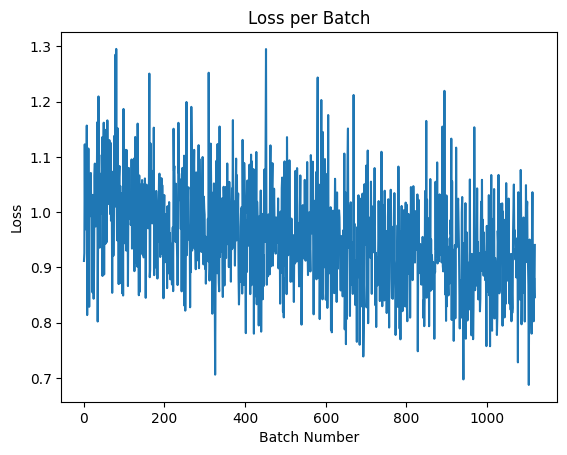

In [12]:
import psutil
import time
from fvcore.nn import FlopCountAnalysis
from codecarbon import EmissionsTracker
from sklearn.metrics import log_loss
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=5e-5) # Adjust learning rate as needed
loss_fn = nn.CrossEntropyLoss()


# Training loop
epochs = 2  # Adjust the number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

start_time = time.time()

print(next(model.parameters()).device)

for epoch in range(epochs):
    loss_values=[]
    nb_batch=[]
    tracker = EmissionsTracker()
    tracker.start()
    model.train()
    total_loss = 0
    total_samples = 0
    i=0

    for batch in train_dataloader:
        i+=1
        nb_batch.append(i)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loss_values.append(loss.item())
        total_samples += len(labels_np)

        print(f"Batch {i}/{len(train_dataloader)} - Loss: {loss.item()}")

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss}")

    #Evaluate memory usage
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    print(f"Epoch {epoch+1}/{epochs}, Memory Usage: {memory_info.rss / 1024 / 1024} MB")

    #Evaluate training time per step
    total_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs}, Total Training Time: {total_time / 60:.2f} minutes")

    #Track energy consumption
    tracker.stop()
    print(f"Epoch {epoch+1}/{epochs}, Energy consumption: {tracker}")

#Graph loss and logloss per batch
plt.plot(nb_batch, loss_values)
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Loss per Batch")
plt.show()

# Save the trained model (optional)
torch.save(model.state_dict(), "trained_model.pth")



In [19]:
#Test and evaluate
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from rouge import Rouge
from sentence_transformers import SentenceTransformer, util
import psutil
import time
from fvcore.nn import FlopCountAnalysis
from codecarbon import EmissionsTracker

def generate_conversation(persona1, persona2):
    input_text = persona1 + persona2
    input_ids = TOKENIZER(input_text, return_tensors="pt").input_ids

    # Generate response
    output_ids = model.generate(input_ids, max_length=150, num_beams=5, temperature=0.7)
    output_text = TOKENIZER.decode(output_ids[0], skip_special_tokens=True)

    return output_text

persona1 = "I love hiking and nature walks. I also enjoy photography."
persona2 = "I prefer staying indoors and reading books. I love mystery novels."
generated_conversation = generate_conversation(persona1, persona2)

print("Generated Chatbot Conversation:\n", generated_conversation)

def calculate_rouge_score(predictions, true_labels):
    rouge = Rouge()
    # Decode predictions and true_labels to strings before passing to Rouge
    predictions_decoded = [TOKENIZER.decode(p, skip_special_tokens=True) for p in predictions]
    true_labels_decoded = [TOKENIZER.decode(l, skip_special_tokens=True) for l in true_labels]

    # Filter out empty hypotheses and corresponding references
    filtered_predictions_decoded = []
    filtered_true_labels_decoded = []
    for pred, label in zip(predictions_decoded, true_labels_decoded):
        if pred.strip(): # Check if the prediction is not empty after stripping whitespace
            filtered_predictions_decoded.append(pred)
            filtered_true_labels_decoded.append(label)

    # Calculate average scores only if there are valid predictions
    if filtered_predictions_decoded:
        scores = rouge.get_scores(filtered_predictions_decoded, filtered_true_labels_decoded, avg=True)
    else:
        scores = {'rouge-1': {'f': 0, 'p': 0, 'r': 0}, 'rouge-2': {'f': 0, 'p': 0, 'r': 0}, 'rouge-l': {'f': 0, 'p': 0, 'r': 0}}
    return scores

def calculate_persona_consistency_score(persona_1_statements, persona_2_statements, predicted_response):
    # Initialize a SentenceTransformer model
    sentence_model = SentenceTransformer('all-mpnet-base-v2')  # You can choose a different pre-trained model if needed

    # Encode persona statements
    persona_1_embedding = sentence_model.encode(persona_1_statements, convert_to_tensor=True)
    persona_2_embedding = sentence_model.encode(persona_2_statements, convert_to_tensor=True)

    # Decode predicted_response to string before encoding
    predicted_response_decoded = TOKENIZER.decode(predicted_response[0], skip_special_tokens=True)  # Assuming predicted_response is a tensor
    response_embedding = sentence_model.encode(predicted_response_decoded, convert_to_tensor=True)

    # Compute cosine similarity
    user_1_score = util.pytorch_cos_sim(response_embedding, persona_1_embedding).mean().item()
    user_2_score = util.pytorch_cos_sim(response_embedding, persona_2_embedding).mean().item()

    # Compute average consistency score
    avg_consistency_score = (user_1_score + user_2_score) / 2

    return avg_consistency_score, user_1_score, user_2_score

def evaluate(model, test_dataloader):
    model.eval()
    correct = 0
    total = 0

    all_predictions = []  # Store all predictions
    all_labels = []  # Store all labels

    with torch.no_grad():
      for batch in test_dataloader:
            input_ids =  batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Pass labels as decoder_input_ids during evaluation
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            # Get predictions from the logits
            predictions = torch.argmax(outputs.logits, dim=2)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            # Compare predictions with shifted labels for accuracy calculation
            shifted_labels = labels[..., 1:]  # Shift labels to the right by one position
            predictions = predictions[..., :-1]  # Remove the last prediction
            # Calculate accuracy for valid predictions (ignoring padding)
            active_positions = shifted_labels != -100  # Ignore padding positions (-100)
            correct_predictions = (predictions == shifted_labels) * active_positions
            correct += correct_predictions.sum().item()
            total += active_positions.sum().item()

            # Rouge score is a recall-based evaluation
            rouge_score= calculate_rouge_score(shifted_labels, predictions)
            # Persona Consistency Score
            average_consistency_score, user_1_score, user_2_score = calculate_persona_consistency_score(persona1, persona2, predictions)
            inference_time=total_time / len(test_dataloader)

            # Create a DataFrame for logging
            evaluation_data = {
              "Metric": ["Exactitude du modèle sur IMDb",
                          "Rouge Score","Average Consistency Score",
                          "Persona 1 Score", "Persona 2 Score", "Inference Time"
                          ],
              "Value": [(correct / total) if total > 0 else 0, rouge_score,
                        average_consistency_score, user_1_score,
                        user_2_score, inference_time]
              }
            df = pd.DataFrame(evaluation_data)
    return df
    # Display in a tab (Colab only)
    from google.colab import data_table
    data_table.DataTable(df)

evaluate(model, test_dataloader)


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Generated Chatbot Conversation:
 User 1: Hi, I'm [user 1's name]. User 2: Hi, I'm [user 2's name]. User 1: Nice to meet you, [user 2's name]. What do you like to do for fun? User 2: I like to stay indoors and read books. User 1: That's cool! I love hiking and nature walks. I also enjoy photography. User 2: That's cool! I love hiking too. What kind of books do you like to read? User 1: I like to read all kinds of books, but I especially like mysteries novels. User 2: Oh, that's cool! I like to read all kinds of books, but


[codecarbon INFO @ 02:15:44] Energy consumed for RAM : 0.941327 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 02:15:44] Energy consumed for all CPUs : 0.318943 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:15:44] 1.260271 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:15:59] Energy consumed for RAM : 0.941849 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 02:15:59] Energy consumed for all CPUs : 0.319120 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:15:59] 1.260969 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:16:14] Energy consumed for RAM : 0.942372 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 02:16:14] Energy consumed for all CPUs : 0.319297 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:16:14] 1.261669 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:16:29] Energy consumed for RAM : 0.942894 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 02:16:29] Energy consumed for a

,Metric,Value
0,Exactitude du modèle sur IMDb,0.185473
1,Rouge Score,"{'rouge-1': {'r': 0.6466614742141544, 'p': 0.6..."
2,Average Consistency Score,0.095945
3,Persona 1 Score,0.122555
4,Persona 2 Score,0.069335
5,Inference Time,141.933307


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Metric').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Metric')):
  _plot_series(series, series_name, i)
  fig.legend(title='Metric', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_4['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_4, x='index', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)